# **01.020 Design Thinking Project III - Term 3** 
#### SC02 Group 1

Name | Student ID
:- | :-
Chua Min Pei  | 1005340 
Sim Yu Hui, Kellie | 1004204
Ryan Kaw Zheng Da | 1005144
Eunice Kwok Xiu Yi | 1005469
Ng Zhen An | 1005527 

# 1. Task 1

Task 1: Build a Multiple Linear Regression model that predicts the number of deaths in various countries due to COVID-19.

* Find data sets for the number of deaths in various countries (a minimum of 20 countries) due to COVID-19.
* Research for appropriate predictor variables to predict deaths due to COVID-19.
* You may use time as one of the predictors (in which case you could attempt to predict death rates in the future), or you may choose to leave it out (in which case, you would be looking at the deaths at a fixed chosen point in time).
*  Find data sets on the chosen predictors for the various countries in the model.
* Use plots to visualize and understand your data.
* Build a model and test the accuracy of your model, using an appropriately chosen metric
(hint: r2 is not a good metric for this task).
* If needed, improve your model by incorporating other predictors, and/or removing existing ones.
*Discuss your data sets, model, accuracy, and what metrics you used to judge the accuracy.


---


For Task 1, an implementation of your final multiple linear regression model in Excel; the Excel spreadsheet needs to be annotated and interactive (i.e. contains formulas, so that changing the data input results in different output).

## 1.1 Introduction
For Task 1, we were tasked to build a Multiple Linear Regression model that predicts the number of deaths in various countries due to COVID-19.

After some research, we decided to use the data from the site [Our World in Data (OWID)](https://ourworldindata.org/coronavirus) since it updates information on a regular daily basis from various sources. It includes data that fall within the following metrics:

| Metrics                     | Source                                                    | Updated | Countries |
|-----------------------------|-----------------------------------------------------------|---------|-----------|
| Vaccinations                | Official data collated by the Our World in Data team      | Daily   | 218       |
| Tests & positivity          | Official data collated by the Our World in Data team      | Weekly  | 139       |
| Hospital & ICU              | Official data collated by the Our World in Data team      | Weekly  | 38        |
| Confirmed cases             | JHU CSSE COVID-19 Data                                    | Daily   | 196        |
| Confirmed deaths            | JHU CSSE COVID-19 Data                                    | Daily   | 196       |
| Reproduction rate           | Arroyo-Marioli F, Bullano F, Kucinskas S, Rondón-Moreno C | Daily   | 185        |
| Policy responses            | Oxford COVID-19 Government Response Tracker               | Daily   | 186        |
| Other variables of interest | International organizations (UN, World Bank, OECD, IHME…) | Fixed   | 241       |

We will elaborate on the chosen predictor variables later in the report.

## 1.2 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1.3 Import Dataset
To obtain the latest version of the dataset, you may comment out the line below. The link to access the CSV data was obtained from the [README of OWID's repository](https://github.com/owid/covid-19-data/blob/master/public/data/README.md).

Else, for testing purposes, we have uploaded the CSV file, last updated 24 Nov, which we also used for the regression done in Excel.

In [2]:
!git clone https://github.com/kelliesyhh/t3-2d-ddw.git

Cloning into 't3-2d-ddw'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (228/228), done.
remote: Total 261 (delta 56), reused 227 (delta 29), pack-reused 0
Receiving objects: 100% (261/261), 52.06 MiB | 8.56 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [3]:
# Import dataset
file_url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
# file_url = 't3-2d-ddw/task-1/data-241121.csv'
df = pd.read_csv(file_url)

In [4]:
df_first_world_countries = df[df['human_development_index'] >= 0.8]

features = ['total_cases', 'people_vaccinated_per_hundred', 'median_age', 'icu_patients']
target = ['total_deaths']
columns = ['date', 'iso_code'] + features + target

df_task_1 = df_first_world_countries.loc[:, columns]

df_task_1['date'] = pd.to_datetime(df['date'])  
mask = (df_task_1['date'] > '2021-1-1') & (df_task_1['date'] <= '2021-6-30')
df_task_1 = df_task_1.loc[mask]
df_task_1.dropna(inplace=True)
df_task_1.to_csv("2d-task-1-v2.csv")

In [5]:
unique_codes = list(set(df_task_1['iso_code'].unique()) - set(["USA"]))

print("Number of Countries:", len(unique_codes))
print(unique_codes)

Number of Countries: 26
['FRA', 'CAN', 'IRL', 'MYS', 'CHE', 'FIN', 'BGR', 'EST', 'ITA', 'CYP', 'ISR', 'ROU', 'SRB', 'GBR', 'SVN', 'PRT', 'AUT', 'SWE', 'LUX', 'DNK', 'ESP', 'NLD', 'DEU', 'BEL', 'CZE', 'MLT']


## 1.4 Multiple Linear Regression Model

### 1.4.1 Visualisation and Plots

For visualisation of the data, we made use of Matplotlib and Seaborn that were introduced to us in class and the [pre-class material](https://github.com/Data-Driven-World/d2w_notes/blob/master/Visualization.ipynb). 

As the code for visualisation was repeated over the course of this report, we decided to insert them as functions for easy usage in the other cells. 

For any data that required preprocessing or further DataFrame analysis, we made use of codes from the cohort lessons and [pre-class material](https://github.com/Data-Driven-World/d2w_notes/blob/master/Working_With_Data.ipynb). 

In [6]:
def determine_correlation(df, column_name): 
  """Takes a DataFrame and a column name, return a DataFrame containing the correlation score between the column that matches the given name and all other columns."""
  pd.set_option('display.max_rows', None)
  correlations = df.corr()
  df_correlation = pd.DataFrame(correlations.loc[:, [column_name]])
  return df_correlation[[column_name]].sort_values(by=column_name, ascending=False)[1:]

def plot_correlation_heatmaps(df, figsize, annot=False):
  """Takes a DataFrame, the figsize of the heatmap to be plotted, and whether the heatmap should be annotated (default False), returns nothing."""
  correlations = df.corr()
  plt.figure(figsize=figsize)
  sns.heatmap(correlations, cmap="coolwarm", annot=annot)
  plt.show()

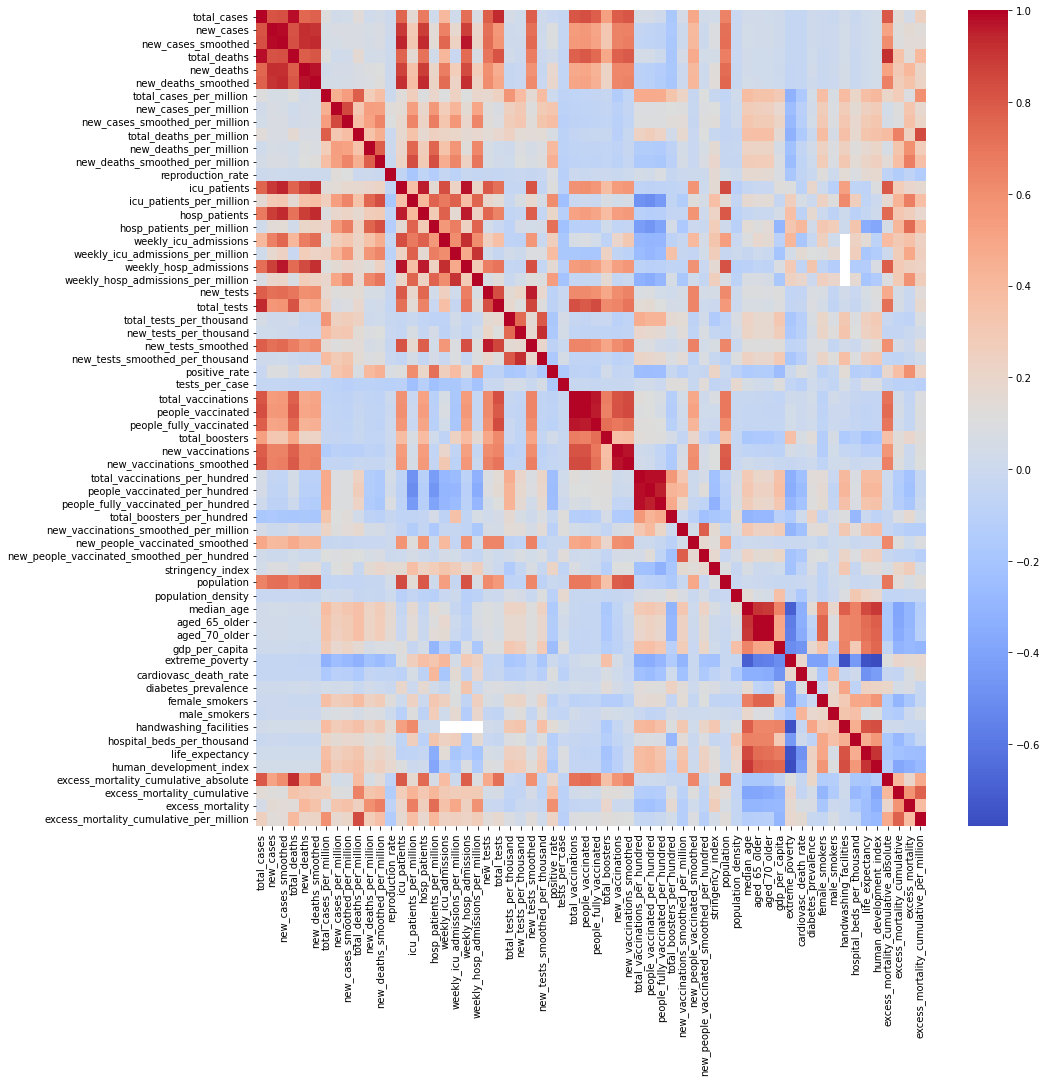

total_deaths
total_cases                                     0.984999
excess_mortality_cumulative_absolute            0.924791
new_cases_smoothed                              0.833300
new_cases                                       0.820385
total_tests                                     0.816577
new_deaths_smoothed                             0.807724
people_vaccinated                               0.801306
new_vaccinations_smoothed                       0.792375
new_deaths                                      0.785556
total_vaccinations                              0.776865
new_vaccinations                                0.771124
icu_patients                                    0.769885
people_fully_vaccinated                         0.749599
weekly_hosp_admissions                          0.738447
hosp_patients                                   0.711667
new_tests                                       0.695591
new_tests_smoothed                              0.670885
population                                      0.660376
total_boosters                                  0.487447
new_people_vaccinated_smoothed                  0.477917
weekly_icu_admissions                           0.414376
excess_mortality_cumulative_per_million         0.395564
excess_mortality_cumulative                     0.346920
icu_patients_per_million                        0.164242
total_deaths_per_million                        0.162019
excess_mortality                                0.133797
total_cases_per_million                         0.104740
weekly_hosp_admissions_per_million              0.072313
new_vaccinations_smoothed_per_million           0.051859
new_deaths_smoothed_per_million                 0.047764
total_vaccinations_per_hundred                  0.044995
people_vaccinated_per_hundred                   0.043672
stringency_index                                0.042704
handwashing_facilities                          0.040599
new_people_vaccinated_smoothed_per_hundred      0.038436
human_development_index                         0.037310
new_deaths_per_million                          0.036053
median_age                                      0.032144
positive_rate                                   0.029646
hosp_patients_per_million                       0.029012
total_tests_per_thousand                        0.028327
new_cases_smoothed_per_million                  0.027756
aged_65_older                                   0.027501
aged_70_older                                   0.024749
diabetes_prevalence                             0.024438
new_cases_per_million                           0.023184
life_expectancy                                 0.022777
gdp_per_capita                                  0.008343
people_fully_vaccinated_per_hundred             0.003862
reproduction_rate                               0.000631
new_tests_per_thousand                         -0.000498
male_smokers                                   -0.005831
new_tests_smoothed_per_thousand                -0.005964
female_smokers                                 -0.007075
hospital_beds_per_thousand                     -0.010110
weekly_icu_admissions_per_million              -0.015138
population_density                             -0.019497
cardiovasc_death_rate                          -0.041129
extreme_poverty                                -0.041604
tests_per_case                                 -0.046486
total_boosters_per_hundred                     -0.184973

In [7]:
df_correlation = determine_correlation(df, "total_deaths")
plot_correlation_heatmaps(df, figsize=(15, 15), annot=False)
df_correlation

Based on our analysis above, we narrowed down to 4 different predictor variables to be used for our Multiple Linear Regression model. The predictor variables, the relevant descriptions, and metrics (mentioned in Section 1.1 above) can be seen in the table below.

**Predictor Variables (X)**

Variable (X) | Description | Metrics (from OWID)
-------------------|------------------ | ------------------
total_cases | Total confirmed cases of COVID-19 | Confirmed cases
people_vaccinated_per_hundred      | Total number of people who received at least one vaccine dose per 100 people in the total population | Vaccinations
icu_patients | Number of COVID-19 patients in intensive care units (ICUs) on a given day | Hospital & ICU 
median_age | Median age of the population, UN projection for 2020 | Others


**Predicted Variable (y)**

Variable (y) | Description | Category
-------------------|------------------ | ------------------
total_deaths | Total deaths attributed to COVID-19 | Confirmed deaths

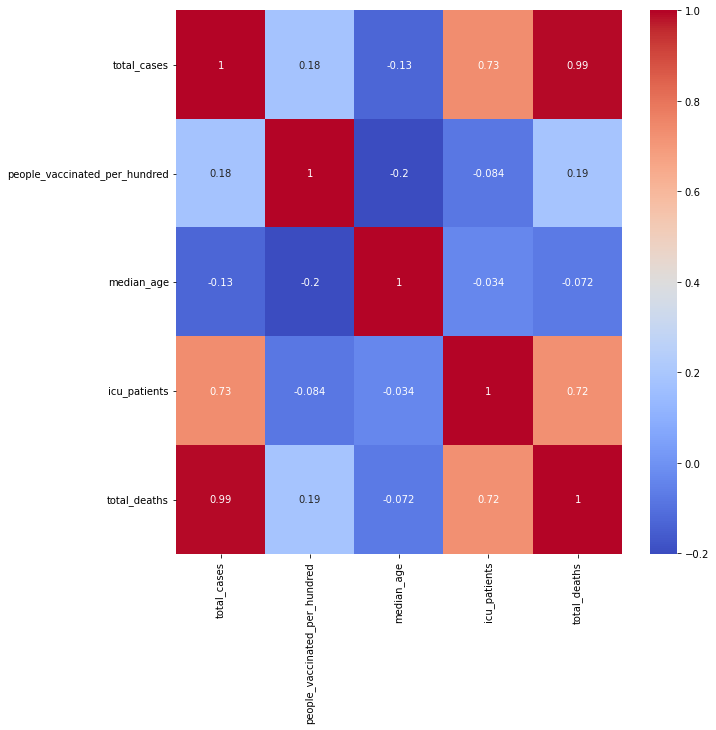

In [8]:
features = ['total_cases', 'people_vaccinated_per_hundred', 'median_age', 'icu_patients']
target = ['total_deaths']
columns = features + target

df_task_1 = df_task_1[columns]
plot_correlation_heatmaps(df_task_1, figsize=(10, 10), annot=True)

### 1.4.2 Helper Functions and Code for Model
In this section, we defined functions that were utilised in the model, taken from the cohort lessons and [pre-class material](https://github.com/Data-Driven-World/d2w_notes/blob/master/Multiple_Linear_Regression.ipynb).

In [9]:
def normalize_z(df):
  """Takes a DataFrame, returns a DataFrame with normalized values using z-score normalization."""
  dfout = (df - df.mean(axis=0)) / df.std(axis=0)
  return dfout

def normalize_minmax(df):
  """Takes a DataFrame, returns a DataFrame with normalized values using min-max normalization."""
  dfout = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))
  return dfout

def transform_features(df_feature, colname, colname_transformed):
  """Takes a DataFrame, the name of a column to be transformed, and the name for the transformed column, returns a DataFrame with an additional column for the transformed data."""
  df_feature[colname_transformed] = df[colname].apply(lambda x: x**2)
  return df_feature

def get_features_targets(df, feature_names, target_names):
  """Takes a DataFrame, a list of columns for the features, and a list of columns for the target, returns a DataFrame containing the features and a DataFrame containing the target."""
  df_feature = df.loc[:, feature_names]
  df_target = df.loc[:, target_names]
  return df_feature, df_target

def prepare_feature(df_feature):
  """Takes a DataFrame containing the features, convert it into a numpy array, change it to a column vector, and add a column of '1's in the first column, returns a numpy.array containing the features."""
  cols = len(df_feature.columns)
  np_feature = df_feature.to_numpy().reshape(-1, cols)
  constants = np.ones(shape=(np_feature.shape[0], 1))
  return np.concatenate((constants, np_feature), axis=1)

def prepare_target(df_target):
  """Takes a DataFrame containing the target, convert it into a numpy array, change it to a column vector, returns a Numpy array containing the target."""
  cols = len(df_target.columns)
  np_target = df_target.to_numpy().reshape(-1, cols)
  return np_target

def predict(df_feature, beta):
  """Takes a DataFrame and an array of beta values, returns the predicted y values after z-normalization and conversion to a Numpy array."""
  df_feature = normalize_z(df_feature)
  np_X = prepare_feature(df_feature)
  return predict_norm(np_X, beta)

def predict_norm(X, beta):
  """Takes a Numpy array and an array of beta values, returns the straight line equation after standardization and adding of column for constant 1."""
  y_pred = np.matmul(X, beta)
  return y_pred
    
def split_data(df_feature, df_target, random_state=None, test_size=0.5):
  """Takes a DataFrame containing the features, a DataFrame containing the target, the seed used to split randomly, and the fraction used to split randomly (default 0.5), returns a tuple of 4 DataFrames containing the train and test sets for the features and target DataFrames."""
  # indexes = which is the number of rows
  indexes = df_feature.index
  if random_state != None:
      np.random.seed(random_state)

  # k = length / size of the test array
  k = int(test_size * len(indexes))

  test_index = np.random.choice(indexes, k, replace=False)
  train_index = list(set(indexes) - set(test_index))

  df_feature_train = df_feature.loc[train_index, :]
  df_feature_test = df_feature.loc[test_index, :]
  df_target_train = df_target.loc[train_index, :]
  df_target_test = df_target.loc[test_index, :]

  return df_feature_train, df_feature_test, df_target_train, df_target_test

In [10]:
def compute_cost(X, y, beta):
  """Takes a Numpy array containing the features, a Numpy array containing the target, and beta coefficients at the end of the iteration, returns an array of computed cost function values."""
  J = 0
  # m = X.shape[0]
  # y_hat = np.matmul(X, beta)
  # J = np.sum((y_hat - y) ** 2)/(2*m)
  # error = np.matmul(X, beta) - y
  # J = np.matmul(error.T, error)
  # J = J / (2*m)
  # J = 0
  m = X.shape[0]
  error = np.matmul(X, beta) - y
  error_sq = np.matmul(error.T, error)
  J = (1/(2*m))*error_sq
  J = J[0][0]
  return J


def gradient_descent(X, y, beta, alpha, num_iters):
  """Takes a Numpy array containing the features, a Numpy array containing the target, an array of beta values, the learning rate, the number of iterations to perform, returns the beta coefficient at the end of the iteration, and an array storing the cost value at each iteration."""
  # # m = number of data points
  # m = X.shape[0]
  # # cost function in each iteration
  # J = np.zeros((num_iters, 1)) 
  # k = 0
  # while k < num_iters:        
  #   y_hat = np.matmul(X, beta)
  #   deriv = np.matmul(X.T, (y_hat - y)) 
  #   beta = beta - alpha/m * deriv
  #   J[k] = compute_cost(X, y, beta)
  #   k += 1
  # return beta, J
  m = X.shape[0]
  J_storage = np.zeros((num_iters,1))
  for n in range(num_iters):
    deriv = np.matmul(X.T, (np.matmul(X, beta)-y))
    beta = beta - alpha * (1/m) * deriv
    J_storage[n] = compute_cost(X, y, beta)
  return beta, J_storage

For accuracy metrics, we decided to look through the [scikit-learn Regression Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) site in order to find possible metrics we could use.  
As mentioned in the task brief, R^2 is not a good metric to be used for Multiple Linear Regression. As such, we decided to take into account the metric adjusted R^2, which will show us if the variables used were potentially overfitting our model.
* Adjusted R^2 Score: an improved version of R^2 score that penalizes us for adding an independent variable that does not help in predicting the dependent variable [1] [2]

Sources:
1. https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/
2. https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/

In [11]:
def r2_score(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns the r2 score."""
  '''res = np.sum((target - pred) ** 2)
  ymean = np.mean(target)
  tot = np.sum((target - ymean) ** 2)
  r2 = 1 - res/tot'''

  diff = target-pred
  ssres = np.matmul(diff.T,diff)[0][0]
  target_mean = np.mean(target)
  diff_mean = target - target_mean
  sstot = np.matmul(diff_mean.T, diff_mean)[0][0]
  return 1 - (ssres/sstot)
  

def adjusted_r2_score(r2, n, k):
  """Takes the R^2 score, number of data points, and number of features, returns the adjusted r2 score."""
  num = (1 - r2) * (n - 1)
  den = n - k - 1
  return 1 - num/den

def ss_score(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns a tuple of the sum of square of residuals and total sum of squares."""
  # sum of square of residuals
  res = np.sum((target - pred) ** 2)
  # total sum of squares
  ymean = np.mean(target)
  tot = np.sum((target - ymean) ** 2)
  return res, tot

def mean_squared_error(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns the mean squared error."""
  ysum = np.sum((target - pred) ** 2)
  n = target.shape[0]
  return ysum/n

def mean_absolute_error(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns the mean absolute error."""
  ysum = np.sum(abs(target - pred))
  n = target.shape[0]
  return ysum / n

def root_mean_squared_error(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns the root mean squared error."""
  ysum = np.sum((target - pred) ** 2)
  n = target.shape[0]
  return np.sqrt(ysum/n)

def mean_squared_log_error(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns the mean squared log error."""
  return np.mean((np.log(target + 1) - np.log(pred + 1)) ** 2)

def root_mean_squared_log_error(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns the root mean squared log error."""
  return np.sqrt(mean_squared_log_error(target, pred))

In [19]:
def multiple_linear_regression(df_features, df_target):
  # Normalize the features using z normalization
  df_target = normalize_z(df_target)
#   df_features = normalize_z(df_features)

  # Change the features and the target to numpy array using the prepare functions
  X = prepare_feature(df_features)
  target = prepare_target(df_target)

  iterations = 15000
  alpha = 0.01
  beta = np.zeros((X.shape[1], 1))

  # Call the gradient_descent function
  beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
  
  # call the predict() method
  pred = predict(df_features, beta)

  # # Plotting figures for visualisation
  plt.figure()
  plt.title("J_storage")
  plt.plot(J_storage)
  for column in df_features.columns:
    plt.figure()
    plt.xlabel(column)
    plt.ylabel("total_deaths_per_million")
    plt.scatter(df_features[column], target, color='blue')
    plt.scatter(df_features[column], pred, color='orange')
    plt.show()

  # # Calculate R^2, Adjusted R^2
  print("R^2 Score: ", r2_score(target, pred))
  print("Adjusted R^2 Score: ", adjusted_r2_score(r2_score(target, pred), X.shape[0], X.shape[1]))

  return beta

##### 1.4.2.1 Running Model on Original Dataset

In [20]:
feature_combis = []
import itertools
for x in range(1, len(features)+1):
    for subset in itertools.combinations(features, x):
      feature_combis.append(subset)

Feature(s) Used:  ('total_cases',)


<ipython-input-10-167596548e7b>:13: RuntimeWarning: overflow encountered in matmul
  error_sq = np.matmul(error.T, error)
<ipython-input-10-167596548e7b>:36: RuntimeWarning: overflow encountered in matmul
  deriv = np.matmul(X.T, (np.matmul(X, beta)-y))
<ipython-input-10-167596548e7b>:37: RuntimeWarning: invalid value encountered in subtract
  beta = beta - alpha * (1/m) * deriv


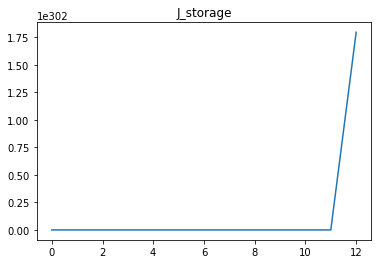

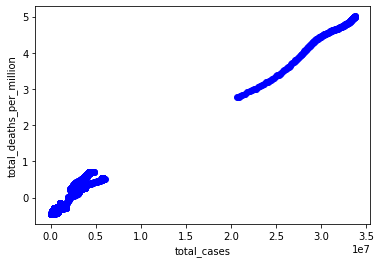

R^2 Score:  nan
Adjusted R^2 Score:  nan
Beta Coefficient Values:  [[nan]
 [nan]]


Feature(s) Used:  ('people_vaccinated_per_hundred',)


<ipython-input-10-167596548e7b>:13: RuntimeWarning: overflow encountered in matmul
  error_sq = np.matmul(error.T, error)
<ipython-input-10-167596548e7b>:36: RuntimeWarning: overflow encountered in matmul
  deriv = np.matmul(X.T, (np.matmul(X, beta)-y))
<ipython-input-10-167596548e7b>:12: RuntimeWarning: invalid value encountered in matmul
  error = np.matmul(X, beta) - y
<ipython-input-10-167596548e7b>:36: RuntimeWarning: invalid value encountered in matmul
  deriv = np.matmul(X.T, (np.matmul(X, beta)-y))


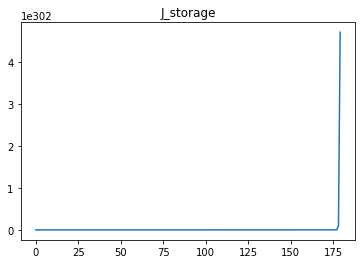

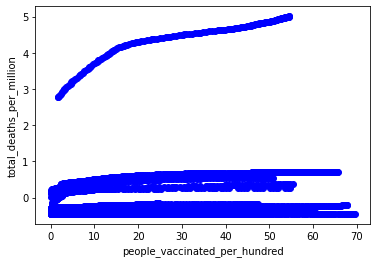

R^2 Score:  nan
Adjusted R^2 Score:  nan
Beta Coefficient Values:  [[nan]
 [nan]]


Feature(s) Used:  ('median_age',)


<ipython-input-10-167596548e7b>:13: RuntimeWarning: overflow encountered in matmul
  error_sq = np.matmul(error.T, error)
<ipython-input-10-167596548e7b>:36: RuntimeWarning: overflow encountered in matmul
  deriv = np.matmul(X.T, (np.matmul(X, beta)-y))
<ipython-input-10-167596548e7b>:37: RuntimeWarning: invalid value encountered in subtract
  beta = beta - alpha * (1/m) * deriv


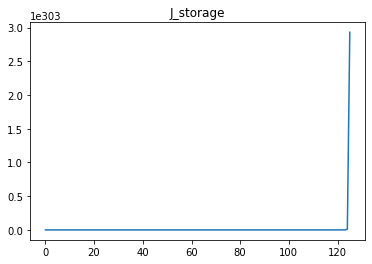

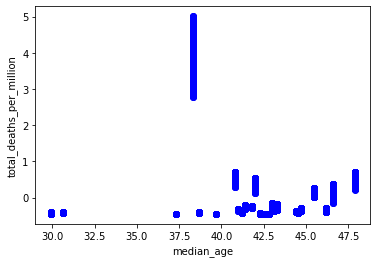

R^2 Score:  nan
Adjusted R^2 Score:  nan
Beta Coefficient Values:  [[nan]
 [nan]]


Feature(s) Used:  ('icu_patients',)


<ipython-input-10-167596548e7b>:13: RuntimeWarning: overflow encountered in matmul
  error_sq = np.matmul(error.T, error)
<ipython-input-10-167596548e7b>:36: RuntimeWarning: overflow encountered in matmul
  deriv = np.matmul(X.T, (np.matmul(X, beta)-y))
<ipython-input-10-167596548e7b>:12: RuntimeWarning: invalid value encountered in matmul
  error = np.matmul(X, beta) - y
<ipython-input-10-167596548e7b>:36: RuntimeWarning: invalid value encountered in matmul
  deriv = np.matmul(X.T, (np.matmul(X, beta)-y))


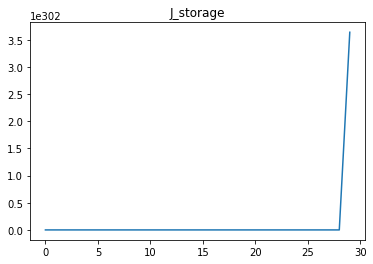

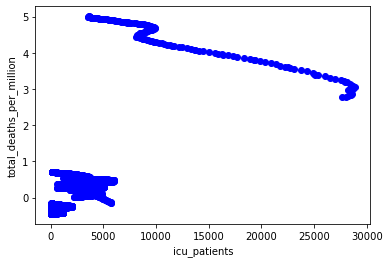

R^2 Score:  nan
Adjusted R^2 Score:  nan
Beta Coefficient Values:  [[nan]
 [nan]]


Feature(s) Used:  ('total_cases', 'people_vaccinated_per_hundred')


<ipython-input-10-167596548e7b>:13: RuntimeWarning: overflow encountered in matmul
  error_sq = np.matmul(error.T, error)
<ipython-input-10-167596548e7b>:36: RuntimeWarning: overflow encountered in matmul
  deriv = np.matmul(X.T, (np.matmul(X, beta)-y))
<ipython-input-10-167596548e7b>:36: RuntimeWarning: invalid value encountered in matmul
  deriv = np.matmul(X.T, (np.matmul(X, beta)-y))
<ipython-input-10-167596548e7b>:37: RuntimeWarning: invalid value encountered in subtract
  beta = beta - alpha * (1/m) * deriv


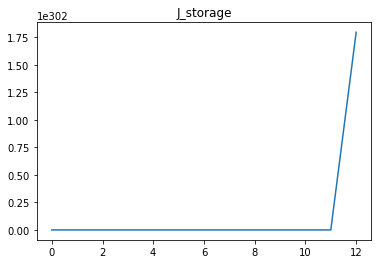

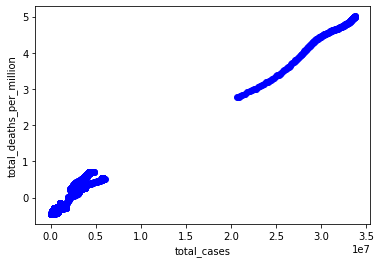

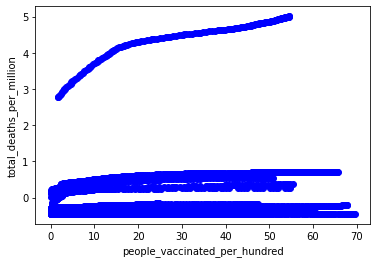

R^2 Score:  nan
Adjusted R^2 Score:  nan
Beta Coefficient Values:  [[nan]
 [nan]
 [nan]]


Feature(s) Used:  ('total_cases', 'median_age')


<ipython-input-10-167596548e7b>:13: RuntimeWarning: overflow encountered in matmul
  error_sq = np.matmul(error.T, error)
<ipython-input-10-167596548e7b>:36: RuntimeWarning: overflow encountered in matmul
  deriv = np.matmul(X.T, (np.matmul(X, beta)-y))
<ipython-input-10-167596548e7b>:37: RuntimeWarning: invalid value encountered in subtract
  beta = beta - alpha * (1/m) * deriv


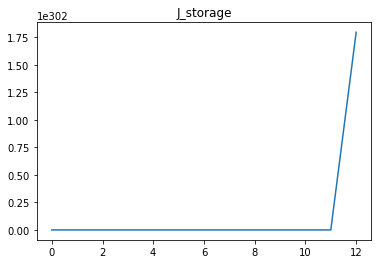

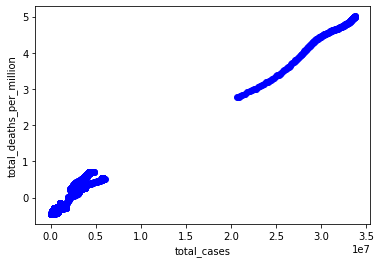

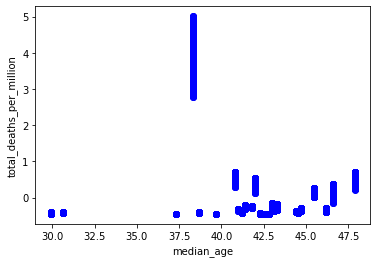

R^2 Score:  nan
Adjusted R^2 Score:  nan
Beta Coefficient Values:  [[nan]
 [nan]
 [nan]]


Feature(s) Used:  ('total_cases', 'icu_patients')


<ipython-input-10-167596548e7b>:13: RuntimeWarning: overflow encountered in matmul
  error_sq = np.matmul(error.T, error)
<ipython-input-10-167596548e7b>:36: RuntimeWarning: overflow encountered in matmul
  deriv = np.matmul(X.T, (np.matmul(X, beta)-y))


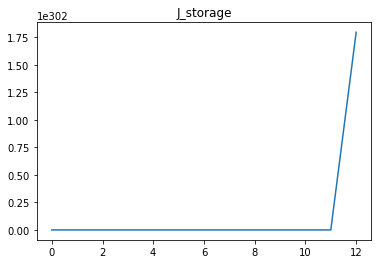

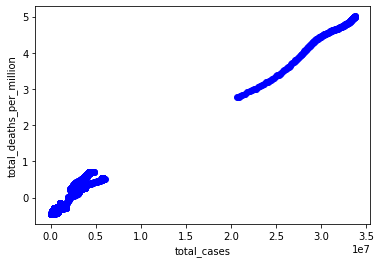

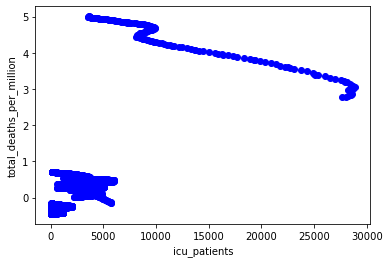

R^2 Score:  nan
Adjusted R^2 Score:  nan
Beta Coefficient Values:  [[nan]
 [nan]
 [nan]]


Feature(s) Used:  ('people_vaccinated_per_hundred', 'median_age')


<ipython-input-10-167596548e7b>:13: RuntimeWarning: overflow encountered in matmul
  error_sq = np.matmul(error.T, error)
<ipython-input-10-167596548e7b>:36: RuntimeWarning: overflow encountered in matmul
  deriv = np.matmul(X.T, (np.matmul(X, beta)-y))


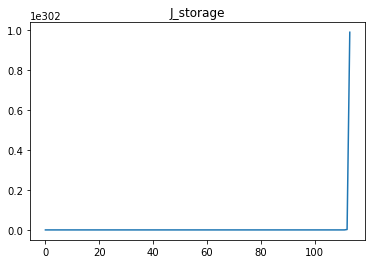

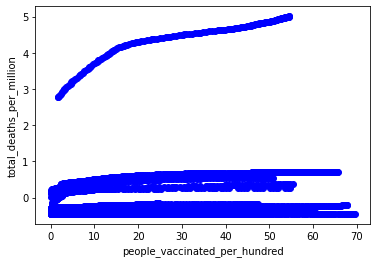

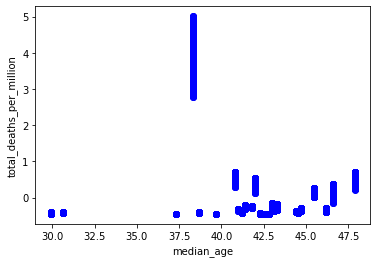

R^2 Score:  nan
Adjusted R^2 Score:  nan
Beta Coefficient Values:  [[nan]
 [nan]
 [nan]]


Feature(s) Used:  ('people_vaccinated_per_hundred', 'icu_patients')


<ipython-input-10-167596548e7b>:13: RuntimeWarning: overflow encountered in matmul
  error_sq = np.matmul(error.T, error)
<ipython-input-10-167596548e7b>:36: RuntimeWarning: overflow encountered in matmul
  deriv = np.matmul(X.T, (np.matmul(X, beta)-y))
<ipython-input-10-167596548e7b>:36: RuntimeWarning: invalid value encountered in matmul
  deriv = np.matmul(X.T, (np.matmul(X, beta)-y))


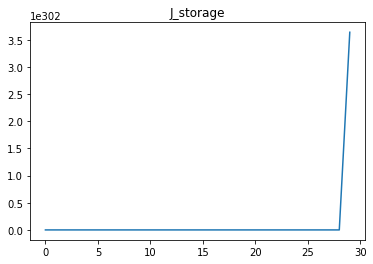

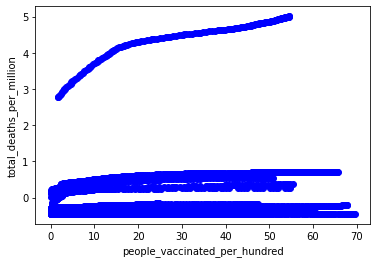

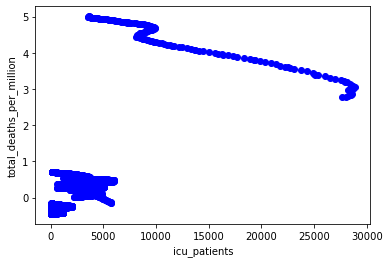

R^2 Score:  nan
Adjusted R^2 Score:  nan
Beta Coefficient Values:  [[nan]
 [nan]
 [nan]]


Feature(s) Used:  ('median_age', 'icu_patients')


<ipython-input-10-167596548e7b>:13: RuntimeWarning: overflow encountered in matmul
  error_sq = np.matmul(error.T, error)
<ipython-input-10-167596548e7b>:36: RuntimeWarning: overflow encountered in matmul
  deriv = np.matmul(X.T, (np.matmul(X, beta)-y))


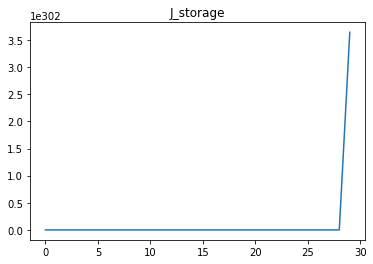

In [ ]:
for combi in feature_combis:
  # df_combi = df_features.loc[:, combi]
  print("Feature(s) Used: ", combi)
  df_features, df_target = get_features_targets(df_task_1, combi, target)
  beta = multiple_linear_regression(df_features, df_target)
  print("Beta Coefficient Values: ", beta)
  print("\n")

Feature(s) Used:  ('total_cases', 'people_vaccinated_per_hundred', 'median_age', 'icu_patients')


<ipython-input-10-167596548e7b>:13: RuntimeWarning: overflow encountered in matmul
  error_sq = np.matmul(error.T, error)
<ipython-input-10-167596548e7b>:36: RuntimeWarning: overflow encountered in matmul
  deriv = np.matmul(X.T, (np.matmul(X, beta)-y))


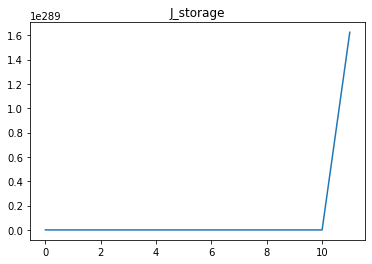

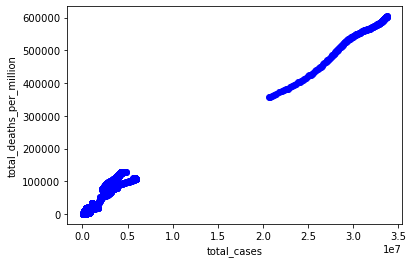

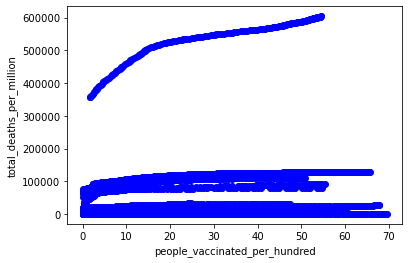

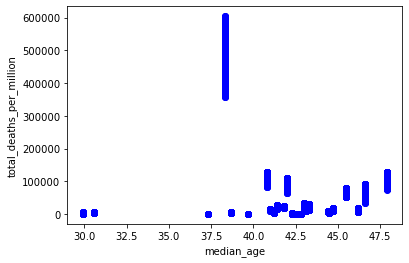

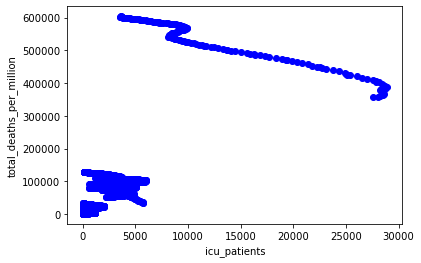

R^2 Score:  nan
Adjusted R^2 Score:  nan
Beta Coefficient Values:  [[nan]
 [nan]
 [nan]
 [nan]
 [nan]]




In [15]:
print("Feature(s) Used: ", feature_combis[-1])
combi = feature_combis[-1]
df_features, df_target = get_features_targets(df_task_1, combi, target)
beta = multiple_linear_regression(df_features, df_target)
print("Beta Coefficient Values: ", beta)
print("\n")

In [241]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Instantiate LinearRegression() object
model = LinearRegression()

# Call the fit() method
model.fit(df_features, df_target)

print(model.coef_, model.intercept_)
print(r2_score(df_target, model.predict(df_features)))

[[ 1.80965576e-02  9.98348630e+01  1.61867092e+03 -2.40322606e-01]] [-64188.30104961]
0.9867076503113672


In [243]:
# df_features = normalize_z(df_features)
feature = prepare_feature(df_features)
pred = beta[0] + beta[1] * df_features['total_cases'] + beta[2] * df_features['people_vaccinated_per_hundred'] + beta[3] * df_features['median_age'] + beta[4] * df_features['icu_patients']

In [244]:
ytrue = prepare_target(df_target)

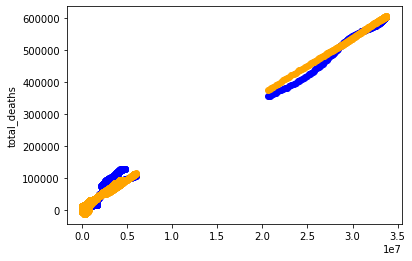

In [242]:
plt.figure()
# plt.xlabel('total_cases')
plt.ylabel("total_deaths")
plt.scatter(df_features['total_cases'], ytrue, color='blue')
plt.scatter(df_features['total_cases'], pred, color='orange')
plt.show()

# Task 2

Task 2: You are free to find and define a problem (apply the discovery and define phases first, from the UK Design Council Double Diamond, 3.007 Design Thinking and Innovation) of your interest related to COVID-19. The problem can be modelled either using Linear Regression (or Multiple Linear Regression) or Logistic Regression, which means you can work with either continuous numerical data or classification.
* Find an interesting problem which you want to solve either using Linear Regression or Classification (please check with your instructors first on whether the problem makes sense).
* Find a dataset to build your model. For example, you can use Kaggle
(https://www.kaggle.com/datasets) to find suitable datasets.
* Use plots to visualize and understand your data.
* Create training and test data sets.
* Build your model.
* Choose an appropriate metric to evaluate your model (you may use the same metric as the one used in Task 1).
* Improve your model.

## 2.1 Introduction
Remote work has been a rising trend for several years, and the COVID-19 pandemic simply revealed the various opportunities and challenges of working from home for many companies globally.

With our personal experience of the different measures such as lockdowns and circuit breakers affecting our day-to-day life last year, we decided to predict how various policies would affect stay home requirements in several countries.

Locally, there has been a recent trend where there has been an increase in differentiated measures for vaccinated citizens. As such, we decided to incorporate vaccination policies as one of our predictor variables. We expect that increasing the availability of vaccines can allow us to relax the stay home requirement policies. This is because with the increasing availability of vaccines, more people are potentially able to get access to the vaccine and as a result, more people would be vaccinated. With more vaccinated people, we can be more assured that there will be lesser cases and transmission of the virus and society would also be able to progress towards herd immunity. Hence, with more vaccinations, it is possible to relax the stay home requirement policies.

Singapore has been implementing various ease-in and restrictive measures on the size of public gatherings in the past 2 years. If the maximum limit for gatherings is reduced, we expect there to be lesser group gatherings and close interactions. The restrictions may hinder people who would want to go out and socialize with their friends. As a result, this would lead to an increase in the number of people staying at home, giving a similar effect to stricter stay home requirement policies.

At the beginning of the spread of the virus, Singapore implemented that PCR testing for Covid-19 is to be carried out for Frontline workers. Over time, PCR testing eventually opened up for the general public. By increasing the accessibility of PCR testing to more people, we will be able to test more people and identify more positive cases. With more positive cases being identified, we can expect that there would be a tendency to want to isolate these cases from further spreading the virus and hence resulting in stricter stay home requirement policies.

Although there might be debates over mask-wearing around the globe, Singapore has mostly adopted a very strong stand with regard to mask-wearing. In Singapore, mask-wearing is often compulsory when one is out of their home. If more people wear their masks, we can expect the transmission rates of the virus to be reduced due to lesser droplets passed during interactions. As lesser droplets are passed during interactions, there could be some relaxation when it comes to people gathering and hence stay home requirement policies can be relaxed.

As such, we decided to use these variables on a global scale, to see if it would affect other countries as it did Singapore.

## 2.2 Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2.3 Import Dataset and Preprocess Data
Similar to above, we looked through the [OWID Policy Responses](https://ourworldindata.org/policy-responses-covid) site in order to obtain the dataset for this section.

Upon further research, we noted that the data on OWID was actually taken from the [Oxford Covid-19 Government Response Tracker (OxCGRT)](https://www.bsg.ox.ac.uk/research/research-projects/covid-19-government-response-tracker), and hence decided to use that instead.

Considering that we were only aiming to use 4 features, cloning the entire Github repository each time we wanted to obtain the dataset was not feasible. As such, we decided to clone the repository locally, and combine the columns for the specific features into our own CSV file.

Preprocessing of data was done in both Excel and Python. After obtaining the CSV files for each feature, we converted them into DataFrames and conducted a pairwise outer merge of the DataFrames using the in-built ```merge``` function in the pandas library. The code for this is shown in this section. The ```reduce``` function from the functools library was used to apply the ```merge``` function to all 5 DataFrames and eventually return a fully merged DataFrame with all features and target variables.

Lastly, to access our dataset, we uploaded this CSV into one of our member's personal Github repositories, and cloned that repository instead.


In [ ]:
!git clone https://github.com/kelliesyhh/t3-2d-ddw.git

fatal: destination path 't3-2d-ddw' already exists and is not an empty directory.


In [ ]:
df_vac = pd.read_csv("t3-2d-ddw/task-2/covid-vaccination-policy.csv")
df_vac.name = "df_vac"
df_test = pd.read_csv("t3-2d-ddw/task-2/covid-19-testing-policy.csv")
df_test.name = "df_test"
df_face = pd.read_csv("t3-2d-ddw/task-2/face-covering-policies-covid.csv")
df_face.name = "df_face"
df_public = pd.read_csv("t3-2d-ddw/task-2/public-gathering-rules-covid.csv")
df_public.name = "df_public"
df_stay = pd.read_csv("t3-2d-ddw/task-2/stay-at-home-covid.csv")
df_stay.name = "df_stay"

dataframes = [df_vac, df_test, df_face, df_public, df_stay]

In [ ]:
from functools import reduce
df_merged = reduce(lambda left, right: pd.merge(left, right, how='outer'), dataframes)

In [ ]:
# List of all indices where NaN or blank values exist
missing_indices = list(np.where(pd.isnull(df_merged))[0])

# DataFrame of all rows containing missing values
df_missing = df_merged.loc[missing_indices, :]

# Obtaining the unique list of countries that occurs in the DataFrame above
missing_codes = list(df_missing['Code'].unique())

In [ ]:
all_codes = list(df_merged['Code'].unique())
countries = set(all_codes) - set(missing_codes)

# Get a combined DataFrame with only the countries that didn't have any missing values earlier
df_combined = df_merged.loc[df_merged['Code'].isin(countries)]
df_combined.rename(columns={'Code': 'iso_code'}, inplace=True)
df_combined.rename(columns={'Day': 'date'}, inplace=True)
df_combined.to_csv('combined.csv')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


To combine the DataFrame with the number of cases (total and new per day), we decided to work on Excel for preprocessing and upload the cleaned dataset into our GitHub repository again. The final DataFrame used in the model below was from the GitHub repository.

In [ ]:
# Import dataset
file_url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
df_owid = pd.read_csv(file_url)

In [ ]:
df_cases = df_owid.loc[:, ['iso_code', 'date', 'total_cases_per_million']]
df = pd.merge(df_combined, df_cases, how="inner", on=["iso_code", "date"])
df.to_csv("combined-w-cases.csv")

## 2.4 Multiple Linear Regression Model

#### 2.4.1 Visualisation and Plots

For visualisation of the data, we made use of Matplotlib and Seaborn that were introduced to us in class and the [pre-class material](https://github.com/Data-Driven-World/d2w_notes/blob/master/Visualization.ipynb). 

As the code for visualisation was repeated over the course of this report, we decided to insert them as functions for easy usage in the other cells. 

For any data that required preprocessing or further DataFrame analysis, we made use of codes from the cohort lessons and [pre-class material](https://github.com/Data-Driven-World/d2w_notes/blob/master/Working_With_Data.ipynb). 

In [ ]:
def determine_correlation(df, column_name): 
  """Takes a DataFrame and a column name, return a DataFrame containing the correlation score between the column that matches the given name and all other columns."""
  pd.set_option('display.max_rows', None)
  correlations = df.corr()
  df_correlation = pd.DataFrame(correlations.loc[:, [column_name]])
  return df_correlation[[column_name]].sort_values(by=column_name, ascending=False)[1:]

def plot_correlation_heatmaps(df, figsize, annot=False):
  """Takes a DataFrame, the figsize of the heatmap to be plotted, and whether the heatmap should be annotated (default False), returns nothing."""
  correlations = df.corr()
  plt.figure(figsize=figsize)
  sns.heatmap(correlations, cmap="coolwarm", annot=annot)
  plt.show()

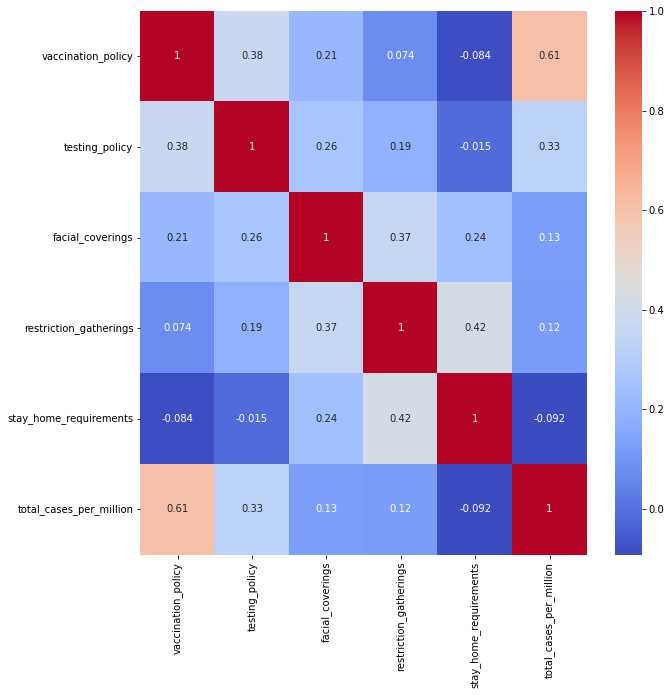

total_cases_per_million
vaccination_policy                     0.605264
testing_policy                         0.327498
facial_coverings                       0.126167
restriction_gatherings                 0.116780
stay_home_requirements                -0.092445

In [ ]:
df_correlation = determine_correlation(df, "total_cases_per_million")
plot_correlation_heatmaps(df, figsize=(10, 10), annot=True)
df_correlation

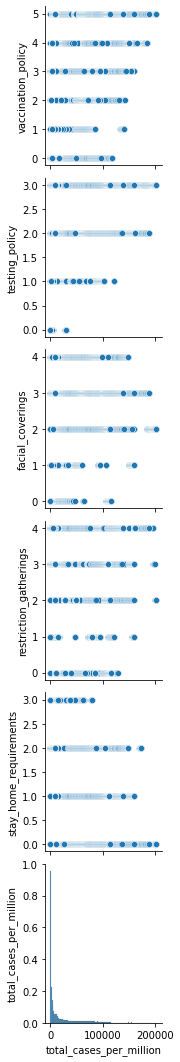

In [ ]:
# Plot predictor variables against total deaths per million
df_scatter = df.drop(labels=['Entity', 'iso_code', 'date'], axis=1)
sns.pairplot(data=df_scatter, x_vars=['total_cases_per_million'])

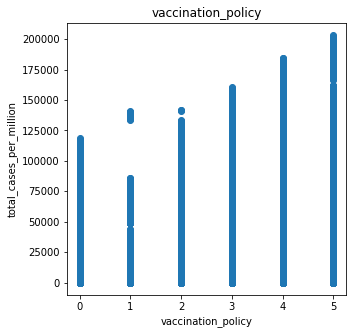

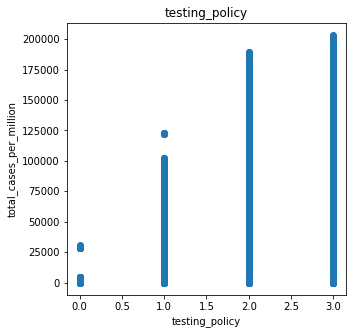

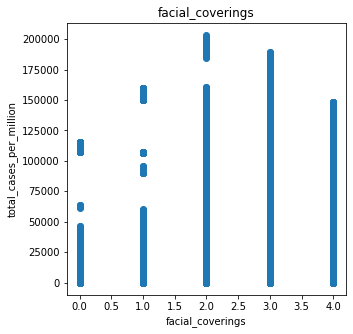

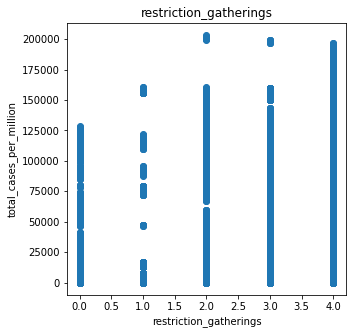

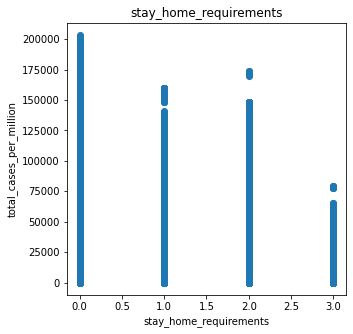

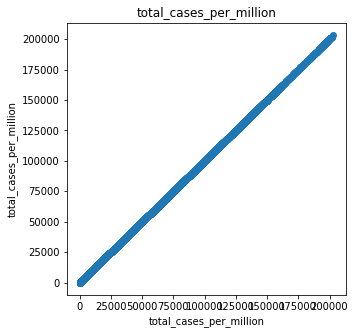

In [ ]:
for col in df_scatter.columns:
  plt.figure(figsize=(5,5))
  plt.xlabel(col)
  plt.ylabel("total_cases_per_million")
  plt.title(col)
  plt.scatter(df[col], df["total_cases_per_million"])
  plt.show() 

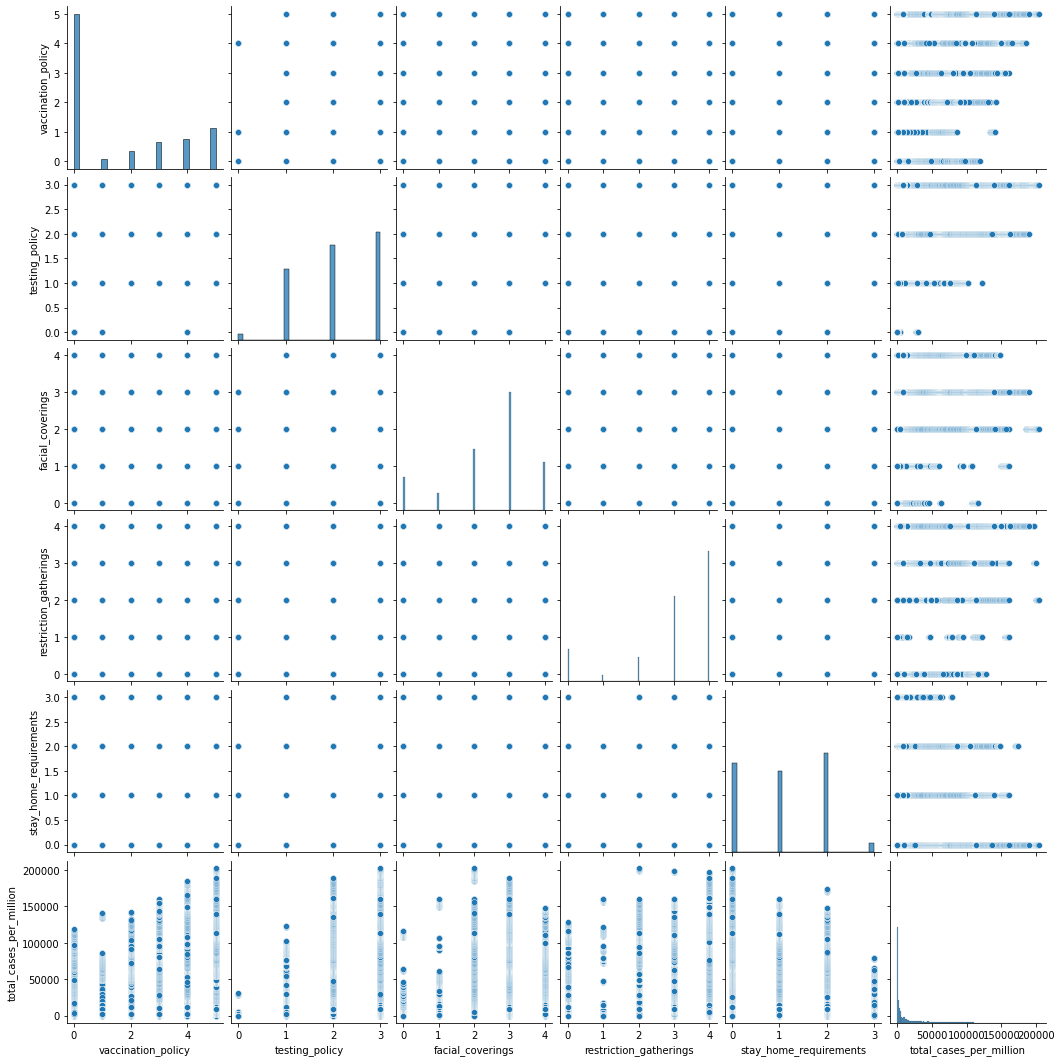

In [ ]:
sns.pairplot(data=df)

### 2.4.2 Helper Functions and Code for Model
In this section, we defined functions that were utilised in the model, taken from the cohort lessons and [pre-class material](https://github.com/Data-Driven-World/d2w_notes/blob/master/Multiple_Linear_Regression.ipynb).

In [ ]:
def normalize_z(df):
  """Takes a DataFrame, returns a DataFrame with normalized values using z-score normalization."""
  dfout = (df - df.mean(axis=0)) / df.std(axis=0)
  return dfout

def normalize_minmax(df):
  """Takes a DataFrame, returns a DataFrame with normalized values using min-max normalization."""
  dfout = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))
  return dfout

def transform_features(df_feature, colname, colname_transformed):
  """Takes a DataFrame, the name of a column to be transformed, and the name for the transformed column, returns a DataFrame with an additional column for the transformed data."""
  df_feature[colname_transformed] = df[colname].apply(lambda x: x**2)
  return df_feature

def get_features_targets(df, feature_names, target_names):
  """Takes a DataFrame, a list of columns for the features, and a list of columns for the target, returns a DataFrame containing the features and a DataFrame containing the target."""
  df_feature = df.loc[:, feature_names]
  df_target = df.loc[:, target_names]
  return df_feature, df_target

def prepare_feature(df_feature):
  """Takes a DataFrame containing the features, convert it into a numpy array, change it to a column vector, and add a column of '1's in the first column, returns a numpy.array containing the features."""
  cols = len(df_feature.columns)
  np_feature = df_feature.to_numpy().reshape(-1, cols)
  constants = np.ones(shape=(np_feature.shape[0], 1))
  return np.concatenate((constants, np_feature), axis=1)

def prepare_target(df_target):
  """Takes a DataFrame containing the target, convert it into a numpy array, change it to a column vector, returns a Numpy array containing the target."""
  cols = len(df_target.columns)
  np_target = df_target.to_numpy().reshape(-1, cols)
  return np_target

def predict(df_feature, beta):
  """Takes a DataFrame and an array of beta values, returns the predicted y values after z-normalization and conversion to a Numpy array."""
  df_feature = normalize_z(df_feature)
  np_X = prepare_feature(df_feature)
  return predict_norm(np_X, beta)

def predict_norm(X, beta):
  """Takes a Numpy array and an array of beta values, returns the straight line equation after standardization and adding of column for constant 1."""
  y_pred = np.matmul(X, beta)
  return y_pred
    
def split_data(df_feature, df_target, random_state=None, test_size=0.5):
  """Takes a DataFrame containing the features, a DataFrame containing the target, the seed used to split randomly, and the fraction used to split randomly (default 0.5), returns a tuple of 4 DataFrames containing the train and test sets for the features and target DataFrames."""
  # indexes = which is the number of rows
  indexes = df_feature.index
  if random_state != None:
      np.random.seed(random_state)

  # k = length / size of the test array
  k = int(test_size * len(indexes))

  test_index = np.random.choice(indexes, k, replace=False)
  train_index = list(set(indexes) - set(test_index))

  df_feature_train = df_feature.loc[train_index, :]
  df_feature_test = df_feature.loc[test_index, :]
  df_target_train = df_target.loc[train_index, :]
  df_target_test = df_target.loc[test_index, :]

  return df_feature_train, df_feature_test, df_target_train, df_target_test

In [ ]:
def compute_cost(X, y, beta):
  """Takes a Numpy array containing the features, a Numpy array containing the target, and beta coefficients at the end of the iteration, returns an array of computed cost function values."""
  J = 0
  m = X.shape[0]
  y_hat = np.matmul(X, beta)
  J = np.sum((y_hat - y) ** 2)/(2*m)
  error = np.matmul(X, beta) - y
  J = np.matmul(error.T, error)
  J = J / (2*m)
  return J

def gradient_descent(X, y, beta, alpha, num_iters):
  """Takes a Numpy array containing the features, a Numpy array containing the target, an array of beta values, the learning rate, the number of iterations to perform, returns the beta coefficient at the end of the iteration, and an array storing the cost value at each iteration."""
  # m = number of data points
  m = X.shape[0]

  # cost function in each iteration
  J = np.zeros((num_iters, 1)) 
  k = 0
  
  while k < num_iters:        
    y_hat = np.matmul(X, beta)
    deriv = np.matmul(X.T, (y_hat - y)) 
    beta = beta - alpha/m * deriv
    J[k] = compute_cost(X, y, beta)
    k += 1
  return beta, J

For accuracy metrics, we decided to look through the [scikit-learn Regression Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) site in order to find possible metrics we could use.  
As mentioned in the task brief, R^2 is not a good metric to be used for Multiple Linear Regression. As such, we decided to take into account the metric adjusted R^2, which will show us if the variables used were potentially overfitting our model.
* Adjusted R^2 Score: an improved version of R^2 score that penalizes us for adding an independent variable that does not help in predicting the dependent variable [1]
* Residual Sum of Squares: total square of the distance of actual points from the regression line, variation in the target variable that is not explained by our model. [2]
* Total Sum of Squares: sum of squares of the difference between the actual values and their mean, variance of Y [2]
* Mean Squared Error: tells you how close a regression line is to a set of points [3]
* Mean Absolute Error: average of all absolute errors [4]
* Root Mean Squared Error: the most common metric for regression models, follows an assumption that error are unbiased and follow a normal distribution [1] 

Sources:
1. https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/
2. https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
3. https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/mean-squared-error/
4. https://www.statisticshowto.com/absolute-error/


In [ ]:
def r2_score(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns the r2 score."""
  res = np.sum((target - pred) ** 2)
  ymean = np.mean(target)
  tot = np.sum((target - ymean) ** 2)
  r2 = 1 - res/tot
  return r2

def adjusted_r2_score(R2, n, k):
  """Takes the R^2 score, number of data points, and number of features, returns the adjusted r2 score."""
  num = (1 - R2) * (n - 1)
  den = n - k - 1
  return 1 - num/den

def ss_score(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns a tuple of the sum of square of residuals and total sum of squares."""
  # sum of square of residuals
  res = np.sum((target - pred) ** 2)
  # total sum of squares
  ymean = np.mean(target)
  tot = np.sum((target - ymean) ** 2)
  return res, tot

def mean_squared_error(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns the mean squared error."""
  ysum = np.sum((target - pred) ** 2)
  n = target.shape[0]
  return ysum/n

def mean_absolute_error(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns the mean absolute error."""
  ysum = np.sum(abs(target - pred))
  n = target.shape[0]
  return ysum / n

def root_mean_squared_error(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns the root mean squared error."""
  ysum = np.sum((target - pred) ** 2)
  n = target.shape[0]
  return np.sqrt(ysum/n)

In [ ]:
def multiple_linear_regression(df_features, df_target):
  # Split the data set into training and test
  df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

  # Normalize the features using z normalization
  df_features_train_z = normalize_z(df_features_train)

  # Change the features and the target to numpy array using the prepare functions
  X = prepare_feature(df_features_train_z)
  target = prepare_target(df_target_train)

  iterations = 1500
  alpha = 0.1
  beta = np.zeros((X.shape[1], 1), dtype=float)

  # Call the gradient_descent function
  beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
  
  # call the predict() method
  pred = predict(df_features_test, beta)

  # # Plotting figures for visualisation
  # plt.figure()
  # plt.title("J_storage")
  # plt.plot(J_storage)
  # for column in df_features_test.columns:
  #   plt.figure()
  #   plt.xlabel(column)
  #   plt.ylabel("total_cases_per_million")
  #   plt.scatter(df_features_test[column], np.array(df_target_test), color='blue')
  #   plt.scatter(df_features_test[column], pred, color='orange')
  #   plt.show()

  # Change target test set to a numpy array
  target = df_target_test.to_numpy()

  # Calculate R^2, Adjusted R^2, MSE, RMSE, MAE
  print("R^2 Score: ", r2_score(target, pred))
  print("Adjusted R^2 Score: ", adjusted_r2_score(r2_score(target, pred), X.shape[0], X.shape[1]))
  # print("SSᵣ (sum of the square of residuals): ", ss_score(target, pred)[0])
  # print("SSₜ (total sum of errors if we take the mean of the observed values as the predicted value): ", ss_score(target, pred)[1])
  print("Mean Square Error: ", mean_squared_error(target, pred))
  print("Root Mean Squared Error: ", root_mean_squared_error(target, pred))
  print("Mean Absolute Error: ", mean_absolute_error(target, pred))

  return beta

##### 2.4.2.1 Running Model on Original Dataset

Predictor Variables (X)

Variable (X) | Description | Grouped By
-------------------|------------------ | ------------------
testing_policy | Government policies on PCR testing for COVID-19 | No testing policy, Testing only for those who both (a) have symptoms AND (b) meet specific criteria (e.g. key workers, admitted to hospital, came into contact with a known case, returned from overseas), Testing of anyone showing COVID-19 symptoms, Open public testing (e.g “drive through” testing available to asymptomatic people)
vaccination_policy | Policies on the availability of vaccinations | No availability, Availability for ONE of following: key workers/ clinically vulnerable groups/elderly groups, Availability for TWO of following: key workers/clinically vulnerable groups/elderly groups, Availability for ALL of following: key workers/clinically vulnerable groups/elderly groups, Availability for all three plus partial additional availability (select broad groups/ages), Universal availability
facial_coverings | Government policies on the use of face coverings outside-of-the-home | No policy, Recommended, Required in some specified shared/public spaces outside the home with other people present, or some situations when social distancing not possible, Required in all shared/public spaces outside the home with other people present or all situations when social distancing not possible, Required outside the home at all times regardless of location or presence of other people
restriction_gatherings | Government policies on restrictions on public gatherings | No restrictions, Restrictions on very large gatherings (the limit is above 1000 people), Restrictions on gatherings between 100 to 1000 people,Restrictions on gatherings between 10 to 100 people, Restrictions on gatherings of less than 10 people
stay_home_requirements | Government policies on stay-at-home requirements or household lockdowns | No measures, Recommended not to leave the house, Required to not leave the house with exceptions for daily exercise, grocery shopping, and ‘essential’ trips, Required to not leave the house with minimal exceptions (e.g. allowed to leave only once every few days, or only one person can leave at a time, etc.)

Predicted Variable (y)

Variable (y) | Description | Category
-------------------|------------------ | ------------------
total_cases_per_million | Total confirmed cases of COVID-19 per 1,000,000 people | Confirmed cases


In [ ]:
import math
def transform_features(df_feature, colname, colname_transformed):
  """Takes a DataFrame, the name of a column to be transformed, and the name for the transformed column, returns a DataFrame with an additional column for the transformed data."""
  df_feature[colname_transformed] = df[colname].apply(lambda x: math.log(x))
  return df_feature

In [ ]:
# Extract features and targets
features = ['testing_policy', 'vaccination_policy','facial_coverings', 'restriction_gatherings', 'stay_home_requirements']
target = ['total_cases_per_million']
columns = features + target

df_features, df_target = get_features_targets(df.loc[:, columns].dropna(axis=0), features, target)

# display(df_features.describe())
# display(df_target.describe())

In [ ]:
# interpolation is done to eliminate the nan values
# df_features, df_target = get_features_targets(df_first_world_countries.interpolate(method='linear', axis=0, limit_direction='both'), features, target)
  
# multiple_linear_regression function returns the coefficients of linear regression
beta = multiple_linear_regression(df_features, df_target)
print(beta)

R^2 Score:  0.3948418093820443
Adjusted R^2 Score:  0.3947659036823744
Mean Square Error:  666969929.9321325
Root Mean Squared Error:  25825.760974889636
Mean Absolute Error:  16864.90869382033
R^2 Score:  0.3948418093820443
Adjusted R^2 Score:  0.3947659036823744
Mean Square Error:  666969929.9321325
Root Mean Squared Error:  25825.760974889636
Mean Absolute Error:  16864.90869382033
[[21327.6051965 ]
 [ 3755.24141949]
 [18513.43631444]
 [-1335.93848313]
 [ 3203.42058438]
 [-2556.16610382]]


In [ ]:
for country in countries:
  print(country)
  df_features, df_target = get_features_targets(df[df['iso_code'] == country].dropna(axis=0), features, target)
  beta = multiple_linear_regression(df_features, df_target)

MRT
R^2 Score:  0.8263186785202363
Adjusted R^2 Score:  0.8238196667003836
Mean Square Error:  989573.9023896328
Root Mean Squared Error:  994.7732919563294
Mean Absolute Error:  771.9199610713757
R^2 Score:  0.8263186785202363
Adjusted R^2 Score:  0.8238196667003836
Mean Square Error:  989573.9023896328
Root Mean Squared Error:  994.7732919563294
Mean Absolute Error:  771.9199610713757
ETH
R^2 Score:  0.9484476260265011
Adjusted R^2 Score:  0.9476950366254282
Mean Square Error:  51128.78372257969
Root Mean Squared Error:  226.11674799222567
Mean Absolute Error:  179.72016697030242
R^2 Score:  0.9484476260265011
Adjusted R^2 Score:  0.9476950366254282
Mean Square Error:  51128.78372257969
Root Mean Squared Error:  226.11674799222567
Mean Absolute Error:  179.72016697030242
LBN
R^2 Score:  0.9059675197493877
Adjusted R^2 Score:  0.9046615130792404
Mean Square Error:  125009758.12809682
Root Mean Squared Error:  11180.776275737602
Mean Absolute Error:  8963.193499616773
R^2 Score:  0.905

ZeroDivisionError: ignored

#### 2.4.2.2 Improvement 1: Removing 'total_cases_per_million' as a predictor variable
When we used the total cases per million as one of the predictors to estimate how strict the stay home requirement policies would be, we found that there was a high error in the predicted stay home requirement values.

This is possibly due to the fact that the total cases per million would also affect the other policies that were used as predictor values. This is because the total number of cases per million would make the government slacken or tighten the other policy measures used as predictor variables according to the situation. As the total cases per million can also affect the other predictor values, the relationship between the different predictor values are no longer independent of each other. Thus the regression formula between the features and the target would no longer follow the typical matrix formula, which we had used, which may have resulted in the high error values.

Hence, it would not be accurate to estimate the strictness of stay home requirement policies whilst having the total cases per million as one of our predictor values.

To improve the model metric scores, we decided to experiment with removing 'total_cases_per_million' as a predictor variable.

##### 2.4.2.2.1 Visualisation and Plots
Similar to Section 2.4.1 above, for visualisation of the data, we made use of Matplotlib and Seaborn that were introduced to us in class and the [pre-class material](https://github.com/Data-Driven-World/d2w_notes/blob/master/Visualization.ipynb). 

As the code for visualisation was repeated over the course of this report, they were defined as functions in the earlier sections. 

For any data that required preprocessing or further DataFrame analysis, we made use of codes from the cohort lessons and [pre-class material](https://github.com/Data-Driven-World/d2w_notes/blob/master/Working_With_Data.ipynb). 
For more information, refer to https://github.com/Data-Driven-World/d2w_notes/blob/master/Visualization.ipynb


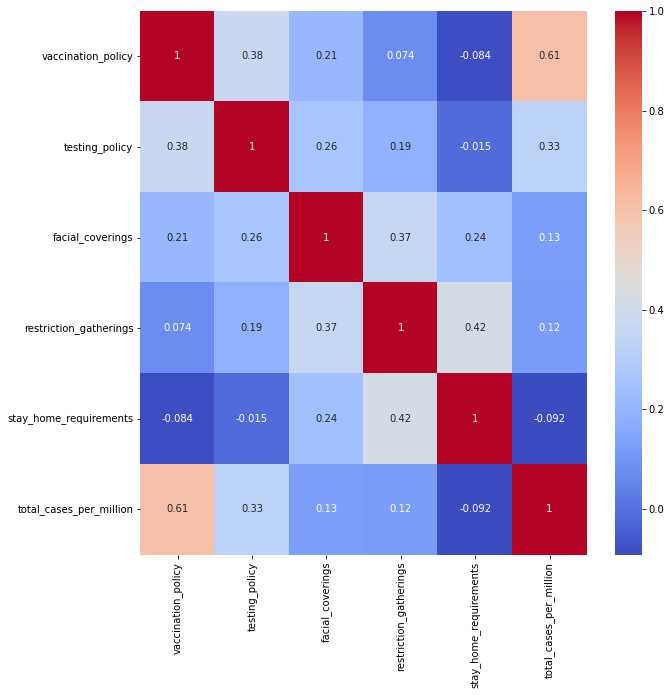

stay_home_requirements
restriction_gatherings                 0.415994
facial_coverings                       0.241725
testing_policy                        -0.015480
vaccination_policy                    -0.084455
total_cases_per_million               -0.092445

In [ ]:
df_drop_cases = df.drop(['total_cases_per_million'], axis=1)
df_correlation = determine_correlation(df, "stay_home_requirements")
plot_correlation_heatmaps(df, figsize=(10, 10), annot=True)
df_correlation

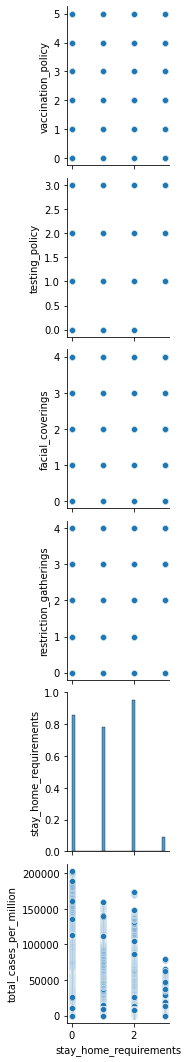

In [ ]:
# Plot predictor variables against total deaths per million
df_scatter = df.drop(labels=['iso_code', 'date'], axis=1)
sns.pairplot(data=df_scatter, x_vars=['stay_home_requirements'])

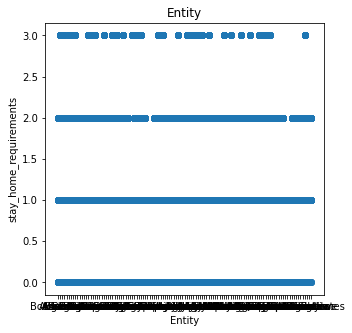

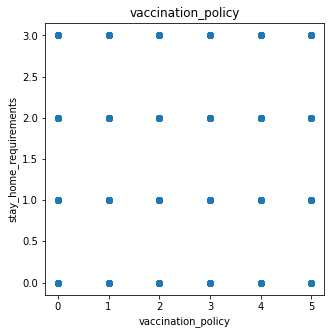

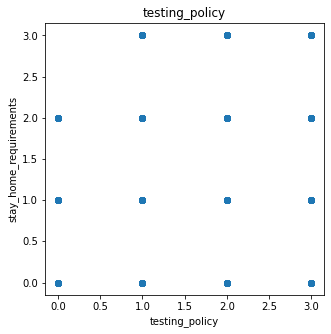

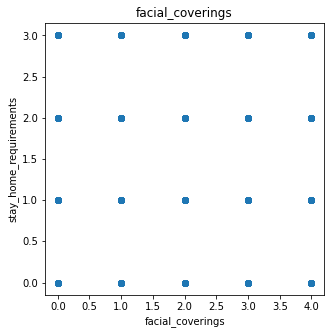

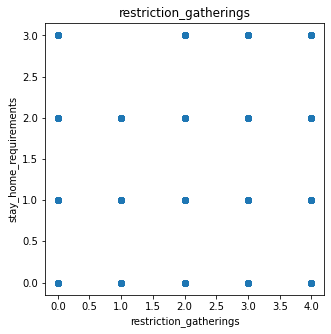

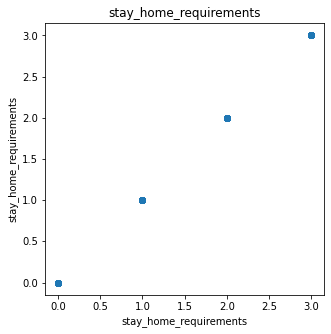

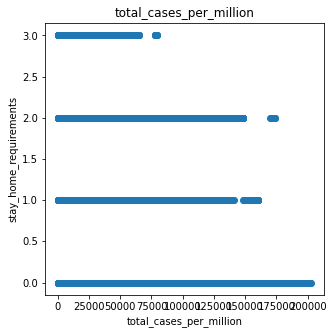

In [ ]:
for col in df_scatter.columns:
  plt.figure(figsize=(5,5))
  plt.xlabel(col)
  plt.ylabel("stay_home_requirements")
  plt.title(col)
  plt.scatter(df[col], df["stay_home_requirements"])
  plt.show() 

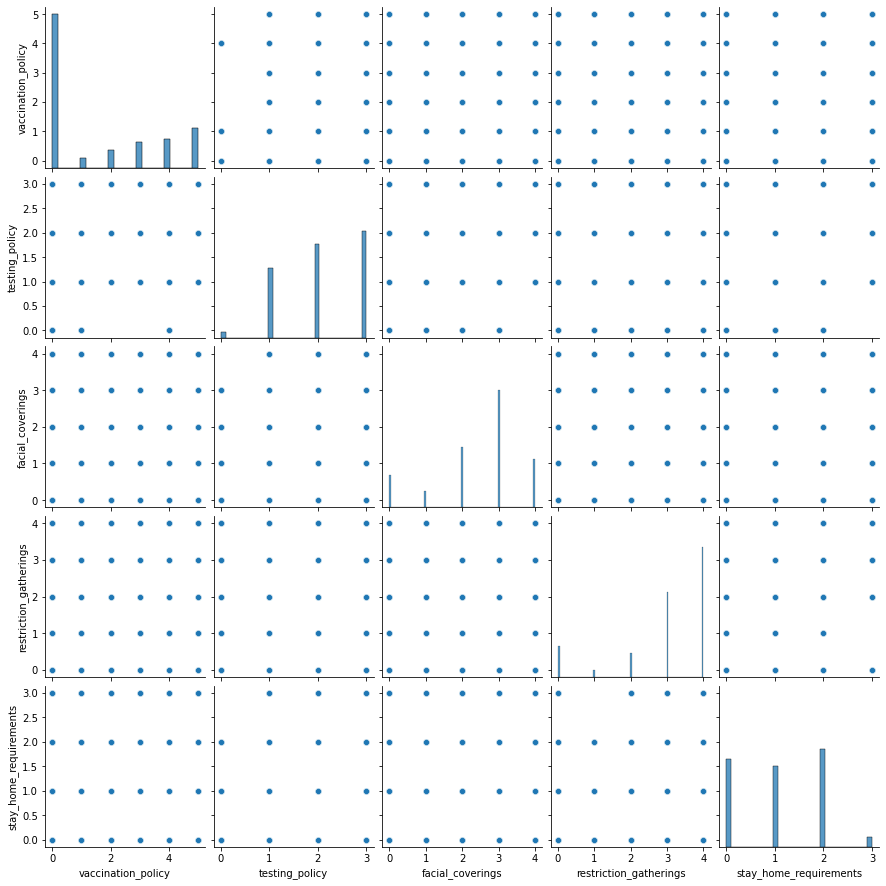

In [ ]:
sns.pairplot(data=df_drop_cases)

Predictor Variables (X)

Variable (X) | Description | Grouped By
-------------------|------------------ | ------------------
testing_policy | Government policies on PCR testing for COVID-19 | No testing policy, Testing only for those who both (a) have symptoms AND (b) meet specific criteria (e.g. key workers, admitted to hospital, came into contact with a known case, returned from overseas), Testing of anyone showing COVID-19 symptoms, Open public testing (e.g “drive through” testing available to asymptomatic people)
vaccination_policy | Policies on the availability of vaccinations | No availability, Availability for ONE of following: key workers/ clinically vulnerable groups/elderly groups, Availability for TWO of following: key workers/clinically vulnerable groups/elderly groups, Availability for ALL of following: key workers/clinically vulnerable groups/elderly groups, Availability for all three plus partial additional availability (select broad groups/ages), Universal availability
facial_coverings | Government policies on the use of face coverings outside-of-the-home | No policy, Recommended, Required in some specified shared/public spaces outside the home with other people present, or some situations when social distancing not possible, Required in all shared/public spaces outside the home with other people present or all situations when social distancing not possible, Required outside the home at all times regardless of location or presence of other people
restriction_gatherings | Government policies on restrictions on public gatherings | No restrictions, Restrictions on very large gatherings (the limit is above 1000 people), Restrictions on gatherings between 100 to 1000 people,Restrictions on gatherings between 10 to 100 people, Restrictions on gatherings of less than 10 people

Predicted Variable (y)

Variable (y) | Description | Category
-------------------|------------------ | ------------------
stay_home_requirements | Government policies on stay-at-home requirements or household lockdowns | No measures, Recommended not to leave the house, Required to not leave the house with exceptions for daily exercise, grocery shopping, and ‘essential’ trips, Required to not leave the house with minimal exceptions (e.g. allowed to leave only once every few days, or only one person can leave at a time, etc.)

In [ ]:
# Extract features and targets
features = ['testing_policy', 'vaccination_policy','facial_coverings', 'restriction_gatherings']
target = ['stay_home_requirements']
columns = features + target

df_features, df_target = get_features_targets(df_drop_cases.loc[:, columns].dropna(axis=0), features, target)

display(df_features.describe())
display(df_target.describe())

testing_policy  ...  restriction_gatherings
count    69716.000000  ...            69716.000000
mean         2.095774  ...                2.992541
std          0.841080  ...                1.295345
min          0.000000  ...                0.000000
25%          1.000000  ...                3.000000
50%          2.000000  ...                3.000000
75%          3.000000  ...                4.000000
max          3.000000  ...                4.000000

[8 rows x 4 columns]

stay_home_requirements
count            69716.000000
mean                 1.104352
std                  0.894346
min                  0.000000
25%                  0.000000
50%                  1.000000
75%                  2.000000
max                  3.000000

##### 2.4.2.2.2 Multiple Linear Regression

In [ ]:
# interpolation is done to eliminate the nan values
# df_features, df_target = get_features_targets(df_first_world_countries.interpolate(method='linear', axis=0, limit_direction='both'), features, target)
  
# multiple_linear_regression function returns the coefficients of linear regression
beta = multiple_linear_regression(df_features, df_target)
print(beta)

R^2 Score:  0.21225344192070672
Adjusted R^2 Score:  0.21217272356694006
Mean Square Error:  0.6270279563383553
Root Mean Squared Error:  0.7918509685151337
Mean Absolute Error:  0.6665570976527304
[[ 1.10706528]
 [-0.07528005]
 [-0.10102505]
 [ 0.12522986]
 [ 0.34782008]]


In [ ]:
for country in countries:
  print(country)
  df_features, df_target = get_features_targets(df[df['iso_code'] == country].dropna(axis=0), features, target)
  beta = multiple_linear_regression(df_features, df_target)

MRT
R^2 Score:  0.4429489244128083
Adjusted R^2 Score:  0.4362856340349711
Mean Square Error:  0.39784747311098895
Root Mean Squared Error:  0.6307515145530679
Mean Absolute Error:  0.5244936116093936
ETH
R^2 Score:  0.7783302806036659
Adjusted R^2 Score:  0.7756401141061376
Mean Square Error:  0.048981667654756256
Root Mean Squared Error:  0.2213180237910059
Mean Absolute Error:  0.11571511925069697
LBN
R^2 Score:  0.5562571025944953
Adjusted R^2 Score:  0.5511330506614063
Mean Square Error:  0.27703951889264716
Root Mean Squared Error:  0.5263454368498384
Mean Absolute Error:  0.352421216668597
BIH
R^2 Score:  0.45243374331475095
Adjusted R^2 Score:  0.44597659406138723
Mean Square Error:  0.6494586071435746
Root Mean Squared Error:  0.8058899472903075
Mean Absolute Error:  0.6901743489656451
CHN
R^2 Score:  0.11463327149456182
Adjusted R^2 Score:  0.1048825365991275
Mean Square Error:  0.6886920765833228
Root Mean Squared Error:  0.8298747354771819
Mean Absolute Error:  0.6892529202

ZeroDivisionError: ignored

Metric | Before removing | After removing | Increase/Decrease
------------------- | -------------------|------------------ | ------------------
R^2 Score | 0.3948836899623418 | 0.21250467850219978 | Decrease
Adjusted R^2 Score | 0.3948305614268238 | 0.21244819483260446 | Decrease
SSᵣ | 13673938089285.852 | 13109.480328904656 | Decrease
SSₜ | 22597206293175.08 | 16647.05804724108 | Decrease
Mean Square Error | 666923771.6083428 | 0.6268279778571606 | Decrease
Root Mean Square Error | 25824.867310566045 | 0.7917246856434127 | Decrease
Mean Absolute Error | 16872.56397313734 | 0.6658660407148005 | Decrease
Mean Square Log Error | NaN | 0.1843025648017881 | NIL
Root Mean Square Log Error| NaN | 0.42930474584121253 | NIL

We made our hypothesis by looking at whether changes in one policy will affect the stay home requirement policies. We did this by seeing the effect of one policy on the general public and then using this result to see whether stay home requirement policies could be slacken or stricter. However this may not be the case in real life. 

For example, governments may still impose strict stay home requirement policies despite the ability for it to be slackened so that they can more effectively curb the spread of the virus. So instead of slacking the stay home requirement policies, as what we would had expected, it ended up remaining as strict or possibly more. 

By not having this thought process when coming up with our hypothesis, our expected relationships between the other policies and the stay home requirement policies may not actually be applied to the real world. Hence, out correlation values would potentially be lower, signalling a weaker relationship between the other policies and the stay home requirement policies.

#### 2.4.2.3 Improvement 2: k-fold Cross Validation
Evaluating our model performance above, we noted that our scores are rather low for most metrics, possibly meaning a good performance.

Validation is very important to machine learning as there is a need to validate the stability of the learning model and how well it will adapt to new data or in a practical scenario [1]. Cross-validation allows us to be sure that the model is actually picking up patterns from the data and not the inherent noise from the data, ensuring the quality of the model [1].

The goal of cross-validation is to define a dataset to test the model in the training phase (i.e. a validation dataset) in order to limit problems like overfitting and underfitting, and to get an insight on how the model will generalize to an independent dataset [1]. It is important that the
validation and the training set should be drawn from the same distribution. Otherwise, it would make things worse [1].

In typical validation methods, the dataset will be split into 2 sets, a training set and a test set. These 2 sets of data do not overlap and contain different data. The training set will be used to train the model and test set will be used to test the model and determine the accuracy of the model. However, if the split made is not random (e.g. if one subset of our data has only people from a certain state, employees with a certain income level but not other income levels, only women or only people at a certain age), overfitting will occur. This is due to the fact that it is not certain which data points will end up in the validation set and the result might be entirely different for different sets [1].

Overfitting usually occurs when the model learns the parameters of a prediction function and tests it on the same data. A model that repeats the labels of the samples which it has just seen would have a perfect score, but would fail to
predict anything useful on yet-unseen data. 

In our case, to tackle overfitting, we have employed the use of k-fold cross validation. It does this by first splitting the data into k groups. The algorithm is then trained and evaluated k times and the performance summarized by taking the mean performance score. Each group of data is called a fold, hence the name k-fold cross-validation.

It works by first training the algorithm on the k-1 groups of the data and evaluating it on the kth hold-out group as the test set. This is repeated so that each of the k groups is given an opportunity to be held out and used as the test set. As such, the value of k should be divisible by the number of rows in your training dataset, to ensure each of the k groups has the same number of rows. A visualisation of k-fold Cross Validation is seen below.
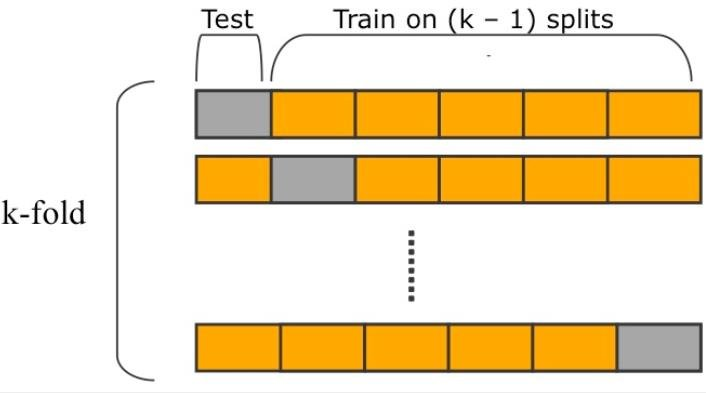

Sources:
1. G. Drakos, “Cross-Validation,” Towards Data Science, 16-Aug-2018. [Online]. Available:
https://towardsdatascience.com/cross-validation-70289113a072.

In [ ]:
def multiple_linear_regression(df_features_train, df_target_train, df_features_test, df_target_test):
  # Normalize the features using z normalization
  df_features_train_z = normalize_z(df_features_train)

  # Change the features and the target to numpy array using the prepare functions
  X = prepare_feature(df_features_train_z)
  target = prepare_target(df_target_train)

  iterations = 1500
  alpha = 0.1
  beta = np.zeros((X.shape[1], 1), dtype=float)

  # Call the gradient_descent function
  beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
  
  # call the predict() method
  pred = predict(df_features_test, beta)

  # Plotting figures for visualisation
  plt.figure()
  plt.title("J_storage")
  plt.plot(J_storage)
  for column in df_features_test.columns:
    plt.figure()
    plt.xlabel(column)
    plt.ylabel("stay_home_requirements")
    plt.scatter(df_features_test[column], np.array(df_target_test), color='blue')
    plt.scatter(df_features_test[column], pred, color='orange')
    plt.show()

  # Change target test set to a numpy array
  target = df_target_test.to_numpy()

  # Calculate R^2, Adjusted R^2, SS, MSE, RMSE, MAE, MSLE, RMSLE
  print("R^2 Score: ", r2_score(target, pred))
  print("Adjusted R^2 Score: ", adjusted_r2_score(r2_score(target, pred), X.shape[0], X.shape[1]))
  print("SSᵣ (sum of the square of residuals): ", ss_score(target, pred)[0])
  print("SSₜ (total sum of errors if we take the mean of the observed values as the predicted value): ", ss_score(target, pred)[1])
  print("Mean Square Error: ", mean_squared_error(target, pred))
  print("Root Mean Squared Error: ", root_mean_squared_error(target, pred))
  print("Mean Absolute Error: ", mean_absolute_error(target, pred))
  print("Mean Squared Log Error: ", mean_squared_log_error(target, pred))
  print("Root Mean Squared Log Error: ", root_mean_squared_log_error(target, pred))

  return beta, r2_score(target, pred), adjusted_r2_score(r2_score(target, pred), X.shape[0], X.shape[1]), ss_score(target, pred)[0], ss_score(target, pred)[1], mean_squared_error(target, pred), root_mean_squared_error(target, pred), mean_absolute_error(target, pred), mean_squared_log_error(target, pred), root_mean_squared_log_error(target, pred)

In [ ]:
# Extract features and targets
features = ['testing_policy', 'vaccination_policy','facial_coverings', 'restriction_gatherings', 'stay_home_requirements']
target = ['total_cases_per_million']
columns = features + target

df_features, df_target = get_features_targets(df.loc[:, columns].dropna(axis=0), features, target)

display(df_features.describe())
display(df_target.describe())

testing_policy  ...  stay_home_requirements
count    68345.000000  ...            68345.000000
mean         2.091053  ...                1.116951
std          0.834485  ...                0.893945
min          0.000000  ...                0.000000
25%          1.000000  ...                0.000000
50%          2.000000  ...                1.000000
75%          3.000000  ...                2.000000
max          3.000000  ...                3.000000

[8 rows x 5 columns]

total_cases_per_million
count             68345.000000
mean              21353.319636
std               33236.145521
min                   0.001000
25%                 477.067000
50%                4499.892000
75%               28553.248000
max              203027.639000

k-fold Cross Validation Iteration  1


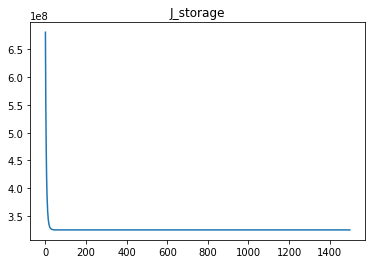

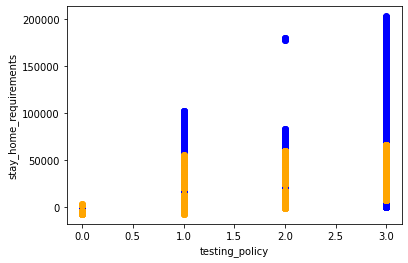

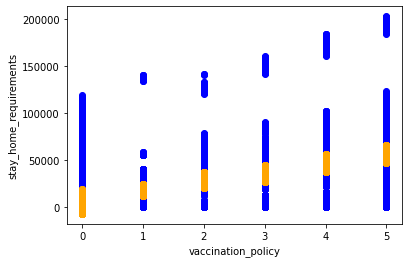

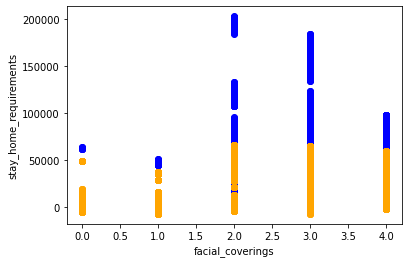

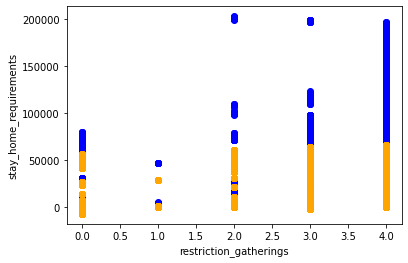

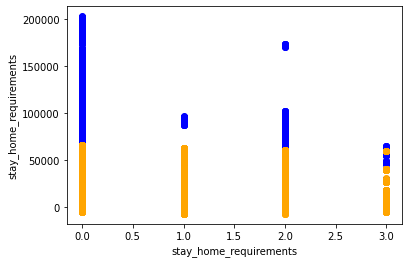

R^2 Score:  0.32014326602048027
Adjusted R^2 Score:  0.32006865078325486
SSᵣ (sum of the square of residuals):  10671221170172.469
SSₜ (total sum of errors if we take the mean of the observed values as the predicted value):  15696279284767.564
Mean Square Error:  780687773.0757531
Root Mean Squared Error:  27940.790487667902
Mean Absolute Error:  17139.331175469364
Mean Squared Log Error:  nan
Root Mean Squared Log Error:  nan


k-fold Cross Validation Iteration  2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log


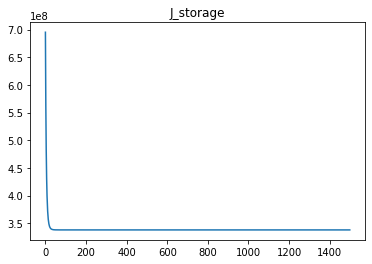

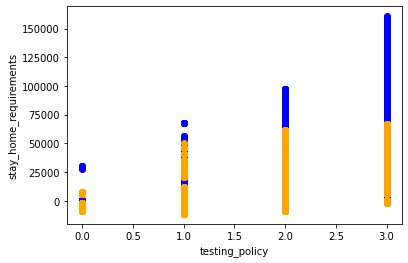

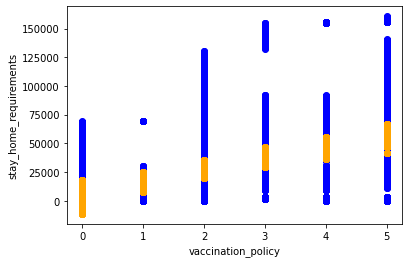

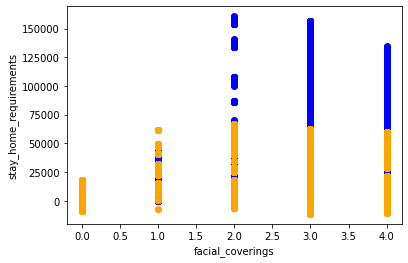

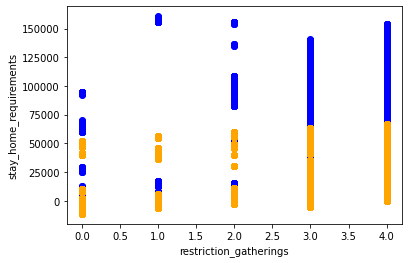

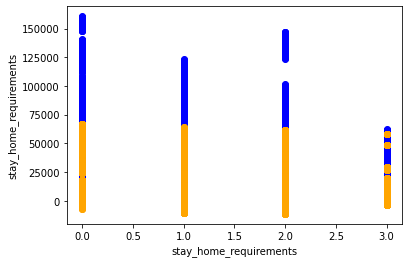

R^2 Score:  0.3544163125790485
Adjusted R^2 Score:  0.3543454588571123
SSᵣ (sum of the square of residuals):  9321924148280.309
SSₜ (total sum of errors if we take the mean of the observed values as the predicted value):  14439528646581.13
Mean Square Error:  681975575.9953405
Root Mean Squared Error:  26114.66208847705
Mean Absolute Error:  17322.528292458574
Mean Squared Log Error:  nan
Root Mean Squared Log Error:  nan


k-fold Cross Validation Iteration  3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log


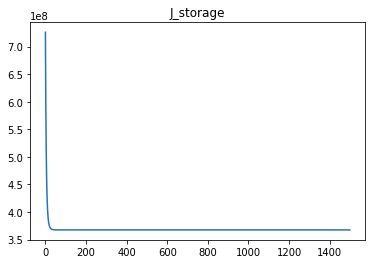

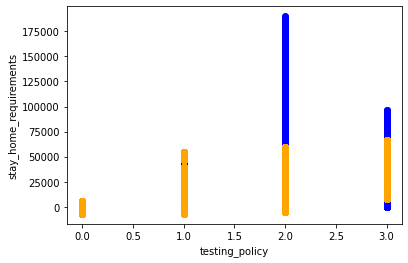

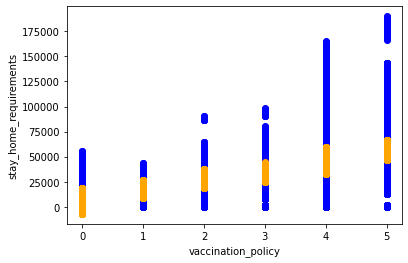

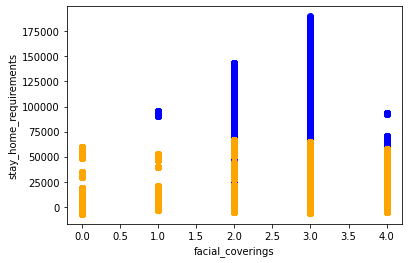

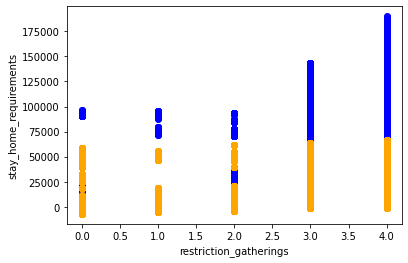

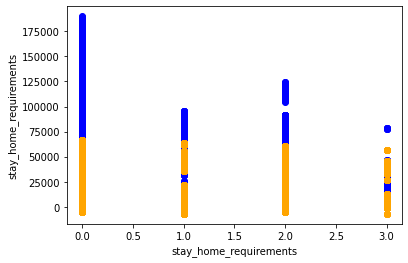

R^2 Score:  0.46300380077413794
Adjusted R^2 Score:  0.46294486468247076
SSᵣ (sum of the square of residuals):  6053422763674.575
SSₜ (total sum of errors if we take the mean of the observed values as the predicted value):  11272747874940.71
Mean Square Error:  442857763.0898073
Root Mean Squared Error:  21044.185968808753
Mean Absolute Error:  14029.02518705132
Mean Squared Log Error:  nan
Root Mean Squared Log Error:  nan


k-fold Cross Validation Iteration  4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log


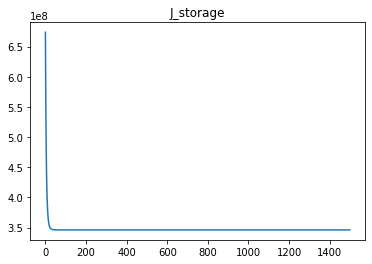

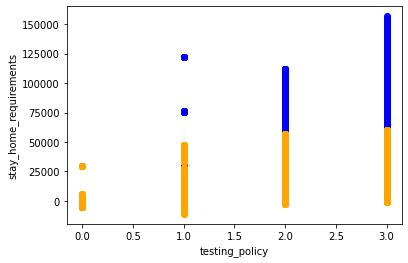

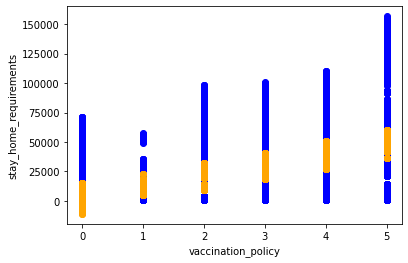

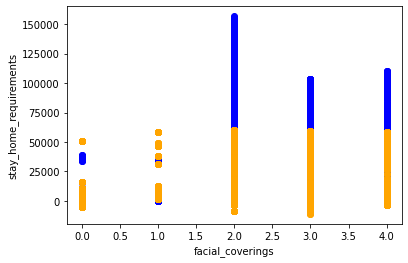

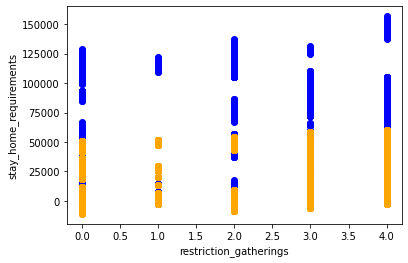

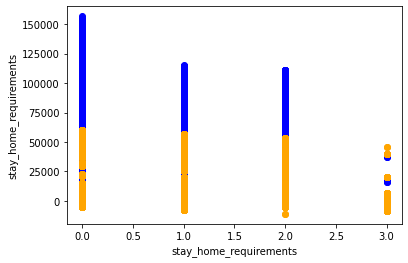

R^2 Score:  0.43770499656519946
Adjusted R^2 Score:  0.43764328389402185
SSᵣ (sum of the square of residuals):  8522493472373.028
SSₜ (total sum of errors if we take the mean of the observed values as the predicted value):  15156623160997.432
Mean Square Error:  623490633.723976
Root Mean Squared Error:  24969.79442694665
Mean Absolute Error:  17018.342410434077
Mean Squared Log Error:  nan
Root Mean Squared Log Error:  nan


k-fold Cross Validation Iteration  5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log


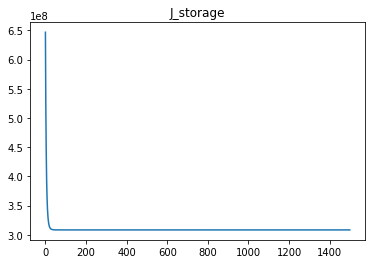

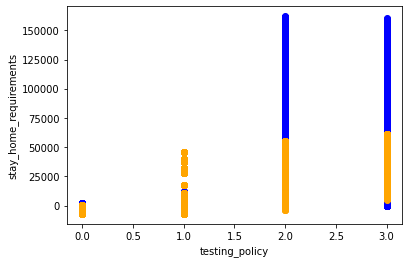

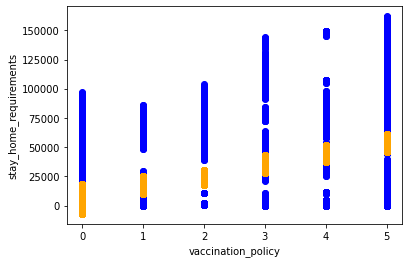

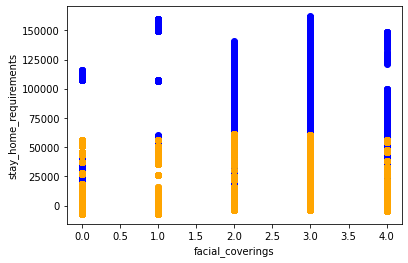

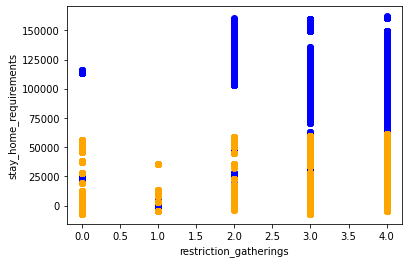

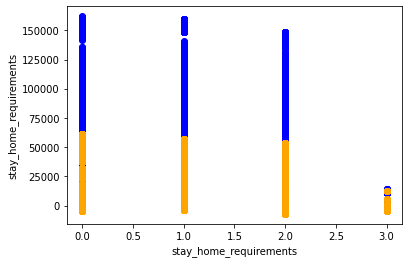

R^2 Score:  0.32291288302279153
Adjusted R^2 Score:  0.3228385717549458
SSᵣ (sum of the square of residuals):  12678378875019.498
SSₜ (total sum of errors if we take the mean of the observed values as the predicted value):  18724885701002.44
Mean Square Error:  927527900.725693
Root Mean Squared Error:  30455.342728751108
Mean Absolute Error:  20342.10627853888
Mean Squared Log Error:  nan
Root Mean Squared Log Error:  nan


Average R^2 Score:  0.3796362517923315
Average Adjusted R^2 Score:  0.3795681659943611
Average SSᵣ:  9449488085903.975
Average SSₜ:  15058012933657.855
Average Mean Square Error:  691307929.322114
Average Root Mean Squared Error:  26104.955140130292
Average Mean Absolute Error:  17170.266668790442
Average Mean Squared Log Error:  nan
Average Root Mean Squared Log Error:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log


In [ ]:
from sklearn.model_selection import KFold

k = 5
kf = KFold(n_splits=k, random_state=None)
i = 1

r2s = []
adjusted_r2s = []
ssrs = []
ssts = []
mses = []
rmses = []
maes = []
msles = []
rmsles = []

for train_index, test_index in kf.split(df_features):
  df_features_train = df_features.iloc[train_index, :]
  df_features_test = df_features.iloc[test_index, :]
  df_target_train = df_target.iloc[train_index, :]
  df_target_test = df_target.iloc[test_index, :]
  print("k-fold Cross Validation Iteration ", i)
  i += 1
  beta, r2, adjusted_r2, ssr, sst, mse, rmse, mae, msle, rmsle = multiple_linear_regression(df_features_train, df_target_train, df_features_test, df_target_test)
  print("\n")

  r2s.append(r2)
  adjusted_r2s.append(adjusted_r2)
  ssrs.append(ssr)
  ssts.append(sst)
  mses.append(mse)
  rmses.append(rmse)
  maes.append(mae)
  msles.append(msle)
  rmsles.append(rmsle)

print("Average R^2 Score: ", sum(r2s) / len(r2s))
print("Average Adjusted R^2 Score: ", sum(adjusted_r2s) / len(adjusted_r2s))
print("Average SSᵣ: ", sum(ssrs) / len(ssrs))
print("Average SSₜ: ", sum(ssts) / len(ssts))
print("Average Mean Square Error: ", sum(mses) / len(mses))
print("Average Root Mean Squared Error: ", sum(rmses) / len(rmses))
print("Average Mean Absolute Error: ", sum(maes) / len(maes))
print("Average Mean Squared Log Error: ", sum(msles) / len(msles))
print("Average Root Mean Squared Log Error: ", sum(rmsles) / len(rmsles))

Metric | Without k-fold CV | With k-fold CV (Average) | Increase/Decrease
------------------- | -------------------|------------------ | ------------------
R^2 Score | 0.3948836899623418 | 0.3796362517923315 | Decrease
Adjusted R^2 Score | 0.3948305614268238 | 0.3795681659943611 | Decrease
SSᵣ | 13673938089285.852 | 9449488085903.975 | Decrease
SSₜ | 22597206293175.08 | 15058012933657.855 | Decrease
Mean Square Error | 666923771.6083428 | 691307929.322114 | Increase
Root Mean Square Error | 25824.867310566045 | 26104.955140130292 | Increase
Mean Absolute Error | 16872.56397313734 | 17170.266668790442 | Increase
Mean Square Log Error | NaN | NaN | NIL
Root Mean Square Log Error| NaN | NaN | NIL

From this, we see that the values which were expected to increase actually decreased, while the values which were expected to decrease actually increased. However, it is key to take note that this was from an average of 5 folds from k-fold Cross Validation. 


# Code Archive

## 1.4 Multiple Linear Regression Model

### 1.4.1 Visualisation and Plots

For visualisation of the data, we made use of Matplotlib and Seaborn that were introduced to us in class and the [pre-class material](https://github.com/Data-Driven-World/d2w_notes/blob/master/Visualization.ipynb). 

As the code for visualisation was repeated over the course of this report, we decided to insert them as functions for easy usage in the other cells. 

For any data that required preprocessing or further DataFrame analysis, we made use of codes from the cohort lessons and [pre-class material](https://github.com/Data-Driven-World/d2w_notes/blob/master/Working_With_Data.ipynb). 

In [ ]:
def determine_correlation(df, column_name): 
  """Takes a DataFrame and a column name, return a DataFrame containing the correlation score between the column that matches the given name and all other columns."""
  pd.set_option('display.max_rows', None)
  correlations = df.corr()
  df_correlation = pd.DataFrame(correlations.loc[:, [column_name]])
  return df_correlation[[column_name]].sort_values(by=column_name, ascending=False)[1:]

def plot_correlation_heatmaps(df, figsize, annot=False):
  """Takes a DataFrame, the figsize of the heatmap to be plotted, and whether the heatmap should be annotated (default False), returns nothing."""
  correlations = df.corr()
  plt.figure(figsize=figsize)
  sns.heatmap(correlations, cmap="coolwarm", annot=annot)
  plt.show()

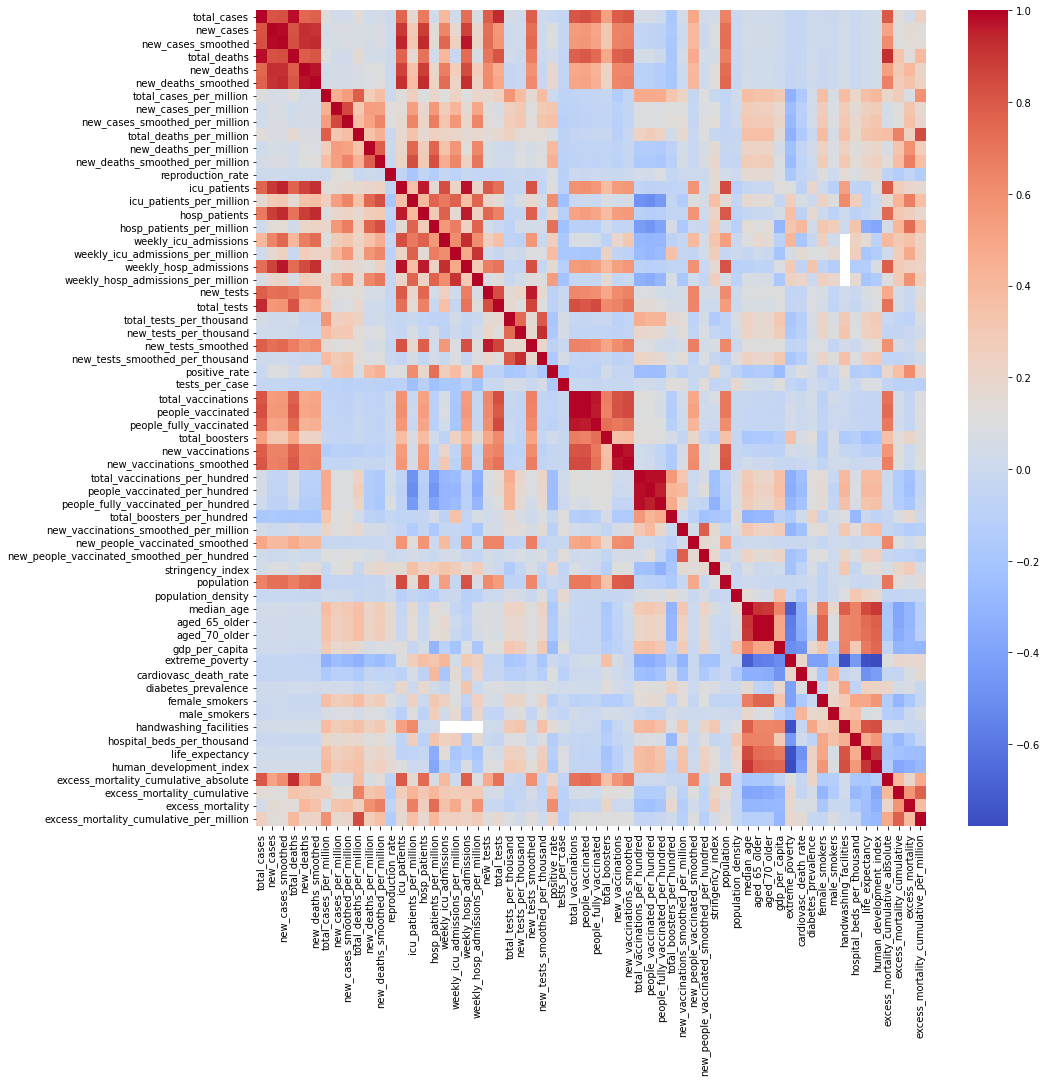

total_deaths_per_million
excess_mortality_cumulative_per_million                     0.845685
total_cases_per_million                                     0.779900
excess_mortality_cumulative                                 0.654311
new_deaths_smoothed_per_million                             0.451295
female_smokers                                              0.380784
excess_mortality_cumulative_absolute                        0.374115
new_cases_smoothed_per_million                              0.369461
aged_70_older                                               0.366685
aged_65_older                                               0.366193
median_age                                                  0.359255
handwashing_facilities                                      0.357421
human_development_index                                     0.351494
new_deaths_per_million                                      0.344724
icu_patients_per_million                                    0.343604
life_expectancy                                             0.333117
new_cases_per_million                                       0.313746
people_vaccinated_per_hundred                               0.265706
hosp_patients_per_million                                   0.246741
excess_mortality                                            0.246557
total_tests_per_thousand                                    0.235628
total_vaccinations_per_hundred                              0.232414
people_fully_vaccinated_per_hundred                         0.223992
weekly_icu_admissions                                       0.219030
weekly_icu_admissions_per_million                           0.201622
weekly_hosp_admissions_per_million                          0.186992
total_tests                                                 0.182530
new_vaccinations_smoothed_per_million                       0.179610
icu_patients                                                0.178673
hospital_beds_per_thousand                                  0.176757
hosp_patients                                               0.170100
weekly_hosp_admissions                                      0.165141
gdp_per_capita                                              0.163164
total_deaths                                                0.162155
new_tests                                                   0.152718
new_tests_per_thousand                                      0.150239
new_tests_smoothed_per_thousand                             0.149223
new_tests_smoothed                                          0.146237
total_cases                                                 0.137676
new_people_vaccinated_smoothed_per_hundred                  0.109047
new_deaths_smoothed                                         0.081787
new_cases_smoothed                                          0.080730
new_cases                                                   0.078853
new_deaths                                                  0.078068
positive_rate                                               0.071841
male_smokers                                                0.059929
total_boosters_per_hundred                                  0.033942
diabetes_prevalence                                        -0.008049
reproduction_rate                                          -0.008613
new_people_vaccinated_smoothed                             -0.014397
new_vaccinations_smoothed                                  -0.023057
stringency_index                                           -0.023736
people_fully_vaccinated                                    -0.024750
total_boosters                                             -0.026179
people_vaccinated                                          -0.030424
population_density                                         -0.034644
population                                                 -0.041882
total_vaccinations                                         -0.043435
tests_per_case                            

In [ ]:
df_correlation = determine_correlation(df, "total_deaths_per_million")
plot_correlation_heatmaps(df, figsize=(15, 15), annot=False)
df_correlation

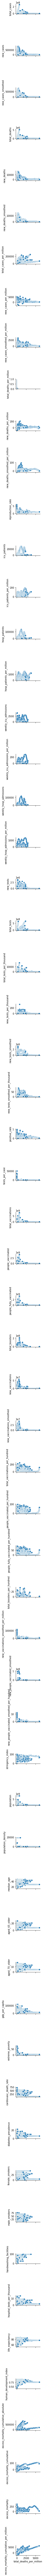

In [ ]:
# Plot predictor variables against total deaths per million
df_scatter = df.drop(labels=['iso_code', 'continent', 'location', 'date', 'tests_units'], axis=1)
sns.pairplot(data=df_scatter, x_vars=['total_deaths_per_million'])

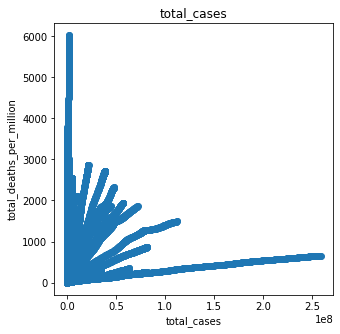

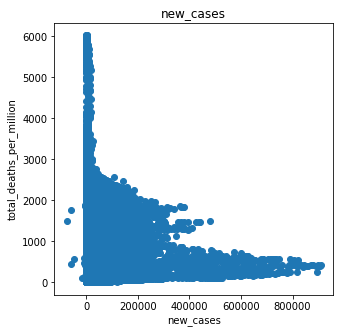

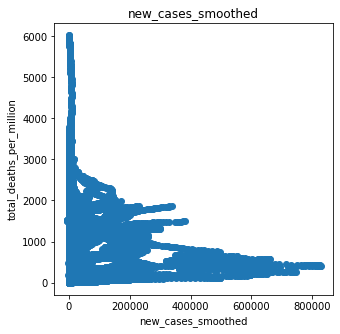

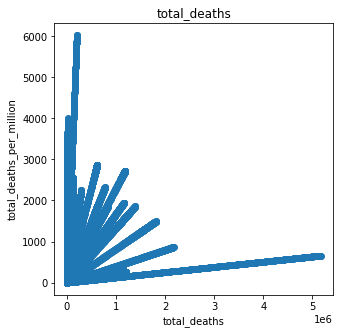

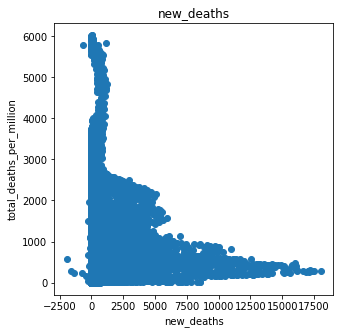

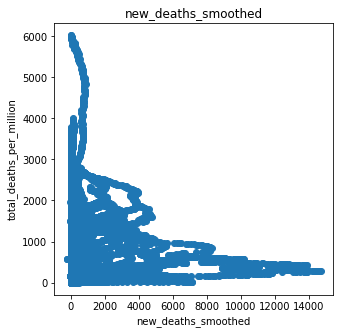

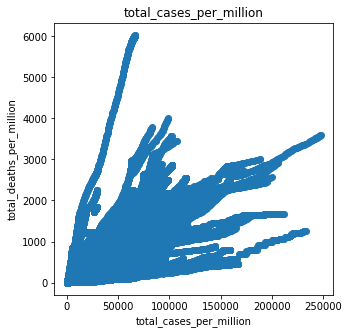

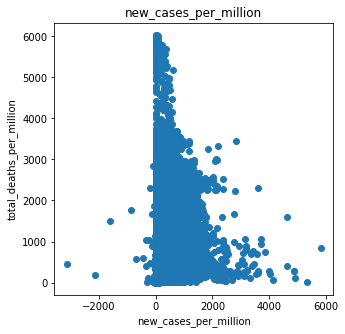

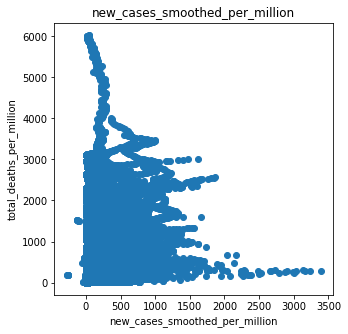

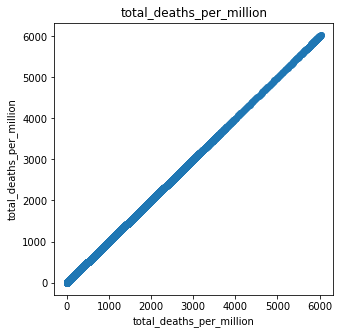

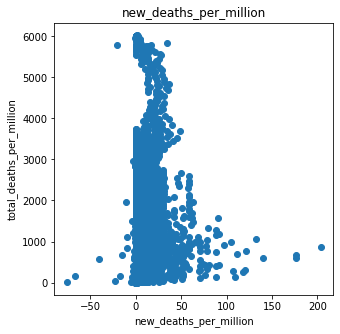

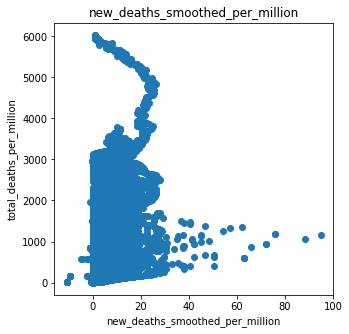

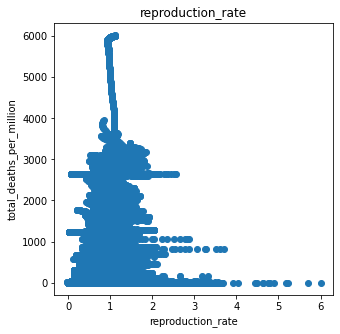

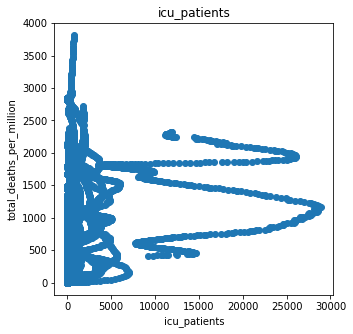

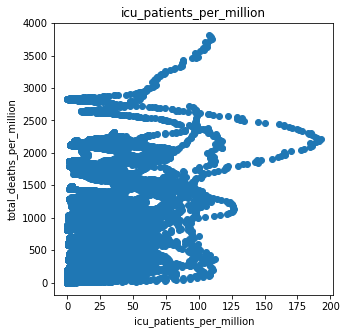

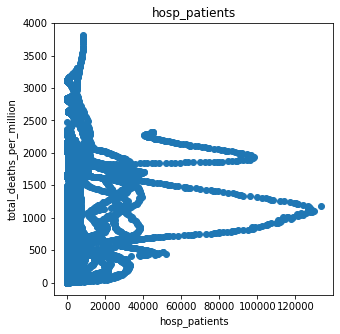

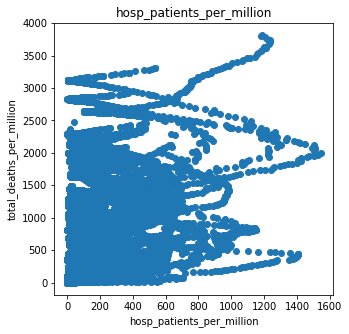

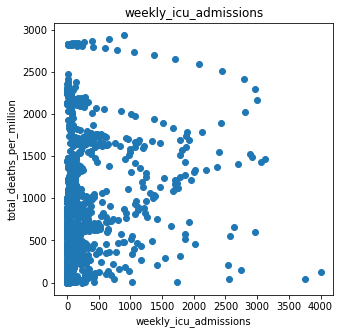

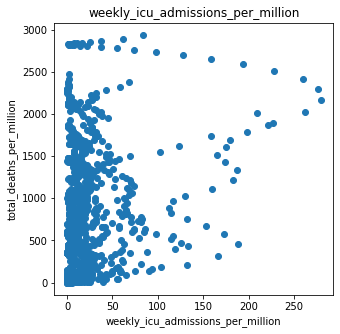

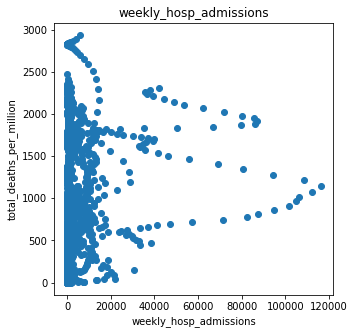

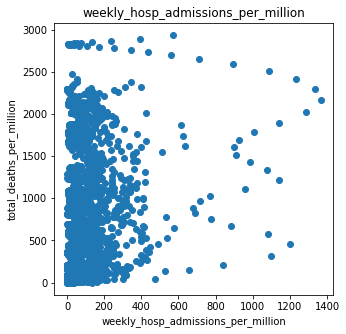

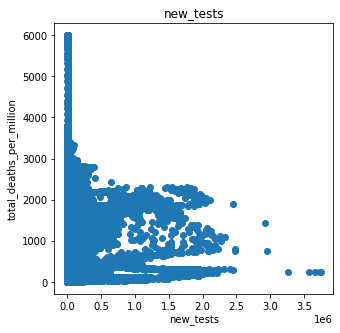

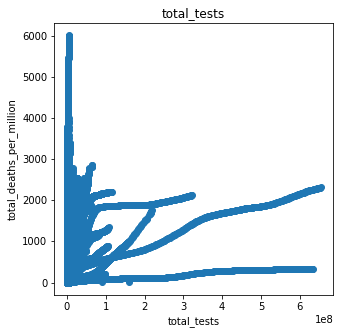

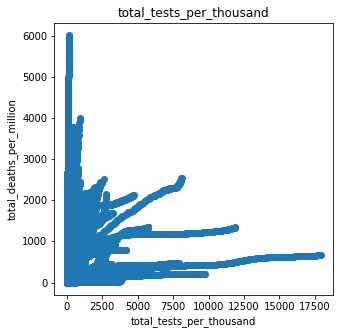

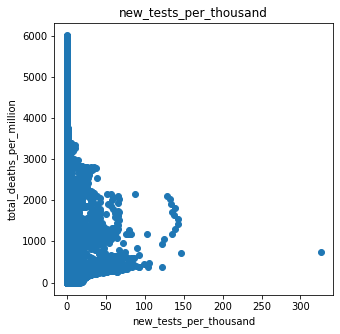

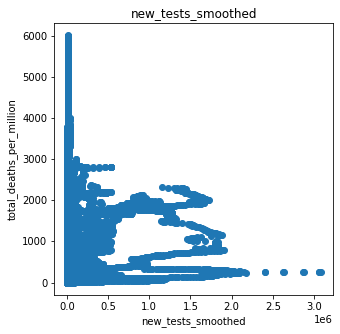

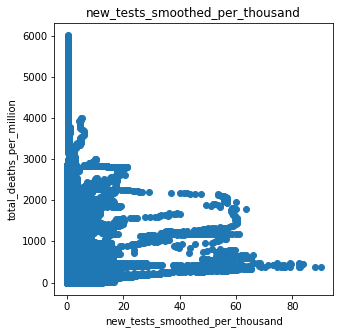

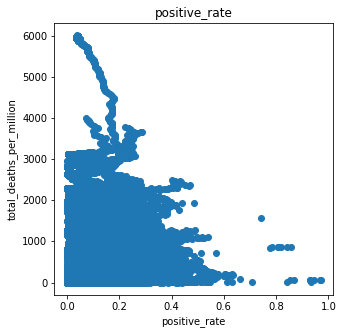

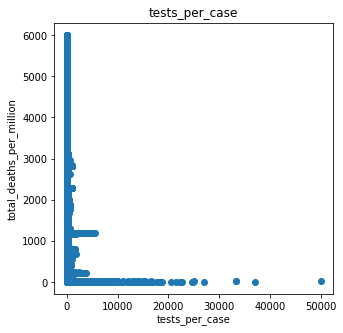

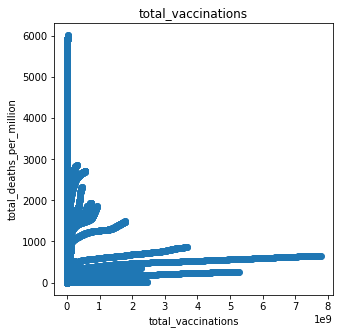

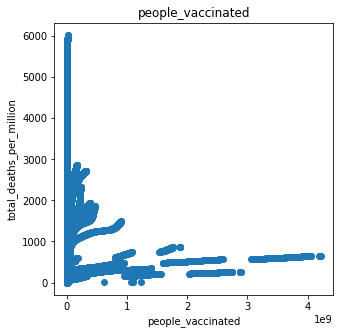

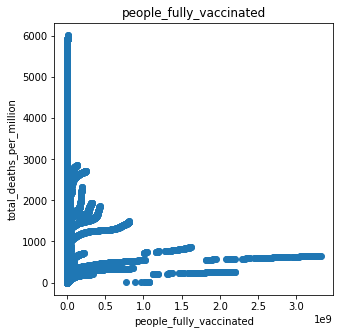

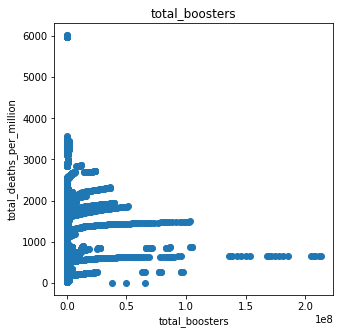

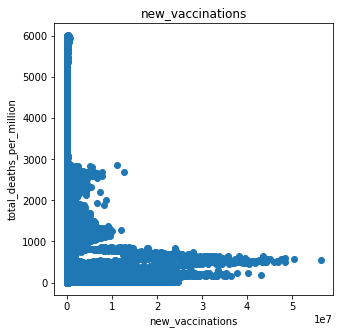

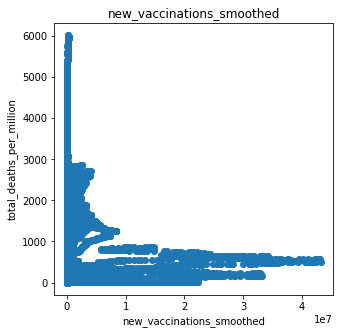

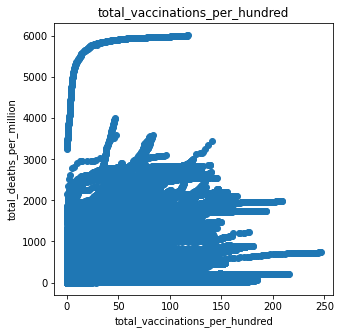

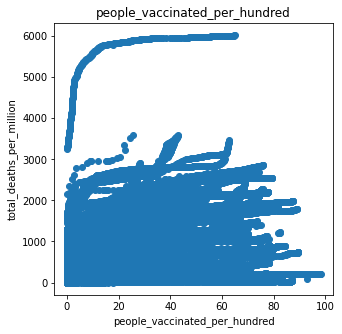

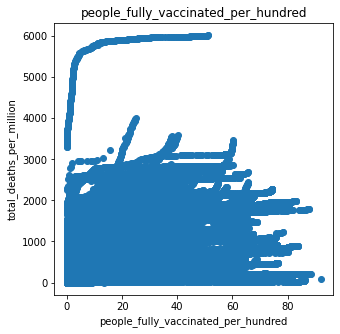

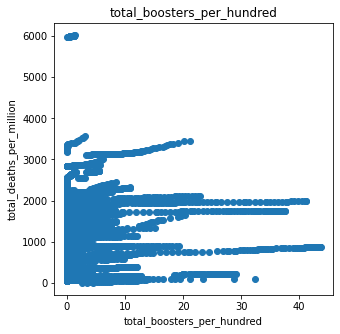

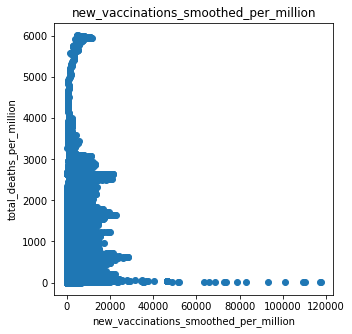

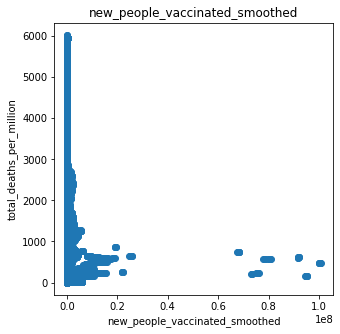

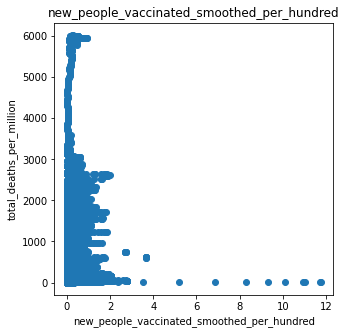

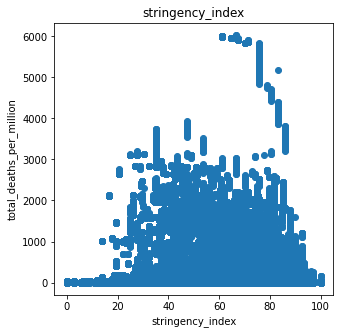

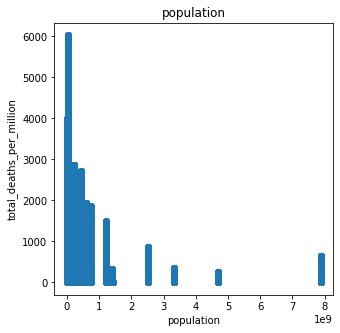

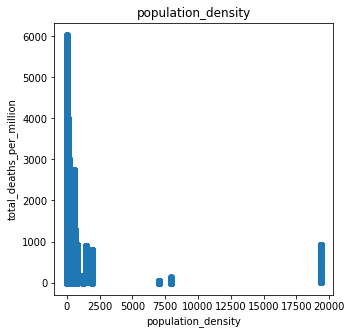

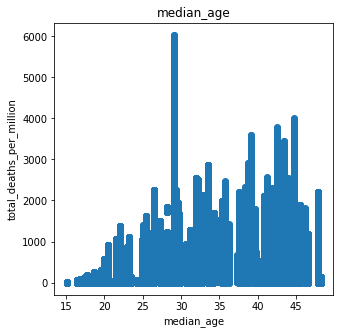

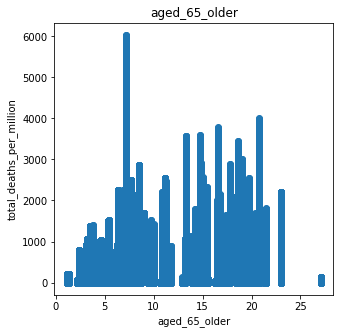

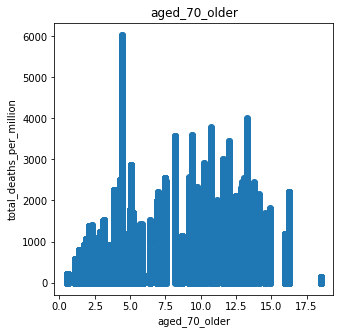

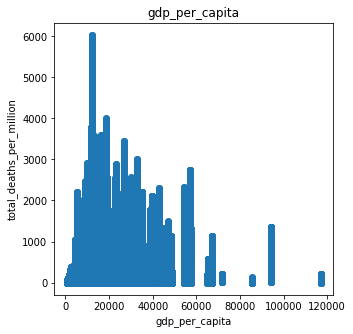

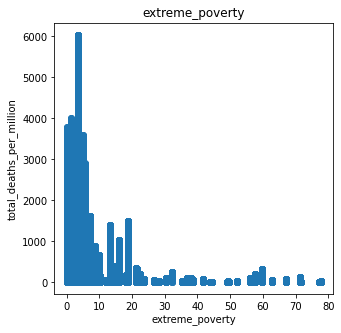

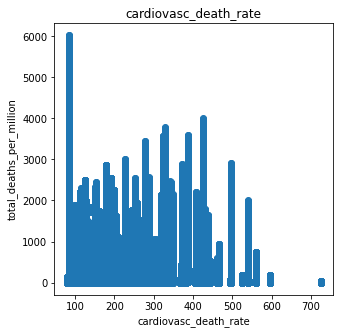

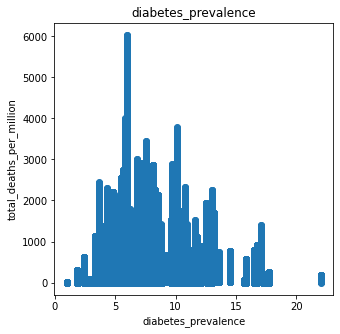

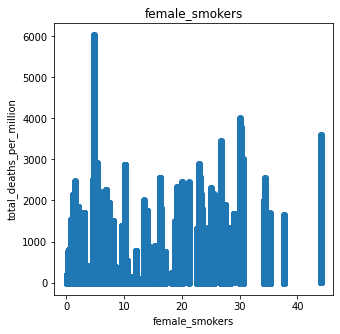

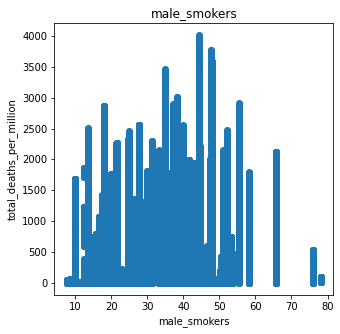

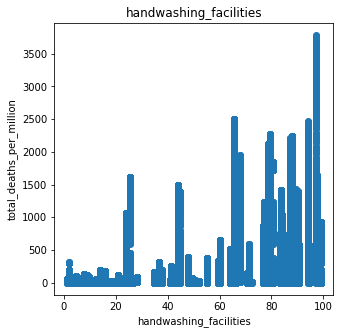

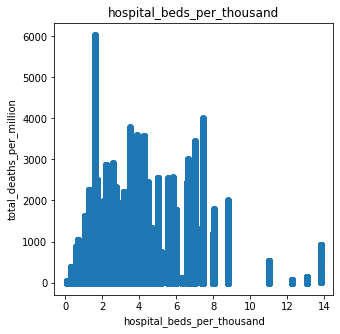

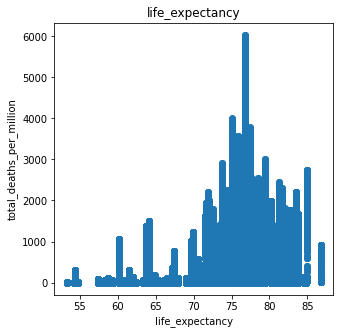

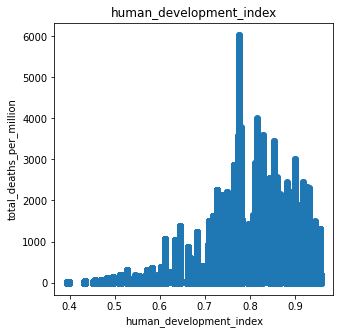

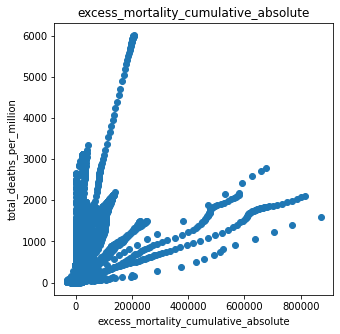

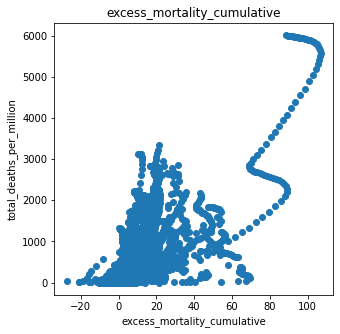

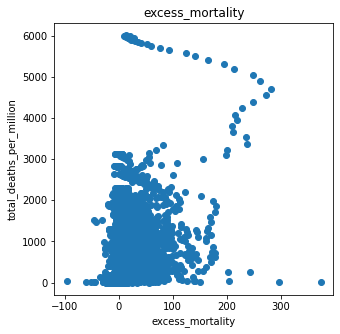

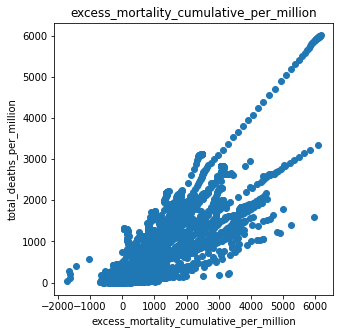

In [ ]:
for col in df_scatter.columns:
  plt.figure(figsize=(5,5))
  plt.xlabel(col)
  plt.ylabel("total_deaths_per_million")
  plt.title(col)
  plt.scatter(df[col], df["total_deaths_per_million"])
  plt.show() 

Based on our analysis above, we narrowed down to 10 different predictor variables to be used for our Multiple Linear Regression model. The predictor variables, the relevant descriptions, and metrics (mentioned in Section 1.1 above)

**Predictor Variables (X)**

Variable (X) | Description | Metrics (from OWID)
-------------------|------------------ | ------------------
total_cases_per_million | Total confirmed cases of COVID-19 per 1,000,000 people | Confirmed cases
people_vaccinated_per_hundred      | Total number of people who received at least one vaccine dose per 100 people in the total population | Vaccinations
icu_patients | Number of COVID-19 patients in intensive care units (ICUs) on a given day | Hospital & ICU 
stringency_index | Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response) | Policy responses
aged_65_older | Share of the population that is 65 years and older, most recent year available | Others
aged_70_older | Share of the population that is 70 years and older in 2015 | Others
median_age | Median age of the population, UN projection for 2020 | Others
population_density | Number of people divided by land area, measured in square kilometers, most recent year available | Others
cardiovasc_death_rate | Death rate from cardiovascular disease in 2017 (annual number of deaths per 100,000 people) | Others
diabetes_prevalence | Diabetes prevalence (% of population aged 20 to 79) in 2017 | Others


**Predicted Variable (y)**

Variable (y) | Description | Category
-------------------|------------------ | ------------------
total_deaths_per_million | Total deaths attributed to COVID-19 per 1,000,000 people | Confirmed deaths

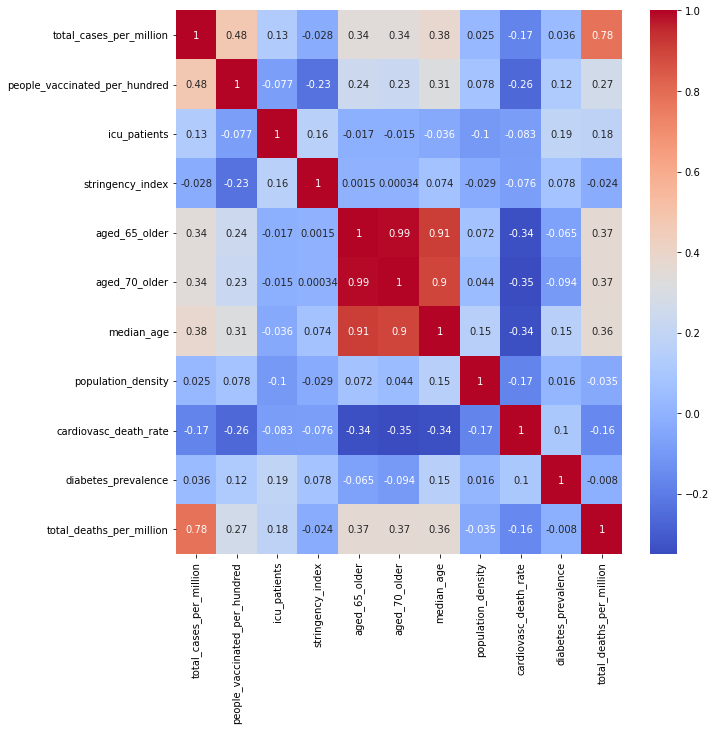

In [ ]:
features = ["total_cases_per_million", "people_vaccinated_per_hundred", "icu_patients", "stringency_index", "aged_65_older", "aged_70_older", "median_age", "population_density", "cardiovasc_death_rate", "diabetes_prevalence"]
target = ['total_deaths_per_million']
columns = features + target

df_features_target = df[columns]
plot_correlation_heatmaps(df_features_target, figsize=(10, 10), annot=True)

### 1.4.2 Helper Functions and Code for Model
In this section, we defined functions that were utilised in the model, taken from the cohort lessons and [pre-class material](https://github.com/Data-Driven-World/d2w_notes/blob/master/Multiple_Linear_Regression.ipynb).

In [ ]:
def normalize_z(df):
  """Takes a DataFrame, returns a DataFrame with normalized values using z-score normalization."""
  dfout = (df - df.mean(axis=0)) / df.std(axis=0)
  return dfout

def normalize_minmax(df):
  """Takes a DataFrame, returns a DataFrame with normalized values using min-max normalization."""
  dfout = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))
  return dfout

def transform_features(df_feature, colname, colname_transformed):
  """Takes a DataFrame, the name of a column to be transformed, and the name for the transformed column, returns a DataFrame with an additional column for the transformed data."""
  df_feature[colname_transformed] = df[colname].apply(lambda x: x**2)
  return df_feature

def get_features_targets(df, feature_names, target_names):
  """Takes a DataFrame, a list of columns for the features, and a list of columns for the target, returns a DataFrame containing the features and a DataFrame containing the target."""
  df_feature = df.loc[:, feature_names]
  df_target = df.loc[:, target_names]
  return df_feature, df_target

def prepare_feature(df_feature):
  """Takes a DataFrame containing the features, convert it into a numpy array, change it to a column vector, and add a column of '1's in the first column, returns a numpy.array containing the features."""
  cols = len(df_feature.columns)
  np_feature = df_feature.to_numpy().reshape(-1, cols)
  constants = np.ones(shape=(np_feature.shape[0], 1))
  return np.concatenate((constants, np_feature), axis=1)

def prepare_target(df_target):
  """Takes a DataFrame containing the target, convert it into a numpy array, change it to a column vector, returns a Numpy array containing the target."""
  cols = len(df_target.columns)
  np_target = df_target.to_numpy().reshape(-1, cols)
  return np_target

def predict(df_feature, beta):
  """Takes a DataFrame and an array of beta values, returns the predicted y values after z-normalization and conversion to a Numpy array."""
  df_feature = normalize_z(df_feature)
  np_X = prepare_feature(df_feature)
  return predict_norm(np_X, beta)

def predict_norm(X, beta):
  """Takes a Numpy array and an array of beta values, returns the straight line equation after standardization and adding of column for constant 1."""
  y_pred = np.matmul(X, beta)
  return y_pred
    
def split_data(df_feature, df_target, random_state=None, test_size=0.5):
  """Takes a DataFrame containing the features, a DataFrame containing the target, the seed used to split randomly, and the fraction used to split randomly (default 0.5), returns a tuple of 4 DataFrames containing the train and test sets for the features and target DataFrames."""
  # indexes = which is the number of rows
  indexes = df_feature.index
  if random_state != None:
      np.random.seed(random_state)

  # k = length / size of the test array
  k = int(test_size * len(indexes))

  test_index = np.random.choice(indexes, k, replace=False)
  train_index = list(set(indexes) - set(test_index))

  df_feature_train = df_feature.loc[train_index, :]
  df_feature_test = df_feature.loc[test_index, :]
  df_target_train = df_target.loc[train_index, :]
  df_target_test = df_target.loc[test_index, :]

  return df_feature_train, df_feature_test, df_target_train, df_target_test

In [ ]:
def compute_cost(X, y, beta):
  """Takes a Numpy array containing the features, a Numpy array containing the target, and beta coefficients at the end of the iteration, returns an array of computed cost function values."""
  J = 0
  m = X.shape[0]
  y_hat = np.matmul(X, beta)
  J = np.sum((y_hat - y) ** 2)/(2*m)
  error = np.matmul(X, beta) - y
  J = np.matmul(error.T, error)
  J = J / (2*m)
  return J

def gradient_descent(X, y, beta, alpha, num_iters):
  """Takes a Numpy array containing the features, a Numpy array containing the target, an array of beta values, the learning rate, the number of iterations to perform, returns the beta coefficient at the end of the iteration, and an array storing the cost value at each iteration."""
  # m = number of data points
  m = X.shape[0]

  # cost function in each iteration
  J = np.zeros((num_iters, 1)) 
  k = 0
  
  while k < num_iters:        
    y_hat = np.matmul(X, beta)
    deriv = np.matmul(X.T, (y_hat - y)) 
    beta = beta - alpha/m * deriv
    J[k] = compute_cost(X, y, beta)
    k += 1
  return beta, J

For accuracy metrics, we decided to look through the [scikit-learn Regression Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) site in order to find possible metrics we could use.  
As mentioned in the task brief, R^2 is not a good metric to be used for Multiple Linear Regression. As such, we decided to take into account the metric adjusted R^2, which will show us if the variables used were potentially overfitting our model.
* Adjusted R^2 Score: an improved version of R^2 score that penalizes us for adding an independent variable that does not help in predicting the dependent variable [1]
* Residual Sum of Squares: total square of the distance of actual points from the regression line, variation in the target variable that is not explained by our model. [2]
* Total Sum of Squares: sum of squares of the difference between the actual values and their mean, variance of Y [2]
* Mean Squared Error: tells you how close a regression line is to a set of points [3]
* Mean Absolute Error: average of all absolute errors [4]
* Root Mean Squared Error: the most common metric for regression models, follows an assumption that error are unbiased and follow a normal distribution [1] 
* Mean Squared Log Error: used when target, isnormally distributed and you don’t want large errors to be significantly more penalized than small ones, in those cases where the range of the target value is large [5]
* Root Mean Squared Log Error: penalizes the underestimation of the actual value more severely than it does for the overestimation [6]

Sources:
1. https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/
2. https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
3. https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/mean-squared-error/
4. https://www.statisticshowto.com/absolute-error/
5. https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/mean-squared-logarithmic-error-(msle)
6. https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a


In [ ]:
def r2_score(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns the r2 score."""
  res = np.sum((target - pred) ** 2)
  ymean = np.mean(target)
  tot = np.sum((target - ymean) ** 2)
  r2 = 1 - res/tot
  return r2

def adjusted_r2_score(R2, n, k):
  """Takes the R^2 score, number of data points, and number of features, returns the adjusted r2 score."""
  num = (1 - R2) * (n - 1)
  den = n - k - 1
  return 1 - num/den

def ss_score(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns a tuple of the sum of square of residuals and total sum of squares."""
  # sum of square of residuals
  res = np.sum((target - pred) ** 2)
  # total sum of squares
  ymean = np.mean(target)
  tot = np.sum((target - ymean) ** 2)
  return res, tot

def mean_squared_error(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns the mean squared error."""
  ysum = np.sum((target - pred) ** 2)
  n = target.shape[0]
  return ysum/n

def mean_absolute_error(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns the mean absolute error."""
  ysum = np.sum(abs(target - pred))
  n = target.shape[0]
  return ysum / n

def root_mean_squared_error(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns the root mean squared error."""
  ysum = np.sum((target - pred) ** 2)
  n = target.shape[0]
  return np.sqrt(ysum/n)

def mean_squared_log_error(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns the mean squared log error."""
  return np.mean((np.log(target + 1) - np.log(pred + 1)) ** 2)

def root_mean_squared_log_error(target, pred):
  """Takes a Numpy array containing the target and a Numpy array containing the predicted values, returns the root mean squared log error."""
  return np.sqrt(mean_squared_log_error(target, pred))

In [ ]:
def multiple_linear_regression(df_features, df_target, filename):
  # Normalize the features using z normalization
  df_features_z = normalize_z(df_features)

  # Split the data set into training and test
  df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

  # Saving to CSV file (for MU)
  df_task_1 = pd.concat([df_features_z, df_target], axis=1)
  df_task_1.reset_index(drop=True, inplace=True)
  df_task_1.to_csv(filename)

  # Change the features and the target to numpy array using the prepare functions
  X = prepare_feature(df_features_z)
  target = prepare_target(df_target)

  iterations = 1500
  alpha = 0.1
  beta = np.zeros((X.shape[1], 1), dtype=float)

  # Call the gradient_descent function
  beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
  
  # call the predict() method
  pred = predict(df_features_test, beta)

  # Plotting figures for visualisation
  plt.figure()
  plt.title("J_storage")
  plt.plot(J_storage)
  for column in df_features_test.columns:
    plt.figure()
    plt.xlabel(column)
    plt.ylabel("total_deaths_per_million")
    plt.scatter(df_features_test[column], np.array(df_target_test), color='blue')
    plt.scatter(df_features_test[column], pred, color='orange')
    plt.show()
  # Change target test set to a numpy array
  target = df_target_test.to_numpy()

  # Calculate R^2, Adjusted R^2, SS, MSE, RMSE, MAE, MSLE, RMSLE
  print("R^2 Score: ", r2_score(target, pred))
  print("Adjusted R^2 Score: ", adjusted_r2_score(r2_score(target, pred), X.shape[0], X.shape[1]))
  print("SSᵣ (sum of the square of residuals): ", ss_score(target, pred)[0])
  print("SSₜ (total sum of errors if we take the mean of the observed values as the predicted value): ", ss_score(target, pred)[1])
  print("Mean Square Error: ", mean_squared_error(target, pred))
  print("Root Mean Squared Error: ", root_mean_squared_error(target, pred))
  print("Mean Absolute Error: ", mean_absolute_error(target, pred))
  print("Mean Squared Log Error: ", mean_squared_log_error(target, pred))
  print("Root Mean Squared Log Error: ", root_mean_squared_log_error(target, pred))

  return beta

##### 1.4.2.1 Running Model on Original Dataset

In [ ]:
df_features, df_target = get_features_targets(df.loc[:, columns].dropna(axis=0), features, target)

display(df_features.describe())
display(df_target.describe())

total_cases_per_million  ...  diabetes_prevalence
count              7039.000000  ...          7039.000000
mean              74364.799541  ...             6.843418
std               34638.354198  ...             2.762664
min                2400.944000  ...             3.280000
25%               48474.779000  ...             4.770000
50%               71034.119000  ...             6.410000
75%               97098.680500  ...             8.310000
max              181910.721000  ...            16.740000

[8 rows x 10 columns]

total_deaths_per_million
count               7039.000000
mean                1269.557374
std                  667.343279
min                   33.347000
25%                  763.323500
50%                 1189.529000
75%                 1786.308500
max                 3345.535000

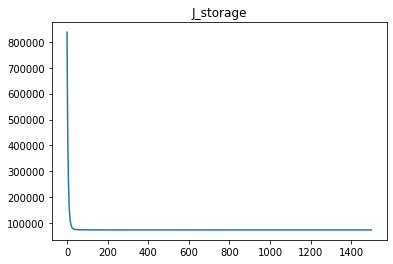

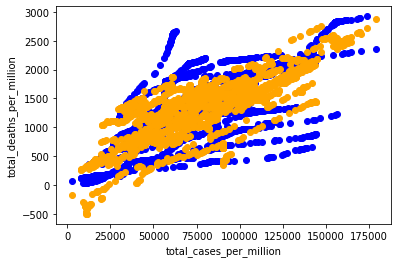

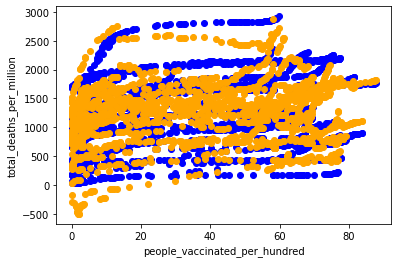

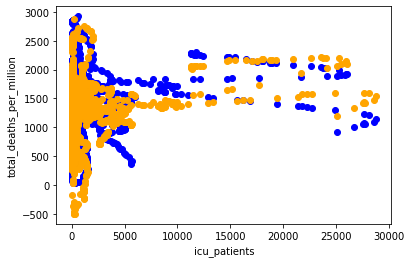

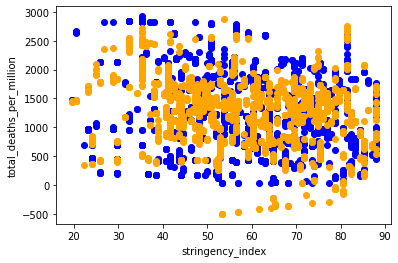

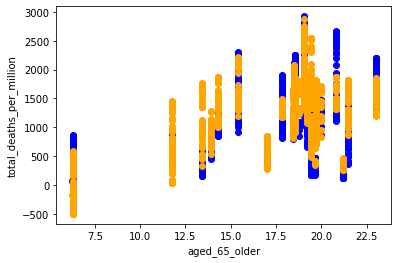

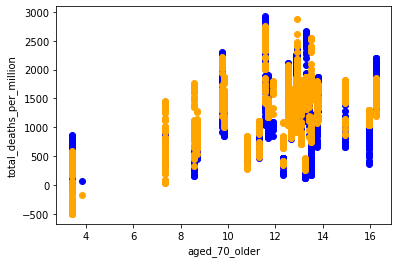

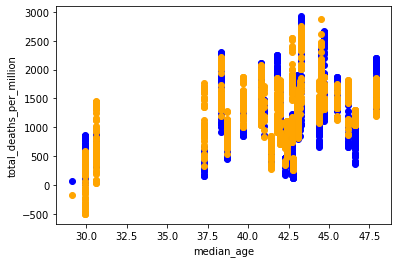

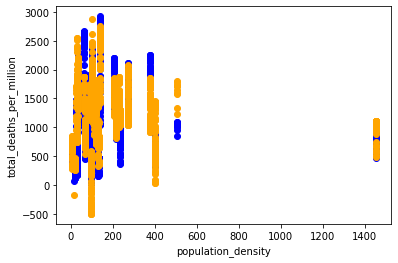

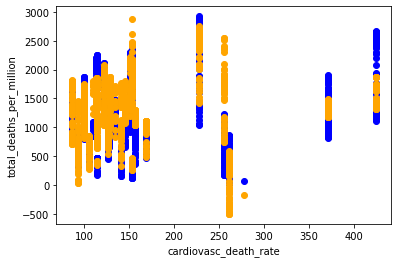

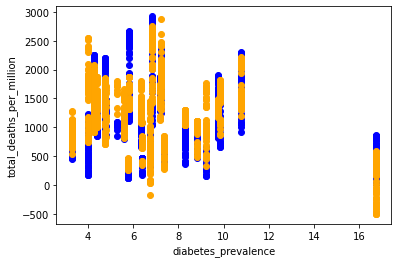

R^2 Score:  0.6646409030858708
Adjusted R^2 Score:  0.6641159350958245
SSᵣ (sum of the square of residuals):  316233538.1084514
SSₜ (total sum of errors if we take the mean of the observed values as the predicted value):  942969912.0087533
Mean Square Error:  149802.7181944346
Root Mean Squared Error:  387.04356110706016
Mean Absolute Error:  301.3062403076079
Mean Squared Log Error:  nan
Root Mean Squared Log Error:  nan
[[1269.55737392]
 [ 494.56545642]
 [  41.21318848]
 [  77.12774192]
 [ 156.99270472]
 [  -3.02408977]
 [  27.71348234]
 [ 232.14544859]
 [  -8.36919925]
 [ 180.18685584]
 [ -69.99080565]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log


In [ ]:
# interpolation is done to eliminate the nan values
# df_features, df_target = get_features_targets(df_first_world_countries.interpolate(method='linear', axis=0, limit_direction='both'), features, target)
  
# multiple_linear_regression function returns the coefficients of linear regression
beta = multiple_linear_regression(df_features, df_target, 'df_task_1.csv')
print(beta)

#### 1.4.2.2 Improvement 1: Removing Outliers
An outlier is a data value that is ‘distant’ from the main body of data values. In Modelling Uncertainty Week 1 Cohort 2, we learnt that data values that are more than 1.5 IQR below Q1 or 1.5 IQR above Q3 are generally considered to be outliers. As such, we decided to experiment with removing outliers as a method of improving our model's accuracy. 

In [ ]:
def remove_outliers(df):
  """Takes a DataFrame, returns a DataFrame with outliers removed according to IQR."""
  # Source: https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1
  return df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
df_outliers_removed = remove_outliers(df)
df_features, df_target = get_features_targets(df_outliers_removed.loc[:, columns].dropna(axis=0), features, target)

display(df_features.describe())
display(df_target.describe())

total_cases_per_million  ...  diabetes_prevalence
count               201.000000  ...           201.000000
mean              18837.446811  ...             8.724179
std               16315.531231  ...             4.874143
min                2400.944000  ...             5.590000
25%               10120.546000  ...             5.760000
50%               13250.039000  ...             5.760000
75%               18244.307000  ...            16.740000
max               64235.602000  ...            16.740000

[8 rows x 10 columns]

total_deaths_per_million
count                201.000000
mean                 235.892358
std                  328.195133
min                   34.354000
25%                   42.043000
50%                  145.809000
75%                  176.449000
max                 1152.316000

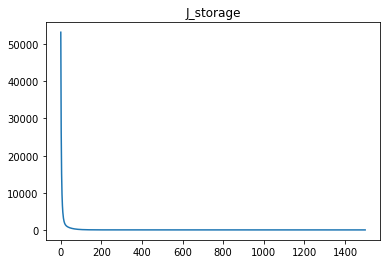

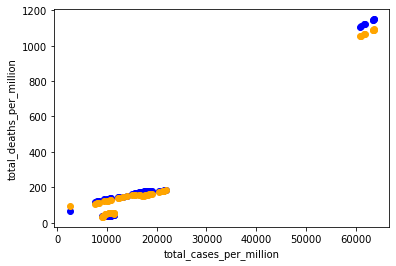

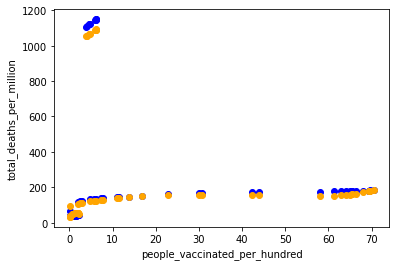

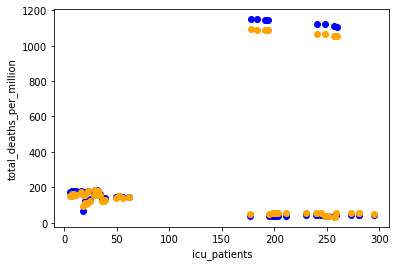

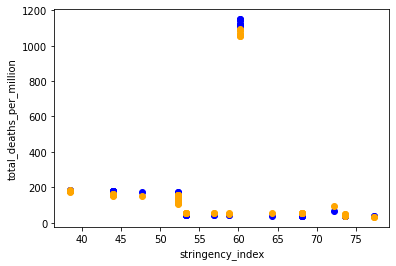

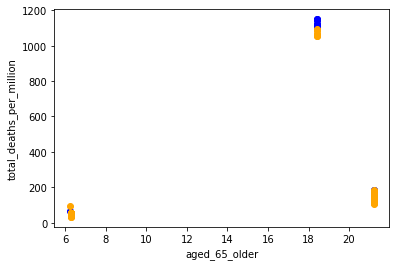

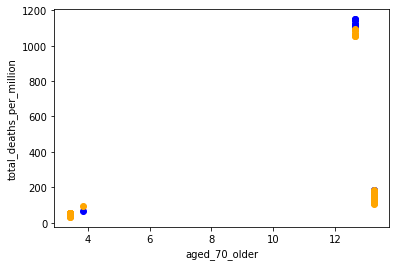

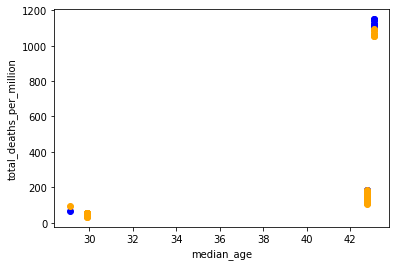

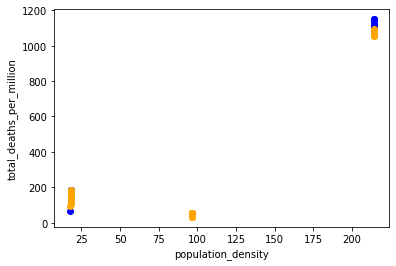

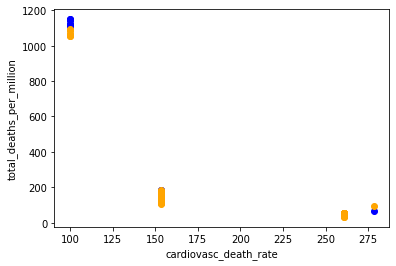

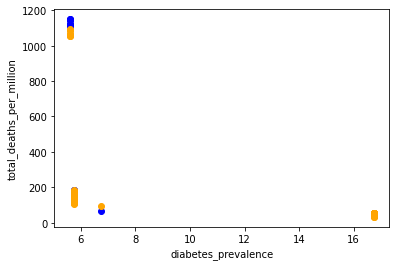

R^2 Score:  0.995371262682156
Adjusted R^2 Score:  0.9951018652721227
SSᵣ (sum of the square of residuals):  34453.02745435258
SSₜ (total sum of errors if we take the mean of the observed values as the predicted value):  7443288.544704182
Mean Square Error:  574.2171242392097
Root Mean Squared Error:  23.962827968318134
Mean Absolute Error:  17.47558635858009
Mean Squared Log Error:  0.029116538678408077
Root Mean Squared Log Error:  0.17063568993152656
[[ 235.89235821]
 [ 158.81643238]
 [ -21.07464534]
 [ -16.10032884]
 [  -2.48539177]
 [ -43.30512179]
 [ -13.3078019 ]
 [ -15.76353228]
 [ 151.05624196]
 [ -42.13491303]
 [-145.42687652]]


In [ ]:
# interpolation is done to eliminate the nan values
# df_features, df_target = get_features_targets(df_first_world_countries.interpolate(method='linear', axis=0, limit_direction='both'), features, target)
  
# multiple_linear_regression function returns the coefficients of linear regression
beta = multiple_linear_regression(df_features, df_target, 'df_task_1_removed_outliers.csv')
print(beta)

However, we notice that the scatter plot for the data without outliers, while cleaner and visually more accurate, seems to have less data points. This is correlated by the descriptive statistics above, showing that we only have less than 250 data points, down from the original dataset size of around 7000. 

As such, we decided that this would not provide an accurate result, and decided to not continue with this method of improving accuracy.  

#### 1.4.2.3 Improvement 2: First World Countries
Over the past 2 years, the COVID-19 pandemic to impact the Least Developed Countries (LDCs), Landlocked Developing Countries (LLDCs) and Small Island Developing States (SIDS) disproportionately with potentially devastating impacts on human health, including through social and economic effects of the virus and containment policies through the months and years to come. The lack of domestic financial resources, high debt levels and fragile health systems presents an urgent challenge. What has emerged as a health crisis in the short term may well have far reaching impacts on education, human rights, food security and economic development in the long term. 

The COVID-19 pandemic is also having a dramatic effect on global migration and tourism. Remittances comprise important revenue for most LDCs, LLDCs, and SIDS, which overall provides more funds than Official Development Assistance.

The United Nations noted that supporting these vulnerable country groups will need a three-pronged approach to:
1. Provide resources to stop the spread of COVID-19
2. Rapidly build capacity to curb the outbreak
3. Provision of resources to avoid economic collapse. Both financial and technical support will be necessary to limit the impact on the most vulnerable countries. 

A statement by the High Representative for the LDCs, LLDCs and SIDS, Fekitamoeloa Katoa ‘Utoikamanu, stresses that to avoid a truly devastating global tragedy, in the days, weeks and months ahead, it will be critical that the international community urgently support vulnerable countries to strengthen their health systems and their capacity to halt transmission. In an ever more interconnected world, we are only as strong as our weakest health system. 

Reference: https://www.un.org/ohrlls/news/world%E2%80%99s-most-vulnerable-countries-lack-capacity-respond-global-pandemic-credit-mfdelyas-alwazir

With that said, we decided to explore the possibility that some of these LDCs, LLDCs and SIDS had healthcare systems that were overwhelmed and hence unable to accurately log the true data as well as other more developed countries. As such, we decided to only use the data from the first world countries in our model. 

In [ ]:
# https://worldpopulationreview.com/country-rankings/first-world-countries 
# according to this, first world countries usually have HDI above 0.8

df_first_world_countries = df[df['human_development_index'] >= 0.8]

unique_codes = list(df_first_world_countries['iso_code'].unique())

print("Number of First World Countries:", len(unique_codes))
print(unique_codes)

Number of First World Countries: 66
['AND', 'ARG', 'AUS', 'AUT', 'BHS', 'BHR', 'BRB', 'BLR', 'BEL', 'BRN', 'BGR', 'CAN', 'CHL', 'CRI', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'GEO', 'DEU', 'GRC', 'HKG', 'HUN', 'ISL', 'IRL', 'ISR', 'ITA', 'JPN', 'KAZ', 'KWT', 'LVA', 'LIE', 'LTU', 'LUX', 'MYS', 'MLT', 'MUS', 'MNE', 'NLD', 'NZL', 'NOR', 'OMN', 'PLW', 'PAN', 'POL', 'PRT', 'QAT', 'ROU', 'RUS', 'SAU', 'SRB', 'SGP', 'SVK', 'SVN', 'KOR', 'ESP', 'SWE', 'CHE', 'TUR', 'ARE', 'GBR', 'USA', 'URY']


##### 1.4.2.3.1 Visualisation and Plots
Similar to Section 1.4.1 above, for visualisation of the data, we made use of Matplotlib and Seaborn that were introduced to us in class and the [pre-class material](https://github.com/Data-Driven-World/d2w_notes/blob/master/Visualization.ipynb). 

As the code for visualisation was repeated over the course of this report, they were defined as functions in the earlier sections. 

For any data that required preprocessing or further DataFrame analysis, we made use of codes from the cohort lessons and [pre-class material](https://github.com/Data-Driven-World/d2w_notes/blob/master/Working_With_Data.ipynb). 
For more information, refer to https://github.com/Data-Driven-World/d2w_notes/blob/master/Visualization.ipynb


In [ ]:
features = ["total_cases_per_million", "people_vaccinated_per_hundred", "icu_patients", "stringency_index", "aged_65_older", "aged_70_older", "median_age", "population_density", "cardiovasc_death_rate", "diabetes_prevalence"]
target = ['total_deaths_per_million']
columns = features + target

df_features_target = df_first_world_countries[columns]

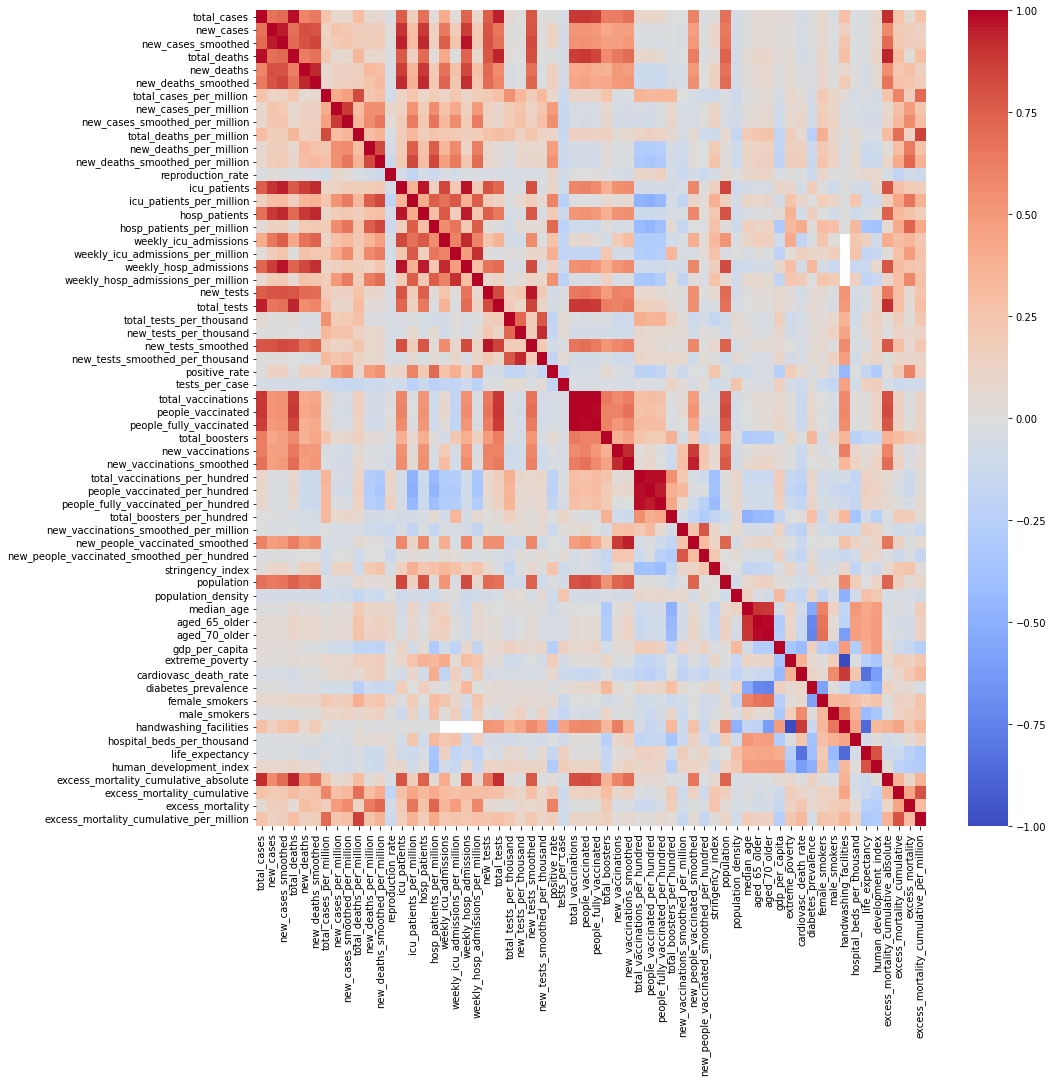

total_deaths_per_million
excess_mortality_cumulative_per_million                     0.857972
total_cases_per_million                                     0.826588
excess_mortality_cumulative                                 0.690162
female_smokers                                              0.387041
new_deaths_smoothed_per_million                             0.365136
new_cases_smoothed_per_million                              0.348679
total_deaths                                                0.336692
icu_patients_per_million                                    0.327466
total_tests                                                 0.304215
excess_mortality_cumulative_absolute                        0.303218
new_cases_per_million                                       0.301082
total_cases                                                 0.299350
new_deaths_per_million                                      0.295010
total_tests_per_thousand                                    0.272264
new_tests                                                   0.259815
aged_70_older                                               0.259449
aged_65_older                                               0.246902
hosp_patients_per_million                                   0.246741
new_tests_smoothed                                          0.242355
weekly_icu_admissions                                       0.219030
weekly_icu_admissions_per_million                           0.201622
median_age                                                  0.200204
weekly_hosp_admissions_per_million                          0.186992
new_cases_smoothed                                          0.178515
icu_patients                                                0.172843
hosp_patients                                               0.170100
new_cases                                                   0.168881
extreme_poverty                                             0.165467
weekly_hosp_admissions                                      0.165141
new_deaths_smoothed                                         0.164144
total_vaccinations                                          0.163787
people_vaccinated                                           0.163233
people_vaccinated_per_hundred                               0.152076
new_deaths                                                  0.149719
total_boosters                                              0.149576
people_fully_vaccinated                                     0.147517
new_tests_per_thousand                                      0.143824
new_tests_smoothed_per_thousand                             0.132328
people_fully_vaccinated_per_hundred                         0.132321
excess_mortality                                            0.132313
total_vaccinations_per_hundred                              0.123361
positive_rate                                               0.096102
male_smokers                                                0.087967
new_vaccinations_smoothed                                   0.078510
population                                                  0.074952
total_boosters_per_hundred                                  0.067143
cardiovasc_death_rate                                       0.065847
new_people_vaccinated_smoothed                              0.052640
new_vaccinations                                            0.049071
hospital_beds_per_thousand                                  0.046940
handwashing_facilities                                      0.009454
life_expectancy                                            -0.023965
human_development_index                                    -0.025292
new_vaccinations_smoothed_per_million                      -0.040669
reproduction_rate                                          -0.053169
new_people_vaccinated_smoothed_per_hundred                 -0.094003
stringency_index                                           -0.104484
tests_per_case                            

In [ ]:
df_correlation = determine_correlation(df_first_world_countries, "total_deaths_per_million")
plot_correlation_heatmaps(df_first_world_countries, figsize=(15, 15), annot=False)
df_correlation

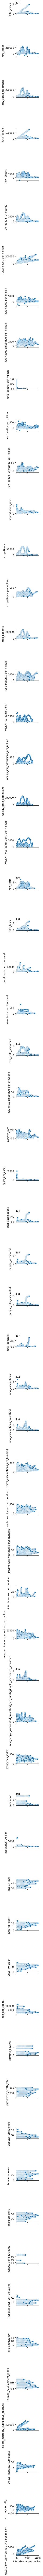

In [ ]:
# Plot predictor variables against total deaths per million
df_scatter = df_first_world_countries.drop(labels=['iso_code', 'continent', 'location', 'date', 'tests_units'], axis=1)
sns.pairplot(data=df_scatter, x_vars=['total_deaths_per_million'])

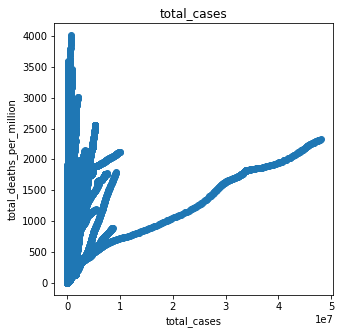

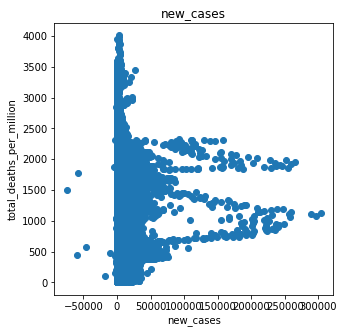

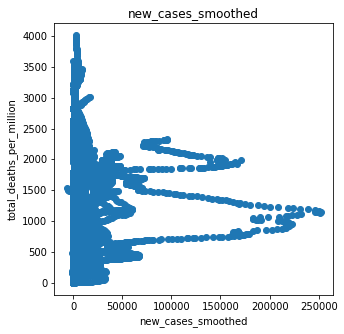

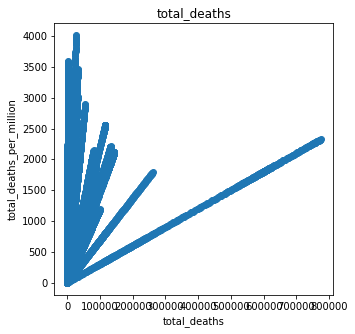

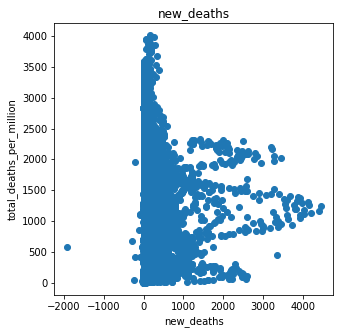

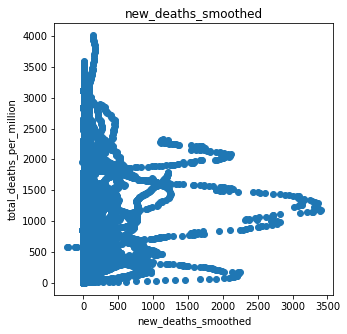

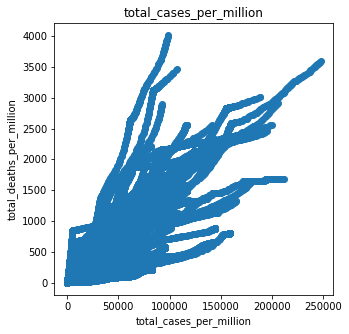

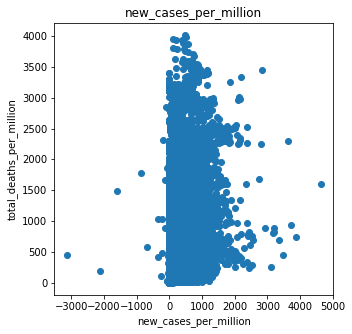

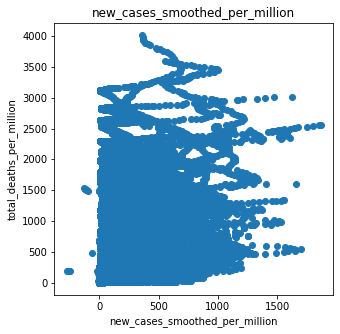

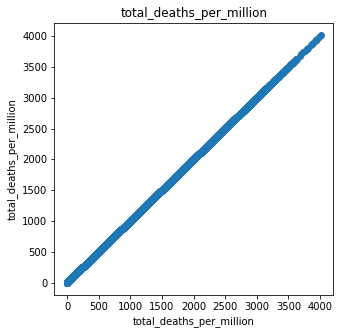

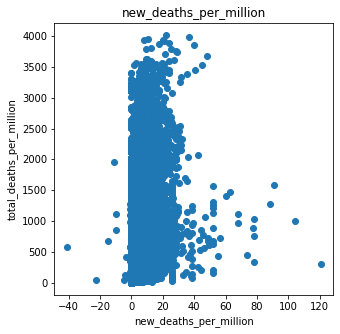

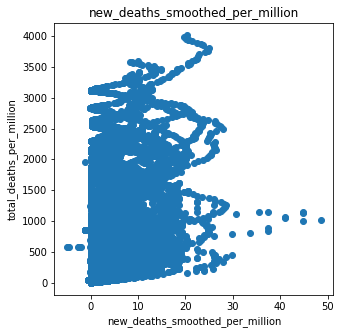

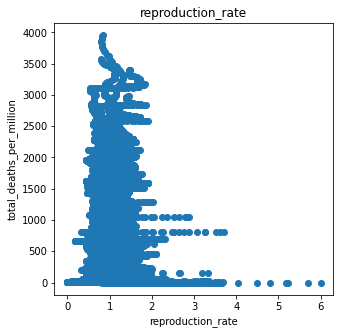

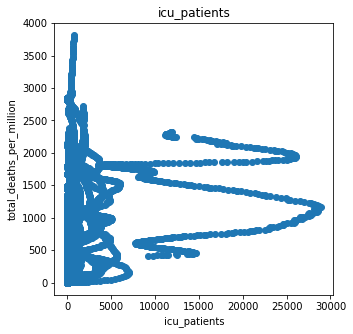

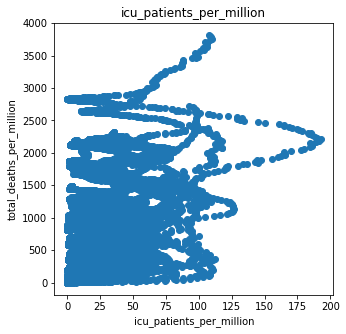

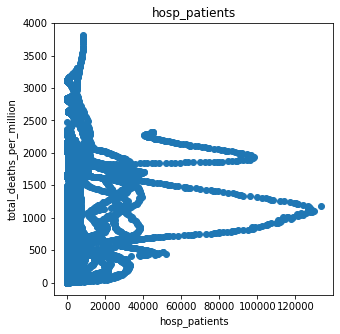

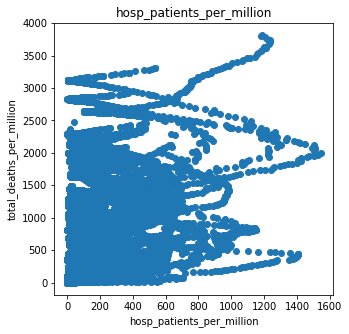

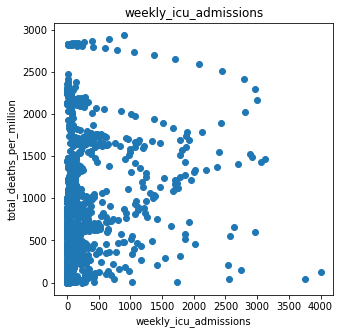

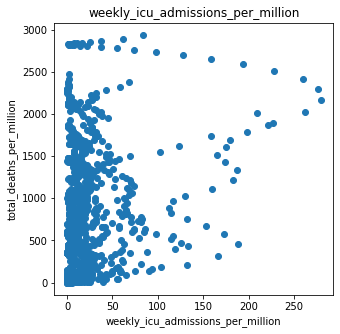

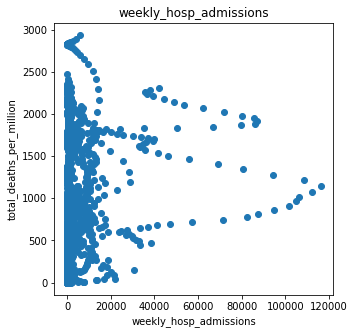

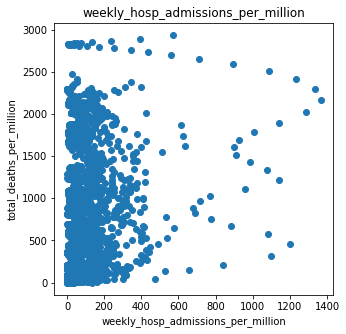

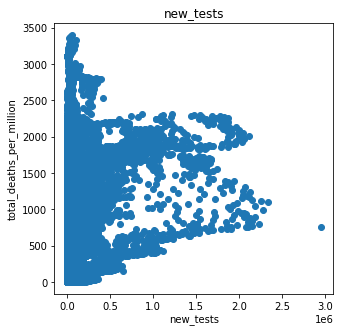

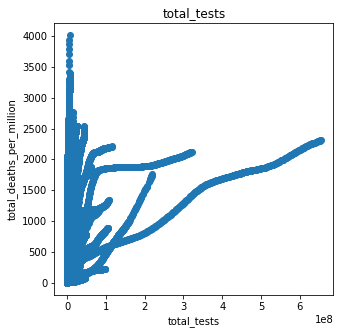

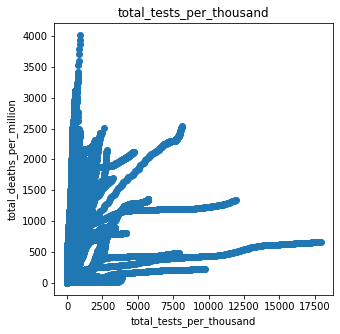

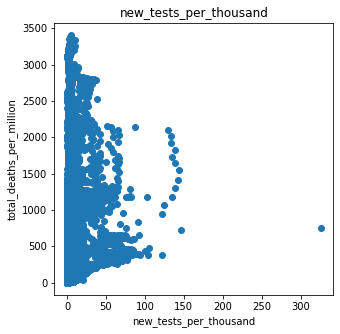

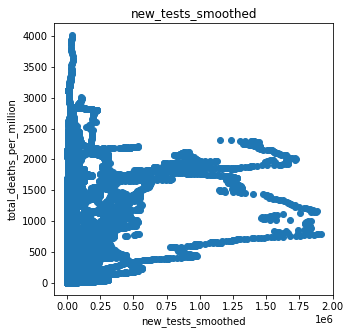

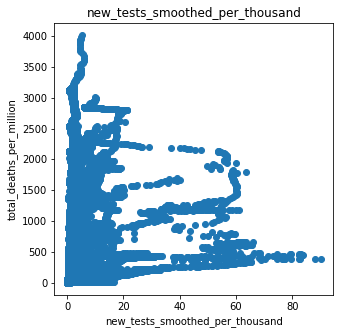

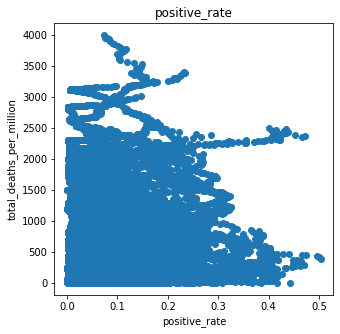

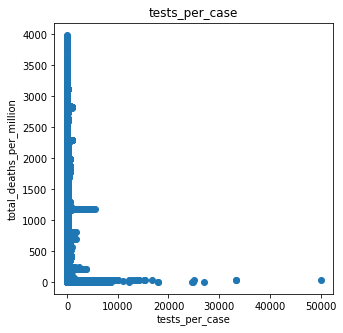

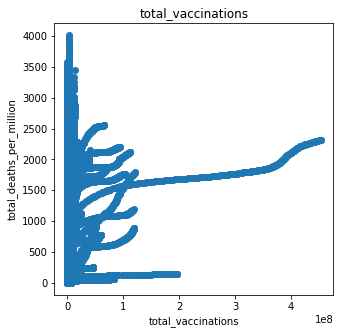

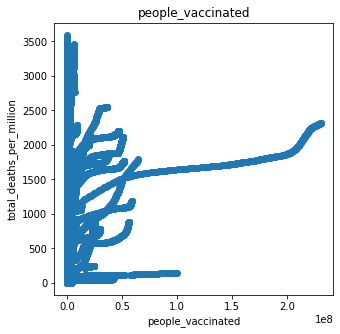

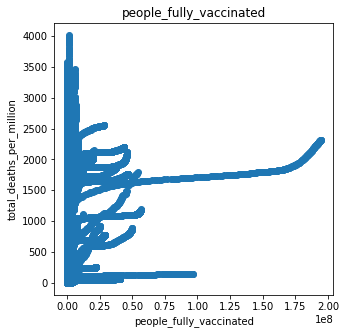

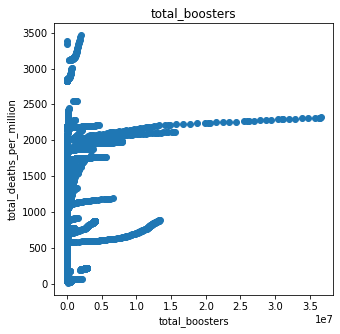

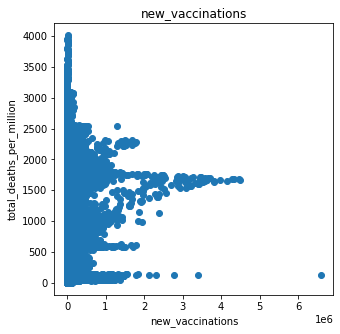

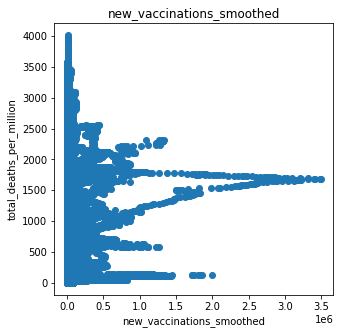

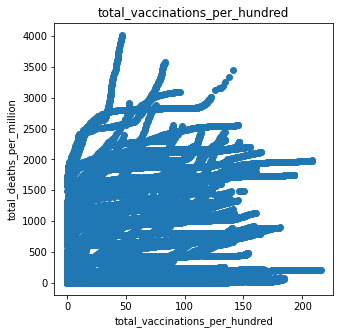

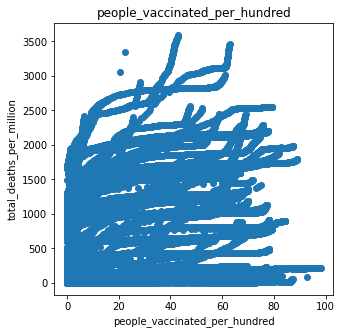

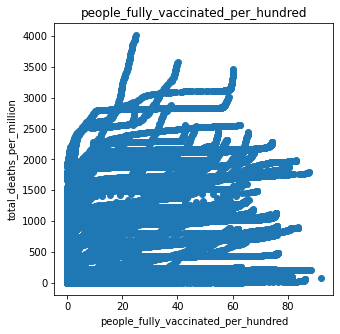

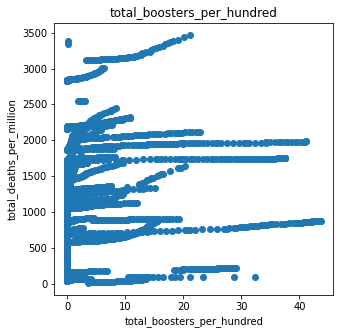

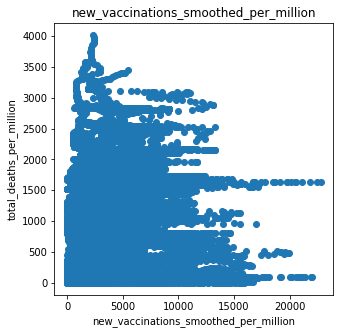

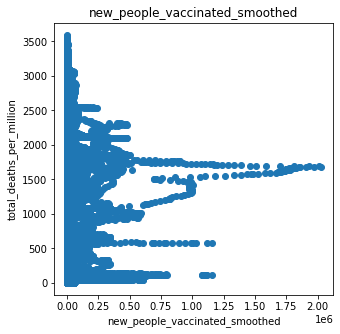

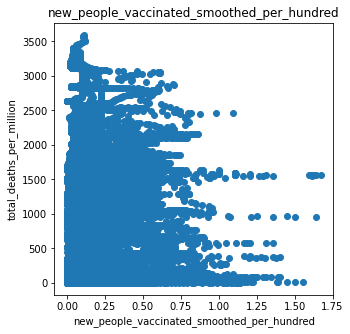

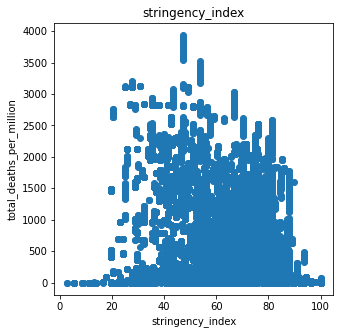

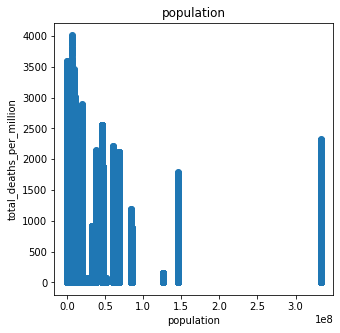

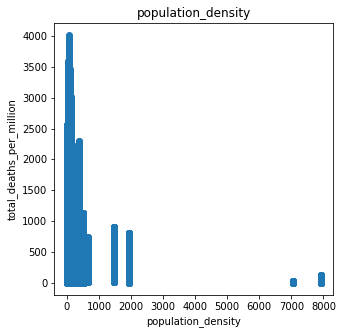

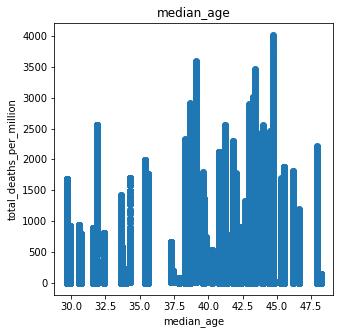

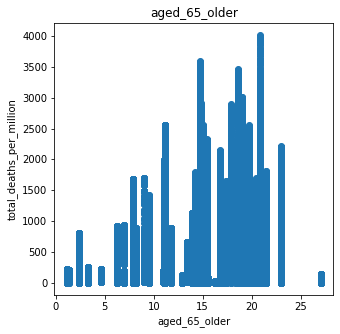

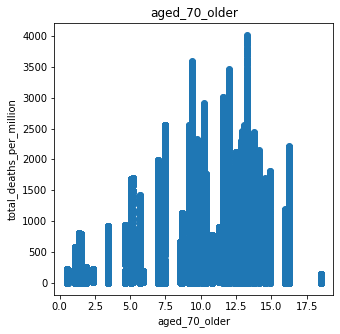

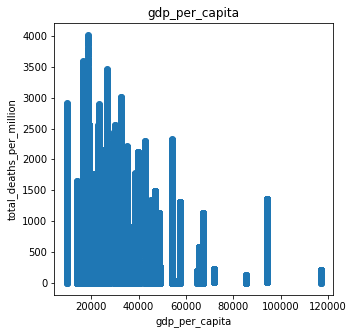

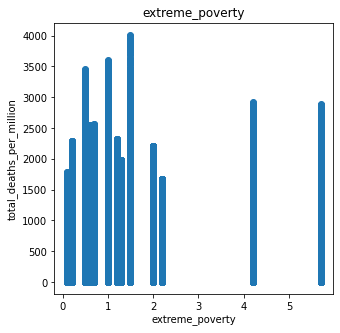

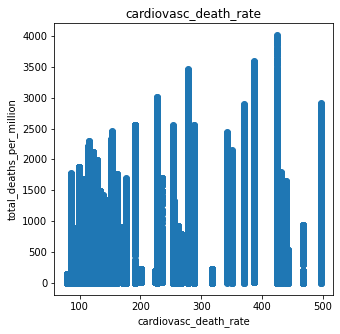

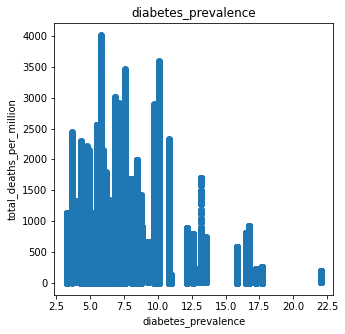

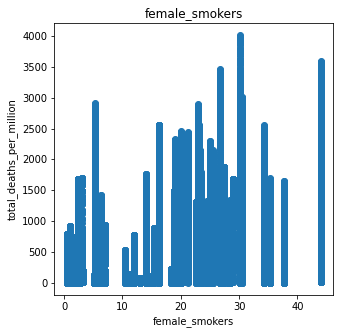

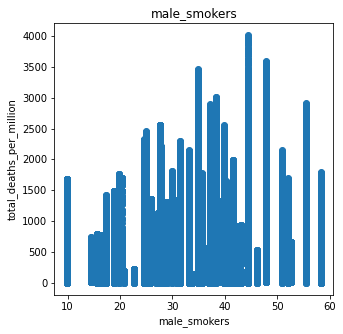

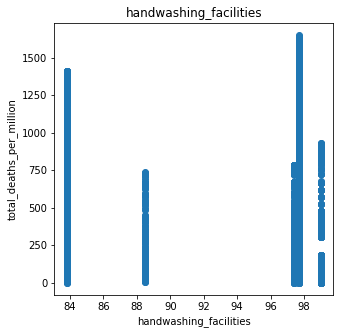

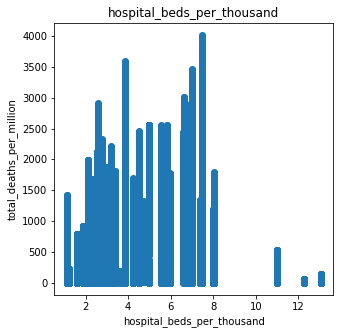

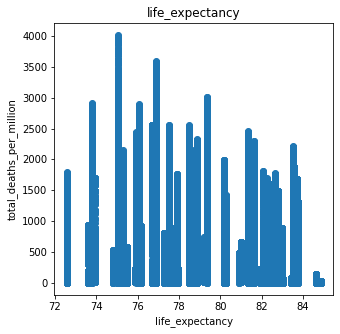

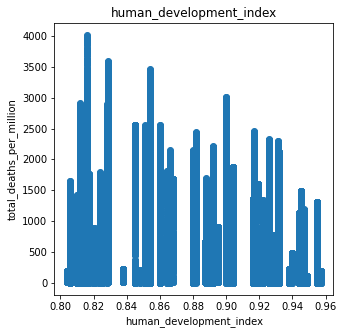

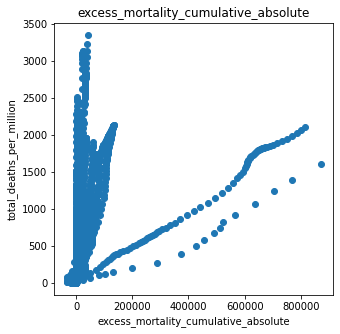

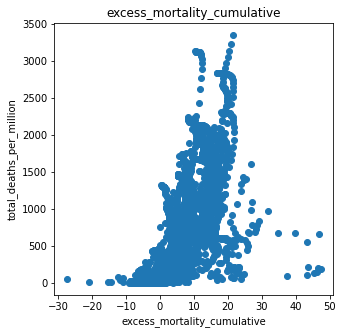

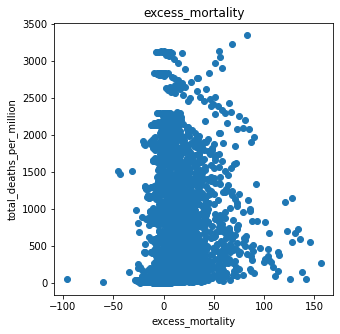

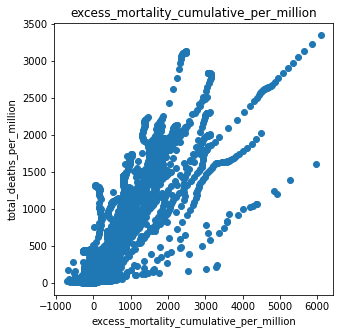

In [ ]:
for col in df_scatter.columns:
  plt.figure(figsize=(5,5))
  plt.xlabel(col)
  plt.ylabel("total_deaths_per_million")
  plt.title(col)
  plt.scatter(df_first_world_countries[col], df_first_world_countries["total_deaths_per_million"])
  plt.show() 

Based on our analysis above, we narrowed down to 10 different predictor variables to be used for our Multiple Linear Regression model. The predictor variables, the relevant descriptions, and metrics (mentioned in Section 1.1 above)

**Predictor Variables (X)**

Variable (X) | Description | Metrics (from OWID)
-------------------|------------------ | ------------------
total_cases | Total confirmed cases of COVID-19 | Confirmed cases
people_vaccinated_per_hundred      | Total number of people who received at least one vaccine dose per 100 people in the total population | Vaccinations
icu_patients | Number of COVID-19 patients in intensive care units (ICUs) on a given day | Hospital & ICU 
stringency_index | Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response) | Policy responses
aged_65_older | Share of the population that is 65 years and older, most recent year available | Others
aged_70_older | Share of the population that is 70 years and older in 2015 | Others
median_age | Median age of the population, UN projection for 2020 | Others
population_density | Number of people divided by land area, measured in square kilometers, most recent year available | Others
cardiovasc_death_rate | Death rate from cardiovascular disease in 2017 (annual number of deaths per 100,000 people) | Others
diabetes_prevalence | Diabetes prevalence (% of population aged 20 to 79) in 2017 | Others


**Predicted Variable (y)**

Variable (y) | Description | Category
-------------------|------------------ | ------------------
total_deaths_per_million | Total deaths attributed to COVID-19 | Confirmed deaths

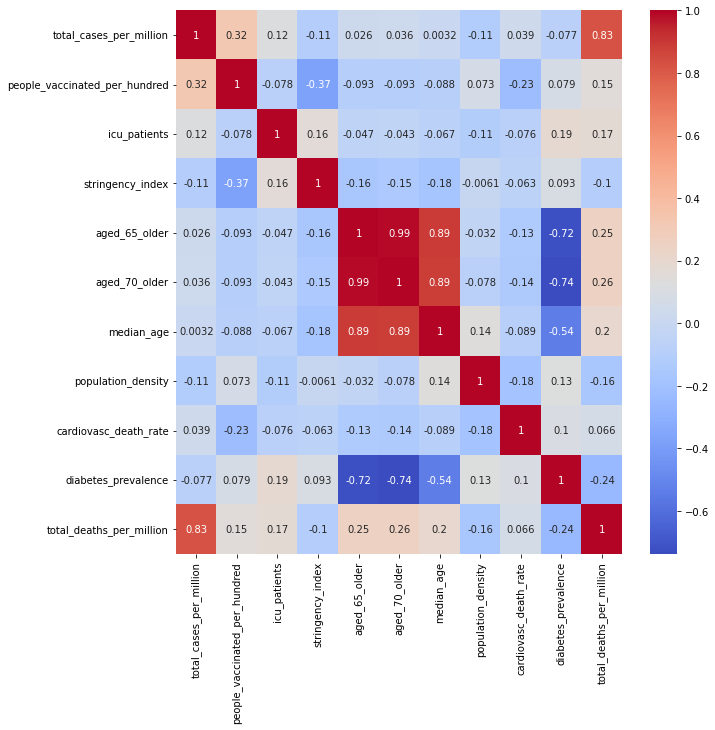

In [ ]:
features = ["total_cases_per_million", "people_vaccinated_per_hundred", "icu_patients", "stringency_index", "aged_65_older", "aged_70_older", "median_age", "population_density", "cardiovasc_death_rate", "diabetes_prevalence"]
target = ['total_deaths_per_million']
columns = features + target

df_features_target = df_first_world_countries[columns]
plot_correlation_heatmaps(df_features_target, figsize=(10, 10), annot=True)

##### 1.4.2.3.2 Multiple Linear Regression
For more information, refer to https://github.com/Data-Driven-World/d2w_notes/blob/master/Multiple_Linear_Regression.ipynb

In [ ]:
df_features, df_target = get_features_targets(df_first_world_countries.loc[:, columns].dropna(axis=0), features, target)

display(df_features.describe())
display(df_target.describe())

total_cases_per_million  ...  diabetes_prevalence
count              7069.000000  ...          7069.000000
mean              74600.185901  ...             6.870771
std               34639.802804  ...             2.810099
min                7708.943000  ...             3.280000
25%               48674.741000  ...             4.770000
50%               71279.539000  ...             6.410000
75%               97235.108000  ...             8.310000
max              181910.721000  ...            16.740000

[8 rows x 9 columns]

total_deaths_per_million
count               7069.000000
mean                1269.934985
std                  665.406580
min                   33.347000
25%                  768.259000
50%                 1189.198000
75%                 1783.845000
max                 3345.535000

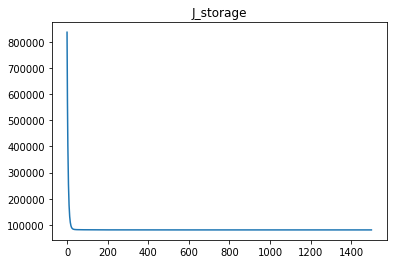

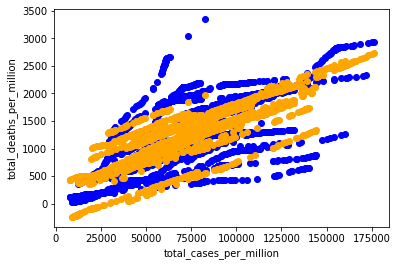

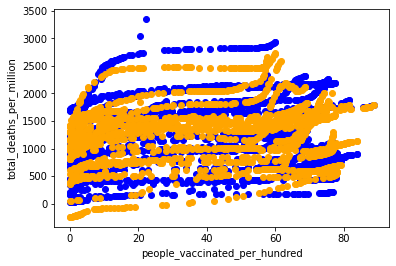

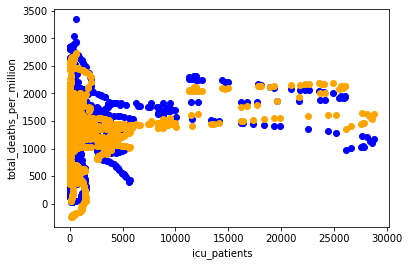

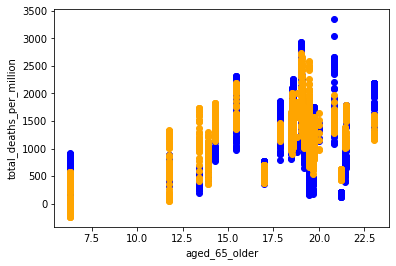

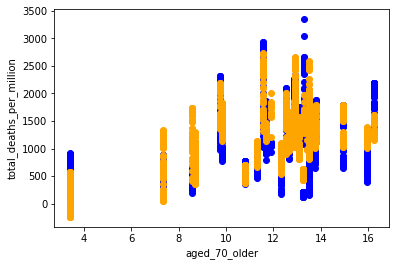

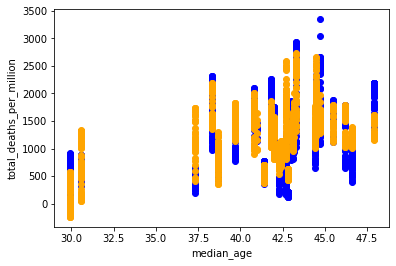

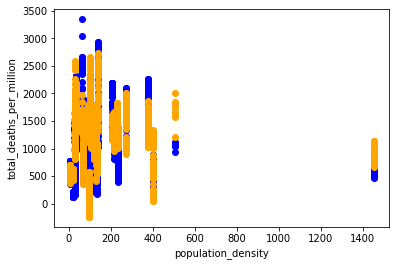

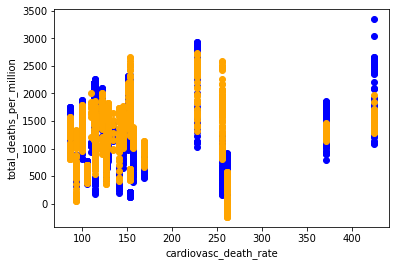

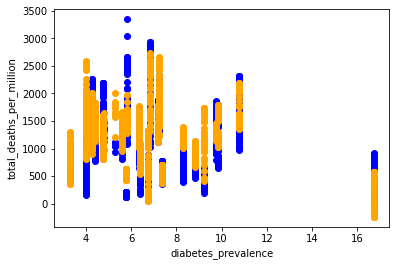

R^2 Score:  0.6320243373767425
Adjusted R^2 Score:  0.6315029776960634
SSᵣ (sum of the square of residuals):  348650319.3977635
SSₜ (total sum of errors if we take the mean of the observed values as the predicted value):  947482007.1313255
Mean Square Error:  164457.6978291337
Root Mean Squared Error:  405.53384301329737
Mean Absolute Error:  315.4363960295144
Mean Squared Log Error:  nan
Root Mean Squared Log Error:  nan
[[1269.93498529]
 [ 452.84276077]
 [ -35.36340498]
 [  88.82071218]
 [ -82.9672268 ]
 [  73.75283228]
 [ 271.85437143]
 [  -2.64217206]
 [ 125.67702751]
 [ -35.09049168]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log


In [ ]:
# interpolation is done to eliminate the nan values
# df_features, df_target = get_features_targets(df_first_world_countries.interpolate(method='linear', axis=0, limit_direction='both'), features, target)
  
# multiple_linear_regression function returns the coefficients of linear regression
beta = multiple_linear_regression(df_features, df_target, 'df_task_1_first_world.csv')
print(beta)

#### 1.4.2.4 Improvement 3: Removing Features

##### 1.4.2.4.1 Visualisation and Plots
Similar to Section 1.4.1 above, for visualisation of the data, we made use of Matplotlib and Seaborn that were introduced to us in class and the [pre-class material](https://github.com/Data-Driven-World/d2w_notes/blob/master/Visualization.ipynb). 

As the code for visualisation was repeated over the course of this report, they were defined as functions in the earlier sections. 

For any data that required preprocessing or further DataFrame analysis, we made use of codes from the cohort lessons and [pre-class material](https://github.com/Data-Driven-World/d2w_notes/blob/master/Working_With_Data.ipynb). 
For more information, refer to https://github.com/Data-Driven-World/d2w_notes/blob/master/Visualization.ipynb


**Predictor Variables (X)**

Variable (X) | Description | Metrics (from OWID)
-------------------|------------------ | ------------------
total_cases | Total confirmed cases of COVID-19 | Confirmed cases
people_vaccinated_per_hundred      | Total number of people who received at least one vaccine dose per 100 people in the total population | Vaccinations
icu_patients | Number of COVID-19 patients in intensive care units (ICUs) on a given day | Hospital & ICU 
stringency_index | Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response) | Policy responses
aged_65_older | Share of the population that is 65 years and older, most recent year available | Others
aged_70_older | Share of the population that is 70 years and older in 2015 | Others
median_age | Median age of the population, UN projection for 2020 | Others
population_density | Number of people divided by land area, measured in square kilometers, most recent year available | Others
cardiovasc_death_rate | Death rate from cardiovascular disease in 2017 (annual number of deaths per 100,000 people) | Others
diabetes_prevalence | Diabetes prevalence (% of population aged 20 to 79) in 2017 | Others


**Predicted Variable (y)**

Variable (y) | Description | Category
-------------------|------------------ | ------------------
total_deaths_per_million | Total deaths attributed to COVID-19 | Confirmed deaths

In [ ]:
features = ["total_cases_per_million", "people_vaccinated_per_hundred", "icu_patients", "aged_65_older", "aged_70_older", "median_age", "population_density", "cardiovasc_death_rate", "diabetes_prevalence"]
# features = ["total_cases_per_million", "people_vaccinated_per_hundred", "icu_patients", "stringency_index", "median_age", "population_density"]
target = ['total_deaths_per_million']
columns = features + target

df_features_target = df[columns]

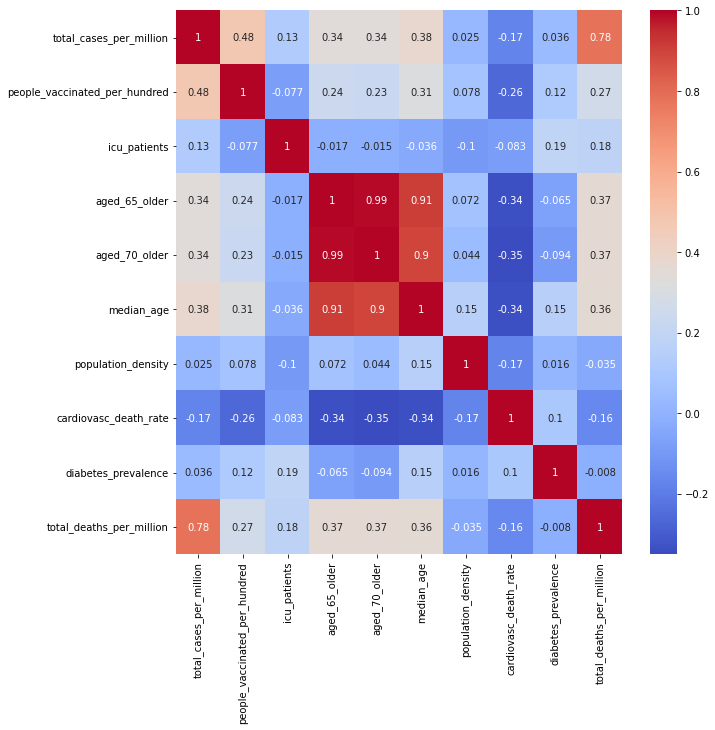

total_deaths_per_million
total_cases_per_million                        0.779900
aged_70_older                                  0.366685
aged_65_older                                  0.366193
median_age                                     0.359255
people_vaccinated_per_hundred                  0.265706
icu_patients                                   0.178673
diabetes_prevalence                           -0.008049
population_density                            -0.034644
cardiovasc_death_rate                         -0.159672

In [ ]:
df_correlation = determine_correlation(df_features_target, "total_deaths_per_million")
plot_correlation_heatmaps(df_features_target, figsize=(10, 10), annot=True)
df_correlation

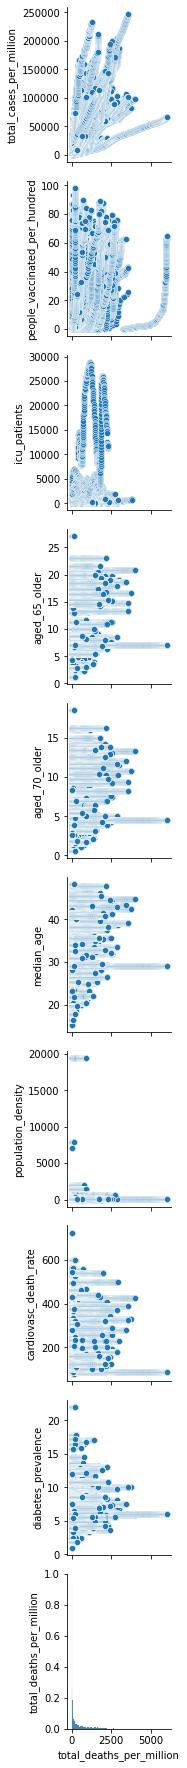

In [ ]:
# Plot predictor variables against total deaths per million
df_scatter = df_features_target
sns.pairplot(data=df_scatter, x_vars=['total_deaths_per_million'])

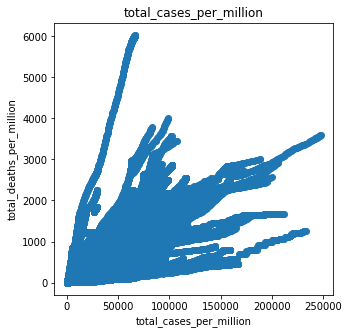

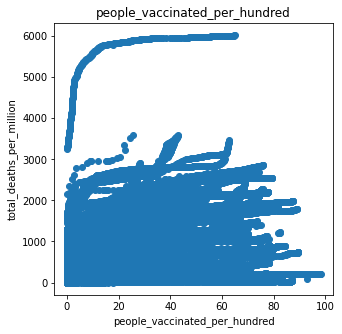

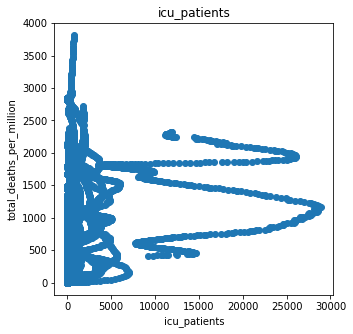

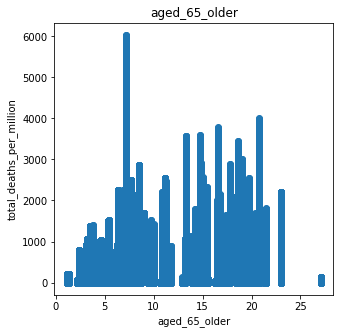

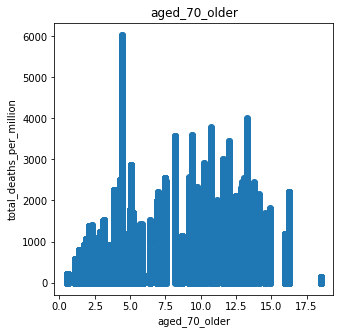

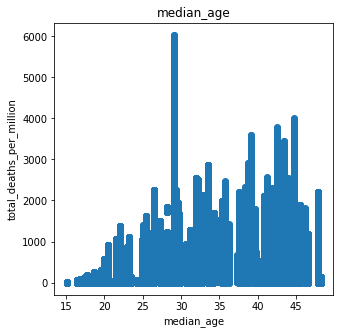

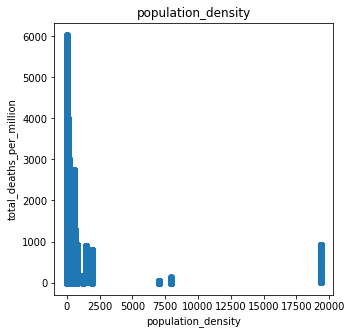

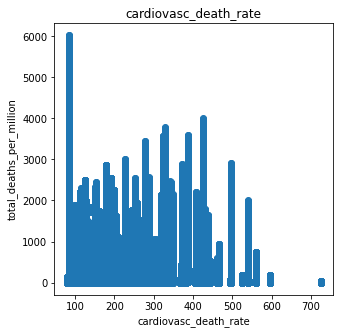

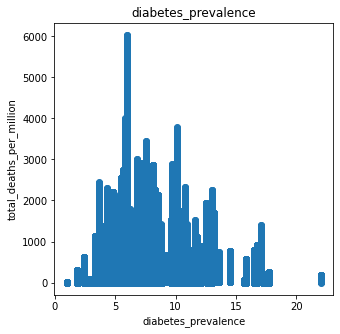

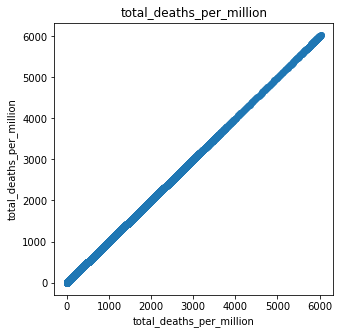

In [ ]:
for col in df_scatter.columns:
  plt.figure(figsize=(5,5))
  plt.xlabel(col)
  plt.ylabel("total_deaths_per_million")
  plt.title(col)
  plt.scatter(df_features_target[col], df_features_target["total_deaths_per_million"])
  plt.show() 

##### 1.4.2.4.2 Multiple Linear Regression
For more information, refer to https://github.com/Data-Driven-World/d2w_notes/blob/master/Multiple_Linear_Regression.ipynb

In [ ]:
df_features, df_target = get_features_targets(df_first_world_countries.loc[:, columns].dropna(axis=0), features, target)

display(df_features.describe())
display(df_target.describe())

total_cases_per_million  ...  diabetes_prevalence
count              7069.000000  ...          7069.000000
mean              74600.185901  ...             6.870771
std               34639.802804  ...             2.810099
min                7708.943000  ...             3.280000
25%               48674.741000  ...             4.770000
50%               71279.539000  ...             6.410000
75%               97235.108000  ...             8.310000
max              181910.721000  ...            16.740000

[8 rows x 9 columns]

total_deaths_per_million
count               7069.000000
mean                1269.934985
std                  665.406580
min                   33.347000
25%                  768.259000
50%                 1189.198000
75%                 1783.845000
max                 3345.535000

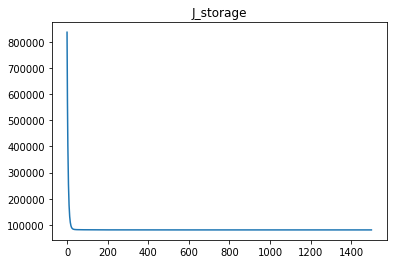

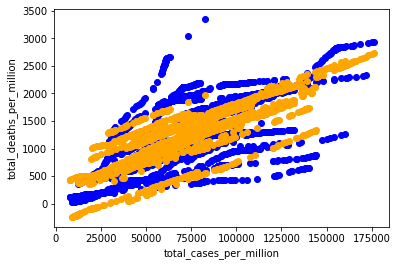

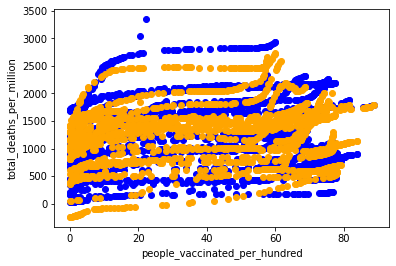

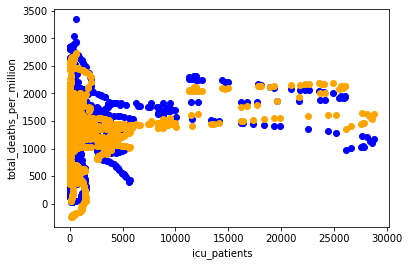

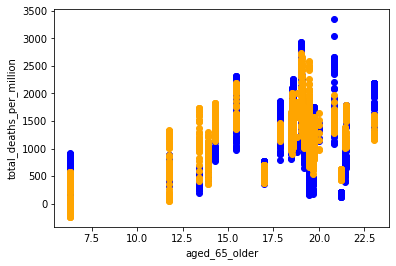

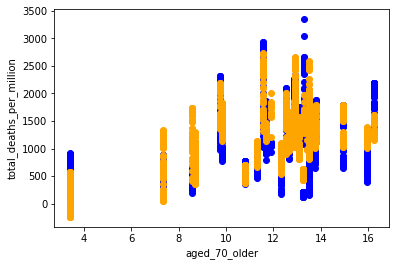

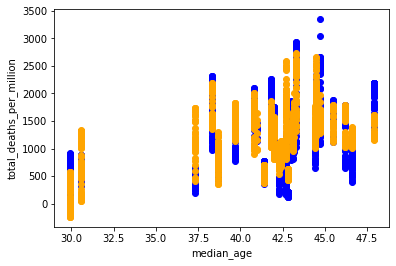

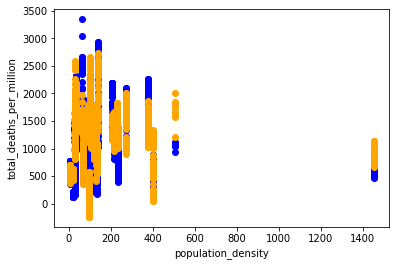

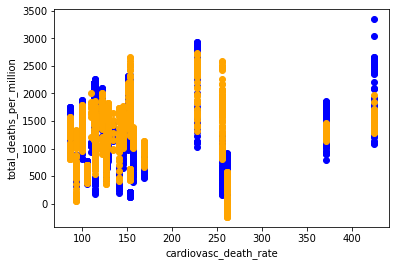

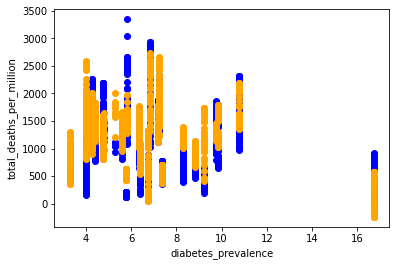

R^2 Score:  0.6320243373767425
Adjusted R^2 Score:  0.6315029776960634
SSᵣ (sum of the square of residuals):  348650319.3977635
SSₜ (total sum of errors if we take the mean of the observed values as the predicted value):  947482007.1313255
Mean Square Error:  164457.6978291337
Root Mean Squared Error:  405.53384301329737
Mean Absolute Error:  315.4363960295144
Mean Squared Log Error:  nan
Root Mean Squared Log Error:  nan
[[1269.93498529]
 [ 452.84276077]
 [ -35.36340498]
 [  88.82071218]
 [ -82.9672268 ]
 [  73.75283228]
 [ 271.85437143]
 [  -2.64217206]
 [ 125.67702751]
 [ -35.09049168]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log


In [ ]:
# interpolation is done to eliminate the nan values
# df_features, df_target = get_features_targets(df_first_world_countries.interpolate(method='linear', axis=0, limit_direction='both'), features, target)
  
# multiple_linear_regression function returns the coefficients of linear regression
beta = multiple_linear_regression(df_features, df_target, 'df_task_1_removed_features.csv')
print(beta)